In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
# Load the dataset
data = pd.read_csv('Xray Scan Data Jul 2022.csv')

In [144]:
# Get some basic information about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248832 entries, 0 to 1248831
Data columns (total 7 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   bag_scan_timestamp          1248832 non-null  object
 1   bag_licence_plate           1248832 non-null  int64 
 2   scan_machine_id             1248832 non-null  object
 3   scan_machine_cluster        1248832 non-null  object
 4   scan_machine_level          1248832 non-null  object
 5   scan_machine_result         1248832 non-null  object
 6   scan_machine_result_reason  1248832 non-null  object
dtypes: int64(1), object(6)
memory usage: 66.7+ MB


# Content Page:

##### Data Filtering for duplicates (Data_1 & Data 2)
##### Data_2
##### - Time by day & hour
1. Visual Depiction of Bag Throughput
2. Heatmap for Demand Level
3. Peak Day Analysis

##### - Machines
4. Distribution Analysis
5. Machine Performance Analysis
6. Level 2 Screening Analysis
7. Recirculation Analysis

##### - Timeout
8. "Time Out" Situations & "Time Out" Rate Analysis by Day & Machines
9. Stress Level

##### Data_1
10. Error Rate Analysis
11. 'Time Out' Analysis

### Data_1

In [145]:
# Group by 'bag_licence_plate' and count occurrences
duplicate_bags = data.groupby('bag_licence_plate').size()

# Filter out the bags that appear only once
duplicate_bags = duplicate_bags[duplicate_bags > 1]
duplicate_bags.sort_values(ascending=False)

bag_licence_plate
1256122123     56
1257117295     38
1052108378     27
749191154      25
49977181627    25
               ..
1312180435      2
1312180439      2
1312180449      2
1312180461      2
99325195010     2
Length: 325621, dtype: int64

In [147]:
data[data['bag_licence_plate'] == 1052108378]

bag_scan_timestamp  bag_licence_plate scan_machine_id  \
238181  2022-07-06 14:08:27         1052108378       Machine 4   
238204  2022-07-06 14:08:55         1052108378       Machine 4   
242001  2022-07-06 15:51:16         1052108378       Machine 8   
242008  2022-07-06 15:51:29         1052108378       Machine 8   
247310  2022-07-06 18:23:23         1052108378       Machine 5   
250764  2022-07-06 19:52:04         1052108378       Machine 4   
250938  2022-07-06 19:57:21         1052108378       Machine 6   
251854  2022-07-06 20:21:26         1052108378       Machine 4   
251884  2022-07-06 20:22:05         1052108378       Machine 4   
258889  2022-07-07 06:49:42         1052108378       Machine 6   
259652  2022-07-07 07:04:23         1052108378       Machine 4   
259681  2022-07-07 07:04:45         1052108378       Machine 4   
263697  2022-07-07 08:18:27         1052108378       Machine 6   
264055  2022-07-07 08:24:24         1052108378       Machine 6   
264076  2022-07-07 08:24:42         1052108378       Machine 6   
264956  2022-07-07 08:39:20         1052108378       Machine 6   
264993  2022-07-07 08:39:46         1052108378       Machine 6   
265289  2022-07-07 08:44:36         1052108378       Machine 3   
265302  2022-07-07 08:44:51         1052108378       Machine 3   
267195  2022-07-07 09:12:30         1052108378       Machine 7   
267229  2022-07-07 09:12:57         1052108378       Machine 7   
270961  2022-07-07 10:11:51         1052108378       Machine 4   
490935  2022-07-12 12:34:46         1052108378       Machine 4   
498605  2022-07-12 15:37:38         1052108378       Machine 5   
498612  2022-07-12 15:37:51         1052108378       Machine 5   
893715  2022-07-22 19:05:43         1052108378       Machine 1   
893726  2022-07-22 19:06:02         1052108378       Machine 1   

       scan_machine_cluster scan_machine_level scan_machine_result  \
238181            Cluster B            Level 1            Rejected   
238204            Cluster B            Level 2             Cleared   
242001            Cluster B            Level 1            Rejected   
242008            Cluster B            Level 2             Cleared   
247310            Cluster A            Level 1            Rejected   
250764            Cluster B            Level 1             Cleared   
250938            Cluster A            Level 1            Rejected   
251854            Cluster B            Level 1            Rejected   
251884            Cluster B            Level 2             Cleared   
258889            Cluster A            Level 1             Cleared   
259652            Cluster B            Level 1            Rejected   
259681            Cluster B            Level 2             Cleared   
263697            Cluster A            Level 1             Cleared   
264055            Cluster A            Level 1            Rejected   
264076            Cluster A            Level 2             Cleared   
264956            Cluster A            Level 1            Rejected   
264993            Cluster A            Level 2             Cleared   
265289            Cluster B            Level 1            Rejected   
265302            Cluster B            Level 2             Cleared   
267195            Cluster B            Level 1            Rejected   
267229            Cluster B            Level 2             Cleared   
270961            Cluster B            Level 1             Cleared   
490935            Cluster B            Level 1             Unclear   
498605            Cluster A            Level 1             Unclear   
498612            Cluster A            Level 2             Cleared   
893715            Cluster A            Level 1             Unclear   
893726            Cluster A            Level 2             Cleared   

       scan_machine_result_reason  
238181                 Explosives  
238204                       None  
242001                 Explosives  
242008                       None  
247310             

In [42]:
def filter_1(df):
    # 1. Retain rows for unique bags that only have one bag_licence_plate
    unique_bags = df.groupby('bag_licence_plate').filter(lambda x: len(x) == 1)
    
    # 2. For bags with duplicate bag_licence_plate entries
    duplicate_bags = df[df['bag_licence_plate'].duplicated(keep=False)]
    
    # Create a shifted version of the 'scan_machine_result' column within each group
    duplicate_bags['shifted_result'] = duplicate_bags.groupby('bag_licence_plate')['scan_machine_result'].shift()
    
    # Filter rows where current and shifted results are both 'Rejected' or both 'Unclear'
    filtered = duplicate_bags[
        ~(
          ((duplicate_bags['scan_machine_result'] == 'Rejected') & (duplicate_bags['shifted_result'] == 'Rejected')) |
          ((duplicate_bags['scan_machine_result'] == 'Unclear') & (duplicate_bags['shifted_result'] == 'Unclear'))
        )
    ]
    
    # Combine all filtered rows
    result_df = pd.concat([unique_bags, filtered]).drop(columns=['shifted_result']).drop_duplicates().sort_values(by=['bag_licence_plate', 'bag_scan_timestamp'])

    return result_df

data_1 = filter_1(data)

C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\3013126847.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_bags['shifted_result'] = duplicate_bags.groupby('bag_licence_plate')['scan_machine_result'].shift()


In [43]:
data.shape, data_1.shape

((1248832, 7), (1225499, 7))

In [44]:
data[data['bag_licence_plate'] == 1256122123]

bag_scan_timestamp  bag_licence_plate scan_machine_id  \
315696  2022-07-08 12:27:46         1256122123       Machine 4   
315708  2022-07-08 12:27:55         1256122123       Machine 4   
326398  2022-07-08 16:09:42         1256122123       Machine 7   
326409  2022-07-08 16:10:07         1256122123       Machine 7   
333817  2022-07-08 19:39:16         1256122123       Machine 7   
333824  2022-07-08 19:39:26         1256122123       Machine 4   
333828  2022-07-08 19:39:32         1256122123       Machine 7   
333864  2022-07-08 19:40:13         1256122123       Machine 4   
335369  2022-07-08 20:22:14         1256122123       Machine 5   
335377  2022-07-08 20:22:21         1256122123       Machine 2   
335389  2022-07-08 20:22:32         1256122123       Machine 2   
335426  2022-07-08 20:23:14         1256122123       Machine 5   
336963  2022-07-08 21:53:09         1256122123       Machine 3   
336965  2022-07-08 21:53:21         1256122123       Machine 7   
336968  2022-07-08 21:53:33         1256122123       Machine 3   
336969  2022-07-08 21:53:54         1256122123       Machine 7   
337475  2022-07-09 04:43:03         1256122123       Machine 5   
337479  2022-07-09 04:43:22         1256122123       Machine 5   
337486  2022-07-09 04:43:50         1256122123       Machine 7   
337490  2022-07-09 04:44:02         1256122123       Machine 7   
340043  2022-07-09 06:14:12         1256122123       Machine 3   
340052  2022-07-09 06:14:24         1256122123       Machine 7   
340161  2022-07-09 06:17:25         1256122123       Machine 3   
340556  2022-07-09 06:27:00         1256122123       Machine 4   
340562  2022-07-09 06:27:10         1256122123       Machine 4   
377299  2022-07-09 20:27:08         1256122123       Machine 3   
377300  2022-07-09 20:27:09         1256122123       Machine 2   
377353  2022-07-09 20:28:16         1256122123       Machine 3   
378226  2022-07-09 20:51:29         1256122123       Machine 5   
378234  2022-07-09 20:51:38         1256122123       Machine 5   
379333  2022-07-09 21:14:50         1256122123       Machine 6   
379360  2022-07-09 21:15:15         1256122123       Machine 2   
379381  2022-07-09 21:15:34         1256122123       Machine 6   
379418  2022-07-09 21:16:19         1256122123       Machine 2   
380864  2022-07-09 21:55:49         1256122123       Machine 8   
380869  2022-07-09 21:55:55         1256122123       Machine 7   
380875  2022-07-09 21:56:06         1256122123       Machine 8   
380883  2022-07-09 21:56:25         1256122123       Machine 7   
381171  2022-07-09 22:16:33         1256122123       Machine 7   
381179  2022-07-09 22:16:48         1256122123       Machine 3   
381199  2022-07-09 22:17:30         1256122123       Machine 7   
381212  2022-07-09 22:17:59         1256122123       Machine 3   
385562  2022-07-10 06:55:43         1256122123       Machine 3   
385649  2022-07-10 06:57:47         1256122123       Machine 1   
386016  2022-07-10 07:09:58         1256122123       Machine 3   
386043  2022-07-10 07:10:29         1256122123       Machine 3   
386057  2022-07-10 07:11:03         1256122123       Machine 6   
386067  2022-07-10 07:11:18         1256122123       Machine 6   
482292  2022-07-12 10:11:00         1256122123       Machine 2   
482302  2022-07-12 10:11:15         1256122123       Machine 2   
502270  2022-07-12 17:13:34         1256122123       Machine 5   
502278  2022-07-12 17:13:56         1256122123       Machine 5   
511078  2022-07-12 20:48:20         1256122123       Machine 2   
511097  2022-07-12 20:48:50         1256122123       Machine 5   
511103  2022-07-12 20:49:02         1256122123       Machine 5   
511115  2022-07-12 20:49:25         1256122123       Machine 2   

       scan_machine_cluster scan_machine_level scan_machine_result  \
315696            Cluster B            Level 1             Unclear   
315708            Cluster B            Level 2             Cleared   
326398            Cluster B         

In [45]:
data_1[data_1['bag_licence_plate'] == 1256122123]

bag_scan_timestamp  bag_licence_plate scan_machine_id  \
315696  2022-07-08 12:27:46         1256122123       Machine 4   
315708  2022-07-08 12:27:55         1256122123       Machine 4   
326398  2022-07-08 16:09:42         1256122123       Machine 7   
326409  2022-07-08 16:10:07         1256122123       Machine 7   
333817  2022-07-08 19:39:16         1256122123       Machine 7   
333828  2022-07-08 19:39:32         1256122123       Machine 7   
333864  2022-07-08 19:40:13         1256122123       Machine 4   
335369  2022-07-08 20:22:14         1256122123       Machine 5   
335389  2022-07-08 20:22:32         1256122123       Machine 2   
335426  2022-07-08 20:23:14         1256122123       Machine 5   
336963  2022-07-08 21:53:09         1256122123       Machine 3   
336968  2022-07-08 21:53:33         1256122123       Machine 3   
336969  2022-07-08 21:53:54         1256122123       Machine 7   
337475  2022-07-09 04:43:03         1256122123       Machine 5   
337479  2022-07-09 04:43:22         1256122123       Machine 5   
337486  2022-07-09 04:43:50         1256122123       Machine 7   
337490  2022-07-09 04:44:02         1256122123       Machine 7   
340043  2022-07-09 06:14:12         1256122123       Machine 3   
340161  2022-07-09 06:17:25         1256122123       Machine 3   
340556  2022-07-09 06:27:00         1256122123       Machine 4   
340562  2022-07-09 06:27:10         1256122123       Machine 4   
377299  2022-07-09 20:27:08         1256122123       Machine 3   
377353  2022-07-09 20:28:16         1256122123       Machine 3   
378226  2022-07-09 20:51:29         1256122123       Machine 5   
378234  2022-07-09 20:51:38         1256122123       Machine 5   
379333  2022-07-09 21:14:50         1256122123       Machine 6   
379381  2022-07-09 21:15:34         1256122123       Machine 6   
379418  2022-07-09 21:16:19         1256122123       Machine 2   
380864  2022-07-09 21:55:49         1256122123       Machine 8   
380875  2022-07-09 21:56:06         1256122123       Machine 8   
380883  2022-07-09 21:56:25         1256122123       Machine 7   
381171  2022-07-09 22:16:33         1256122123       Machine 7   
381199  2022-07-09 22:17:30         1256122123       Machine 7   
381212  2022-07-09 22:17:59         1256122123       Machine 3   
385562  2022-07-10 06:55:43         1256122123       Machine 3   
386043  2022-07-10 07:10:29         1256122123       Machine 3   
386057  2022-07-10 07:11:03         1256122123       Machine 6   
386067  2022-07-10 07:11:18         1256122123       Machine 6   
482292  2022-07-12 10:11:00         1256122123       Machine 2   
482302  2022-07-12 10:11:15         1256122123       Machine 2   
502270  2022-07-12 17:13:34         1256122123       Machine 5   
502278  2022-07-12 17:13:56         1256122123       Machine 5   
511078  2022-07-12 20:48:20         1256122123       Machine 2   
511103  2022-07-12 20:49:02         1256122123       Machine 5   
511115  2022-07-12 20:49:25         1256122123       Machine 2   

       scan_machine_cluster scan_machine_level scan_machine_result  \
315696            Cluster B            Level 1             Unclear   
315708            Cluster B            Level 2             Cleared   
326398            Cluster B            Level 1             Unclear   
326409            Cluster B            Level 2             Cleared   
333817            Cluster B            Level 1             Unclear   
333828            Cluster B            Level 2             Cleared   
333864            Cluster B            Level 2             Cleared   
335369            Cluster A            Level 1             Unclear   
335389            Cluster A            Level 2             Cleared   
335426            Cluster A            Level 2             Cleared   
336963            Cluster B            Level 1             Unclear   
336968            Cluster B            Level 2             Cleared   
336969            Cluster B            Level 2             Cle

### Data_2

In [46]:
def filter_2(df):
    # 1. Retain rows for bags that only appear once in the dataset
    unique_bags = df.groupby('bag_licence_plate').filter(lambda x: len(x) == 1)
    
    # 2. Retain bags with exactly two entries
    two_entry_bags = df.groupby('bag_licence_plate').filter(lambda x: len(x) == 2)
    
    # 3. For bags with more than two entries
    multi_entry_bags = df.groupby('bag_licence_plate').filter(lambda x: len(x) > 2)
    
    # a. Retain the first occurrence with scan_machine_level = 'Level 1' and scan_machine_result in ['Rejected', 'Unclear']
    level1_rows = multi_entry_bags[multi_entry_bags['scan_machine_level'] == 'Level 1']
    level1_rows = level1_rows[level1_rows['scan_machine_result'].isin(['Rejected', 'Unclear'])]
    level1_first_occurrences = level1_rows.groupby('bag_licence_plate').first().reset_index()

    # b. Retain the first occurrence with scan_machine_level = 'Level 2'
    level2_rows = multi_entry_bags[multi_entry_bags['scan_machine_level'] == 'Level 2']
    level2_first_occurrences = level2_rows.groupby('bag_licence_plate').first().reset_index()
    
    # Combine all filtered rows
    result_df = pd.concat([unique_bags, two_entry_bags, level1_first_occurrences, level2_first_occurrences]).drop_duplicates().sort_values(by=['bag_licence_plate', 'bag_scan_timestamp'])

    return result_df

data_2 = filter_2(data)

In [47]:
data.shape, data_2.shape

((1248832, 7), (1138220, 7))

In [48]:
data_2[data_2['bag_licence_plate'] == 1256122123]

bag_scan_timestamp  bag_licence_plate scan_machine_id  \
22589  2022-07-08 12:27:46         1256122123       Machine 4   
22236  2022-07-08 12:27:55         1256122123       Machine 4   

      scan_machine_cluster scan_machine_level scan_machine_result  \
22589            Cluster B            Level 1             Unclear   
22236            Cluster B            Level 2             Cleared   

      scan_machine_result_reason  
22589                   Time out  
22236                       None

In [49]:
data_2[data_2['bag_licence_plate'] == 49977181627]

bag_scan_timestamp  bag_licence_plate scan_machine_id  \
43485  2022-07-15 15:57:30        49977181627       Machine 7   
42767  2022-07-15 15:57:46        49977181627       Machine 7   

      scan_machine_cluster scan_machine_level scan_machine_result  \
43485            Cluster B            Level 1             Unclear   
42767            Cluster B            Level 2             Cleared   

      scan_machine_result_reason  
43485                   Time out  
42767                       None

In order to have a more comprehensive view, capturing all screenings irrespective of the previous outcomes, data_2 might be more suitable. It provides a broader perspective, retaining all unique bags, those with two entries, and the first occurrences of specific results for bags with more than two entries.

In [50]:
data = data_2

### 1. Visual Depiction of Bag Throughput
Develop a visual depiction illustrating the throughput (count) of bags categorized by both day and time, with a focus on hourly and fifteen-minute intervals.

In [51]:
# Convert the 'bag_scan_timestamp' column to datetime format
data['bag_scan_timestamp'] = pd.to_datetime(data['bag_scan_timestamp'])

# Create columns for day, hour, and 15-minute intervals
data['day'] = data['bag_scan_timestamp'].dt.date
data['hour'] = data['bag_scan_timestamp'].dt.hour
data['quarter_hour'] = data['bag_scan_timestamp'].dt.minute // 15

data

bag_scan_timestamp  bag_licence_plate scan_machine_id  \
1003537 2022-07-25 18:26:01             120431       Machine 4   
1018993 2022-07-26 08:44:04             120431       Machine 2   
782285  2022-07-19 20:44:02             120606       Machine 5   
857693  2022-07-21 19:17:32             120618       Machine 7   
857699  2022-07-21 19:17:47             120618       Machine 7   
...                     ...                ...             ...   
1158109 2022-07-29 16:06:35        99325195001       Machine 7   
1158123 2022-07-29 16:06:52        99325195001       Machine 7   
1197693 2022-07-30 16:20:55        99325195005       Machine 5   
1224337 2022-07-31 10:30:00        99325195010       Machine 2   
1224372 2022-07-31 10:30:24        99325195010       Machine 2   

        scan_machine_cluster scan_machine_level scan_machine_result  \
1003537            Cluster B            Level 1             Cleared   
1018993            Cluster A            Level 1             Cleared   
782285             Cluster A            Level 1             Cleared   
857693             Cluster B            Level 1            Rejected   
857699             Cluster B            Level 2             Cleared   
...                      ...                ...                 ...   
1158109            Cluster B            Level 1            Rejected   
1158123            Cluster B            Level 2             Cleared   
1197693            Cluster A            Level 1             Cleared   
1224337            Cluster A            Level 1             Unclear   
1224372            Cluster A            Level 2             Cleared   

        scan_machine_result_reason         day  hour  quarter_hour  
1003537                       None  2022-07-25    18             1  
1018993                       None  2022-07-26     8             2  
782285                        None  2022-07-19    20             2  
857693                  Explosives  2022-07-21    19             1  
857699                        None  2022-07-21    19             1  
...                            ...         ...   ...           ...  
1158109                 Explosives  2022-07-29    16             0  
1158123                       None  2022-07-29    16             0  
1197693                       None  2022-07-30    16             1  
1224337                   Time out  2022-07-31    10             2  
1224372                       None  2022-07-31    10             2  

[1138220 rows x 10 columns]

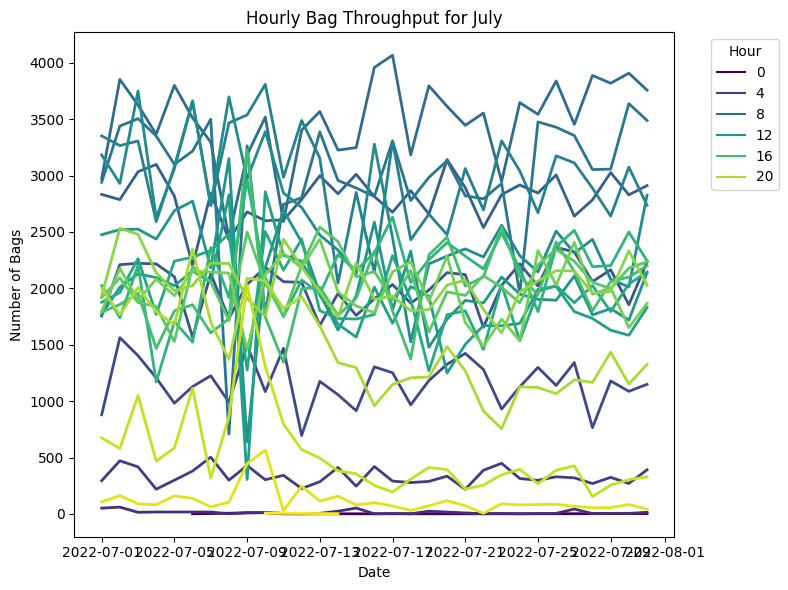

In [52]:
# Group by day and hour, count the number of bags in each group
hourly_counts = data.groupby(['day', 'hour']).size().reset_index(name='count')

plt.figure(figsize=(8, 6))
sns.lineplot(data=hourly_counts, x='day', y='count', hue='hour', palette='viridis', lw=2)
plt.title('Hourly Bag Throughput for July')
plt.xlabel('Date')
plt.ylabel('Number of Bags')
plt.legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Daily Trends:

- There is a noticeable cyclical pattern in the bag throughput across the days, indicative of recurring peaks and valleys.
- This suggests a potential weekly pattern, possibly with certain days experiencing higher bag volumes than others.

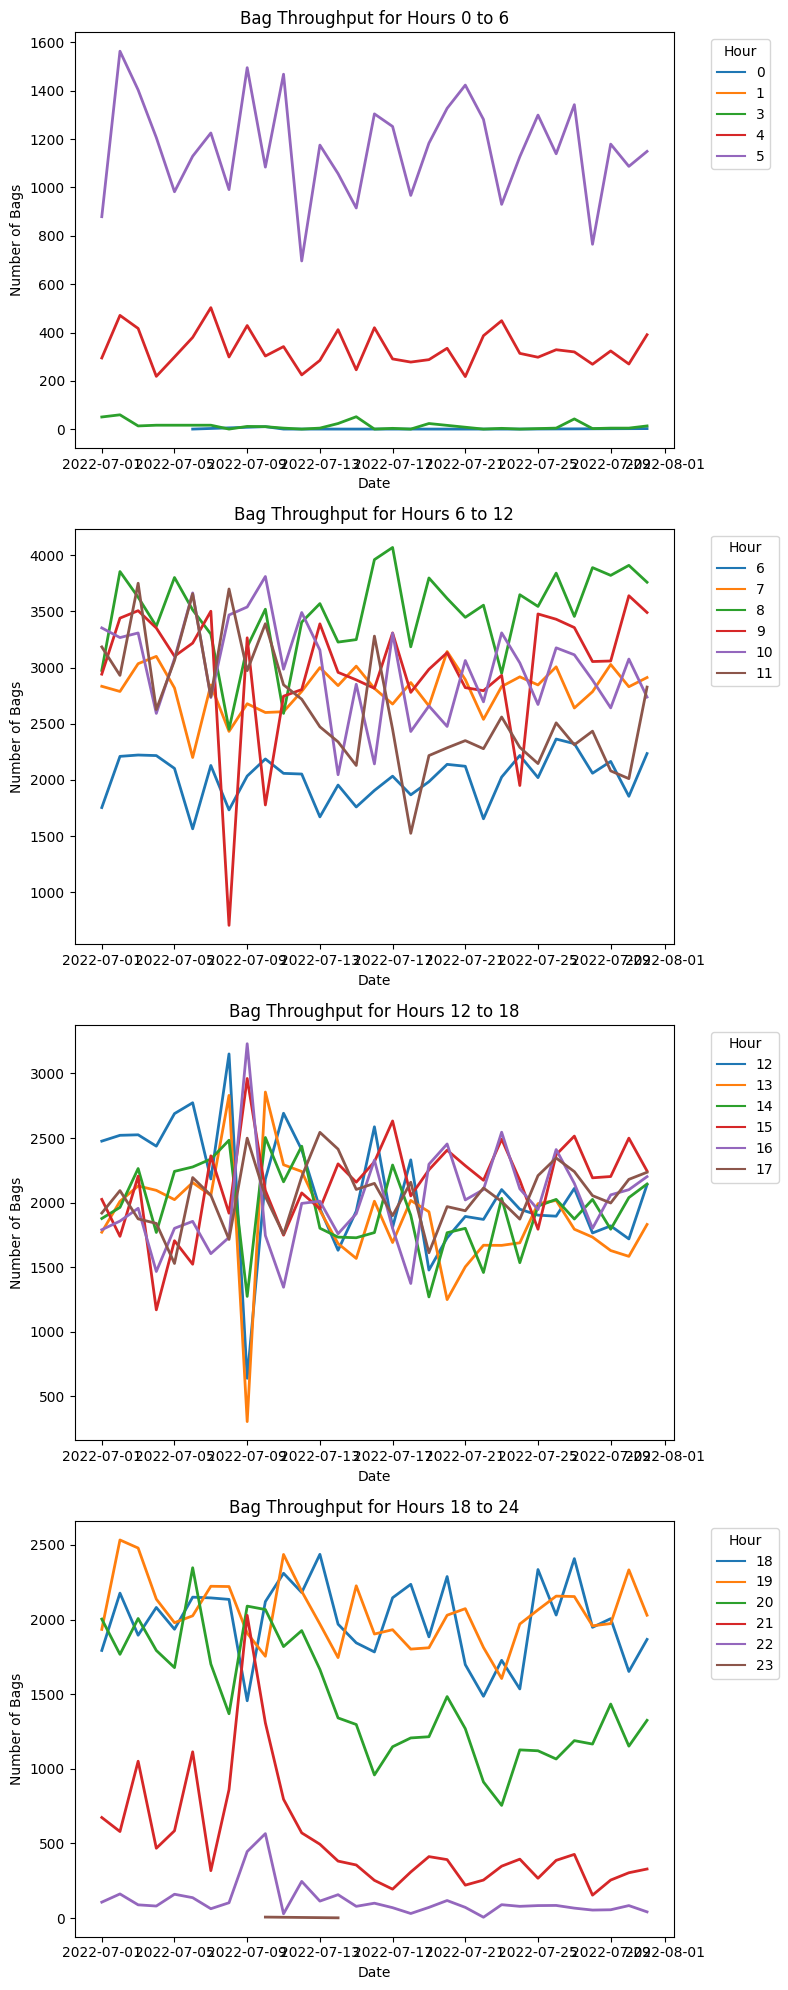

In [53]:
# Segmented plots for different hour intervals
hour_segments = [(0, 6), (6, 12), (12, 18), (18, 24)]
fig, axes = plt.subplots(4, 1, figsize=(8, 20))

for i, (start, end) in enumerate(hour_segments):
    subset = hourly_counts[(hourly_counts['hour'] >= start) & (hourly_counts['hour'] < end)]
    sns.lineplot(data=subset, x='day', y='count', hue='hour', palette='tab10', lw=2, ax=axes[i])
    axes[i].set_title(f'Bag Throughput for Hours {start} to {end}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Number of Bags')
    axes[i].legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Hourly Trends:

- The early morning hours (approximately 0 to 5) show the lowest bag throughput, which is expected as this is typically off-peak for airports.
- There is a noticeable increase in throughput starting around the 6 AM mark, peaking in the late morning to early afternoon hours.
- The afternoon and evening hours also see a consistent level of bag throughput, with some minor fluctuations.

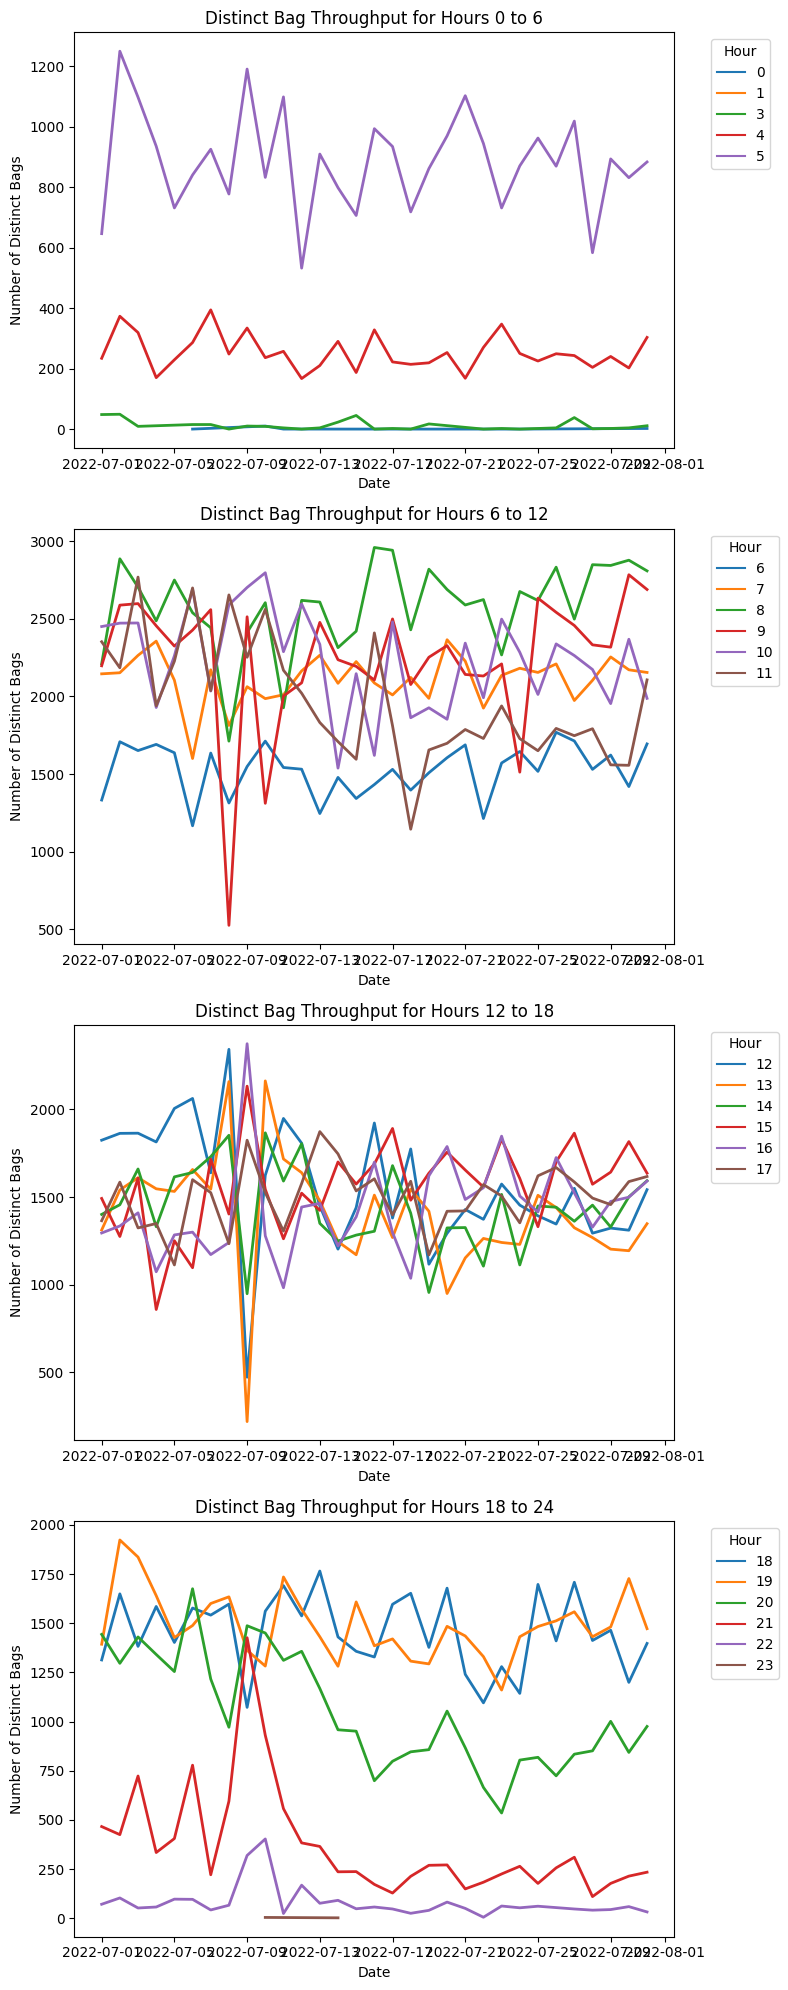

In [70]:
# Group by day and hour, then count the distinct bags using 'bag_licence_plate'
hourly_counts_distinct = data.groupby(['day', 'hour'])['bag_licence_plate'].nunique().reset_index(name='count')

# Define the hour segments
hour_segments = [(0, 6), (6, 12), (12, 18), (18, 24)]

# Segmented plots for different hour intervals using distinct bag counts
fig, axes = plt.subplots(4, 1, figsize=(8, 20))

for i, (start, end) in enumerate(hour_segments):
    subset = hourly_counts_distinct[(hourly_counts_distinct['hour'] >= start) & (hourly_counts_distinct['hour'] < end)]
    sns.lineplot(data=subset, x='day', y='count', hue='hour', palette='tab10', lw=2, ax=axes[i])
    axes[i].set_title(f'Distinct Bag Throughput for Hours {start} to {end}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Number of Distinct Bags')
    axes[i].legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

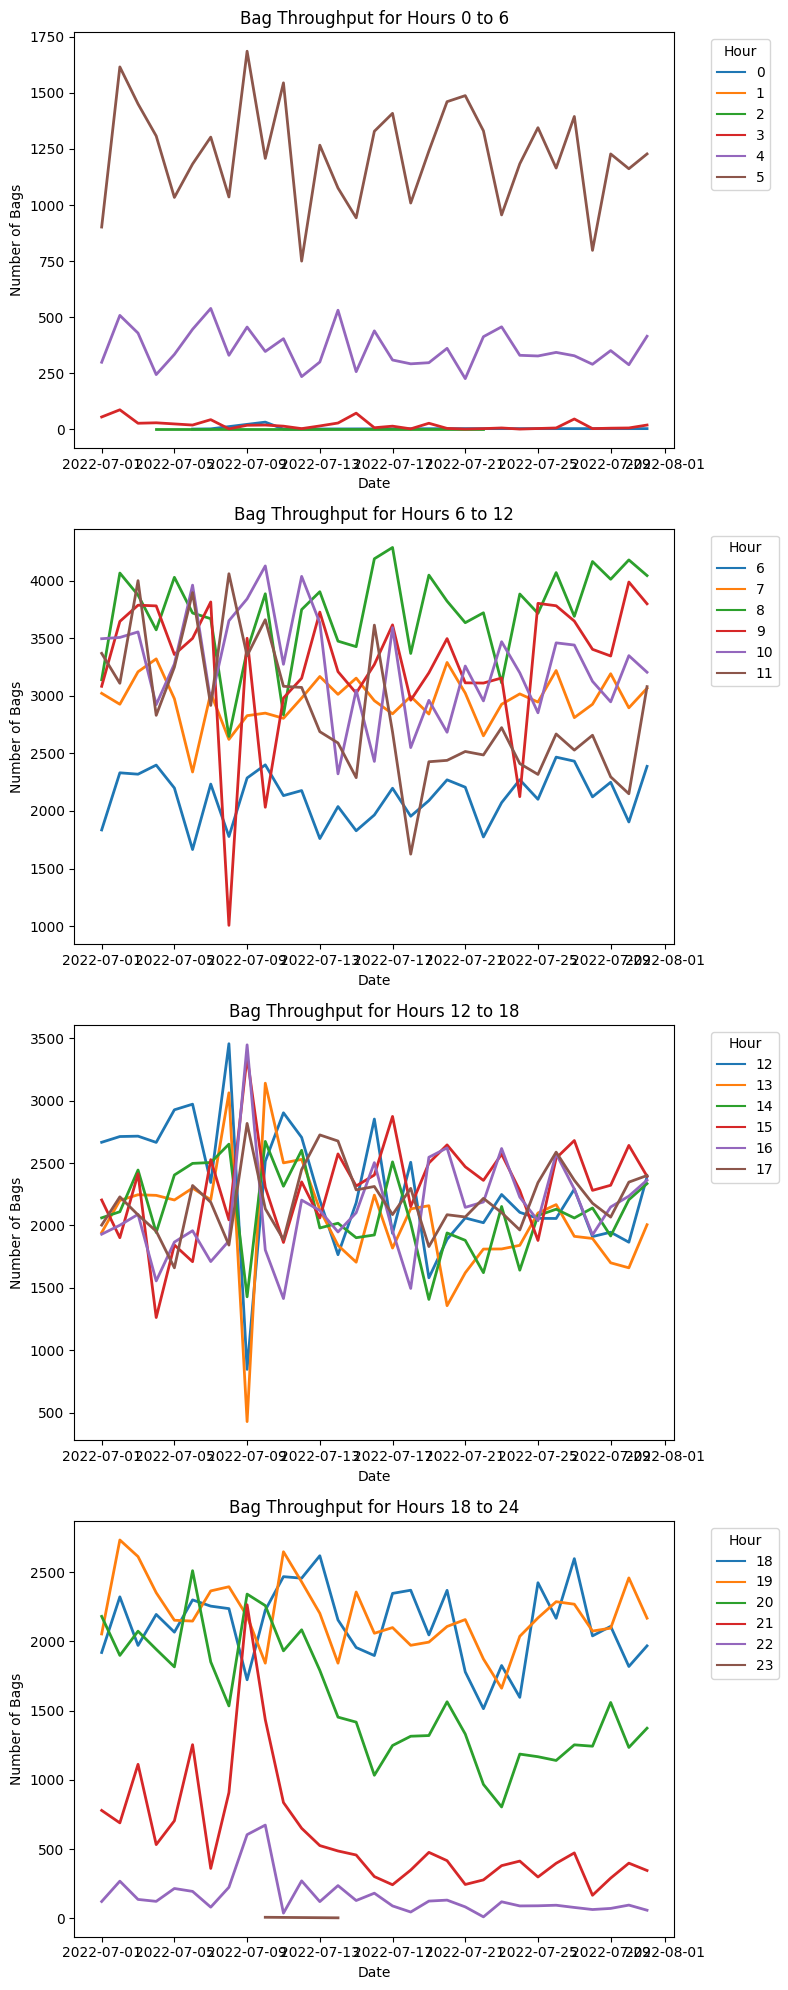

In [72]:
# Convert the 'bag_scan_timestamp' column to datetime format
data_1['bag_scan_timestamp'] = pd.to_datetime(data_1['bag_scan_timestamp'])

# Create columns for day, hour, and 15-minute intervals
data_1['day'] = data_1['bag_scan_timestamp'].dt.date
data_1['hour'] = data_1['bag_scan_timestamp'].dt.hour

# Group by day and hour, count the number of bags in each group
hourly_counts = data_1.groupby(['day', 'hour']).size().reset_index(name='count')

# Segmented plots for different hour intervals
hour_segments = [(0, 6), (6, 12), (12, 18), (18, 24)]
fig, axes = plt.subplots(4, 1, figsize=(8, 20))

for i, (start, end) in enumerate(hour_segments):
    subset = hourly_counts[(hourly_counts['hour'] >= start) & (hourly_counts['hour'] < end)]
    sns.lineplot(data=subset, x='day', y='count', hue='hour', palette='tab10', lw=2, ax=axes[i])
    axes[i].set_title(f'Bag Throughput for Hours {start} to {end}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Number of Bags')
    axes[i].legend(title='Hour', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### 2. Heatmap for the demand

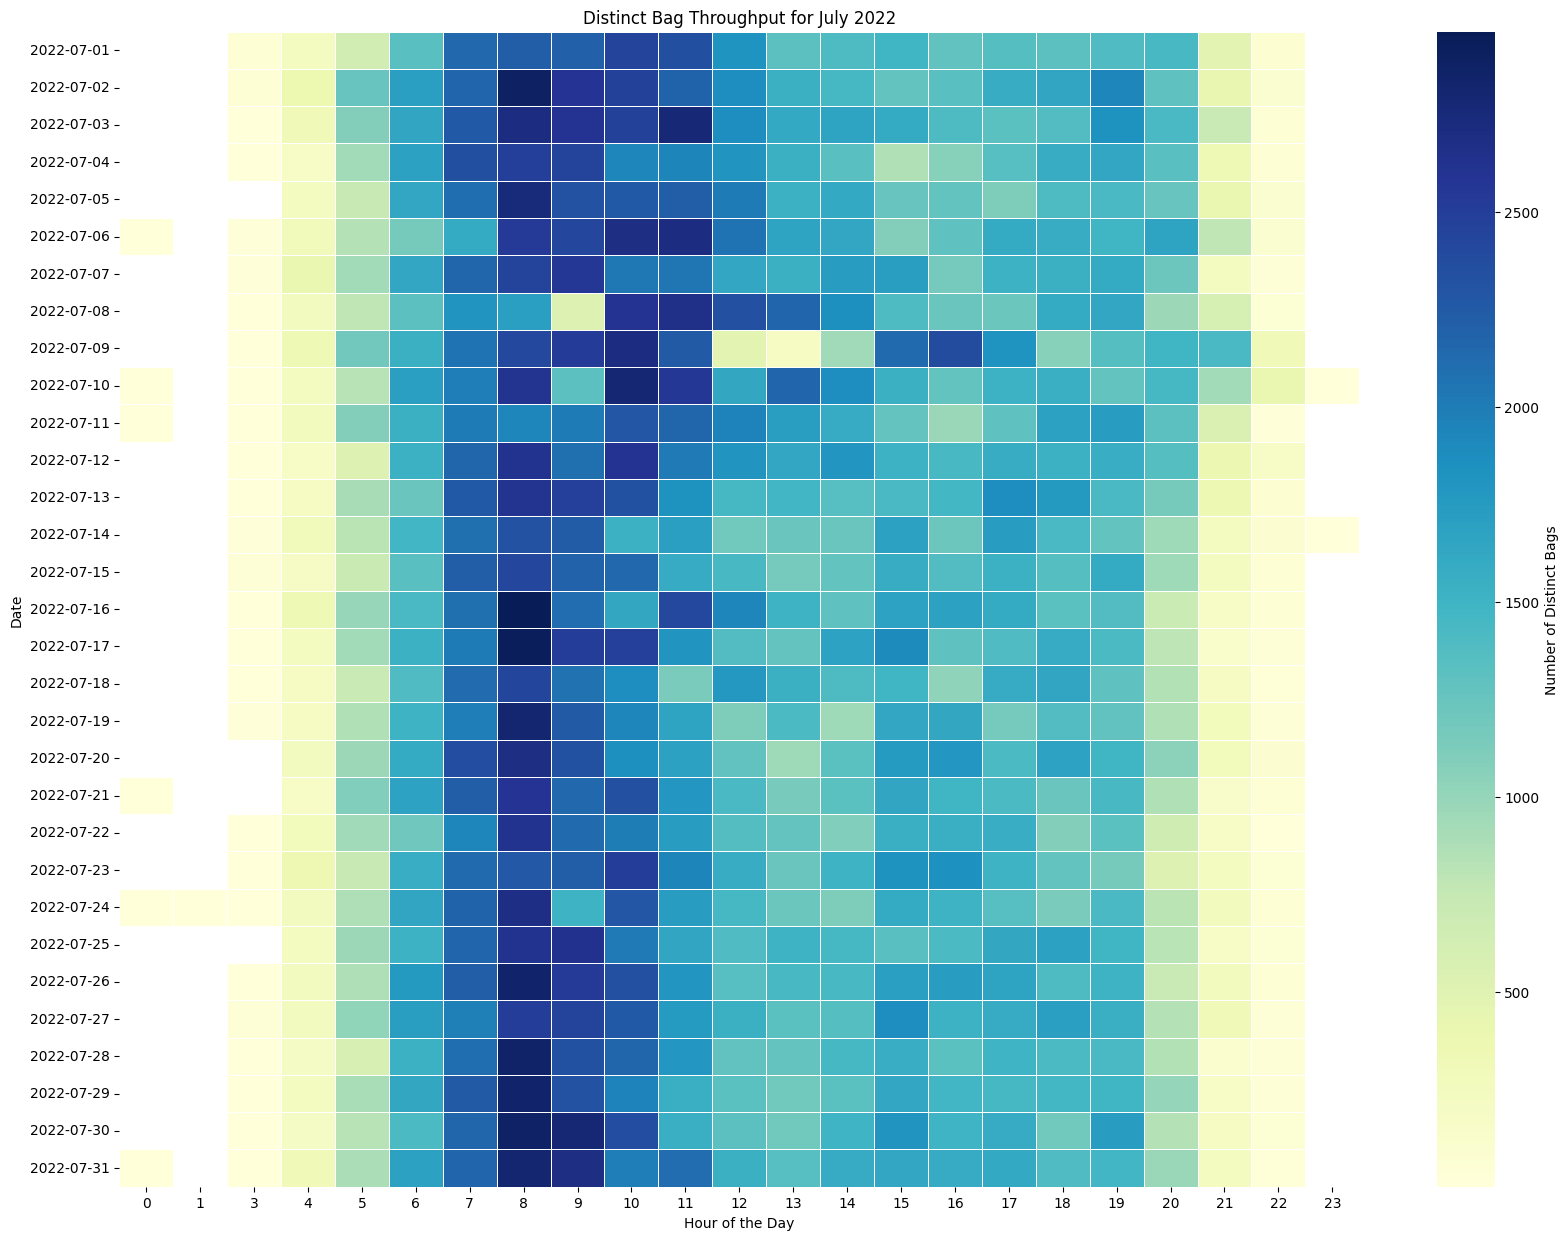

In [74]:
# Group by day and hour, then count the distinct bags using 'bag_licence_plate'
heatmap_data = data.groupby(['day', 'hour'])['bag_licence_plate'].nunique().reset_index(name='count')

# Pivot the data for the heatmap
heatmap_pivot = heatmap_data.pivot('day', 'hour', 'count')

# Plotting the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(heatmap_pivot, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Number of Distinct Bags'})
plt.title('Distinct Bag Throughput for July 2022')
plt.xlabel('Hour of the Day')
plt.ylabel('Date')
plt.show()

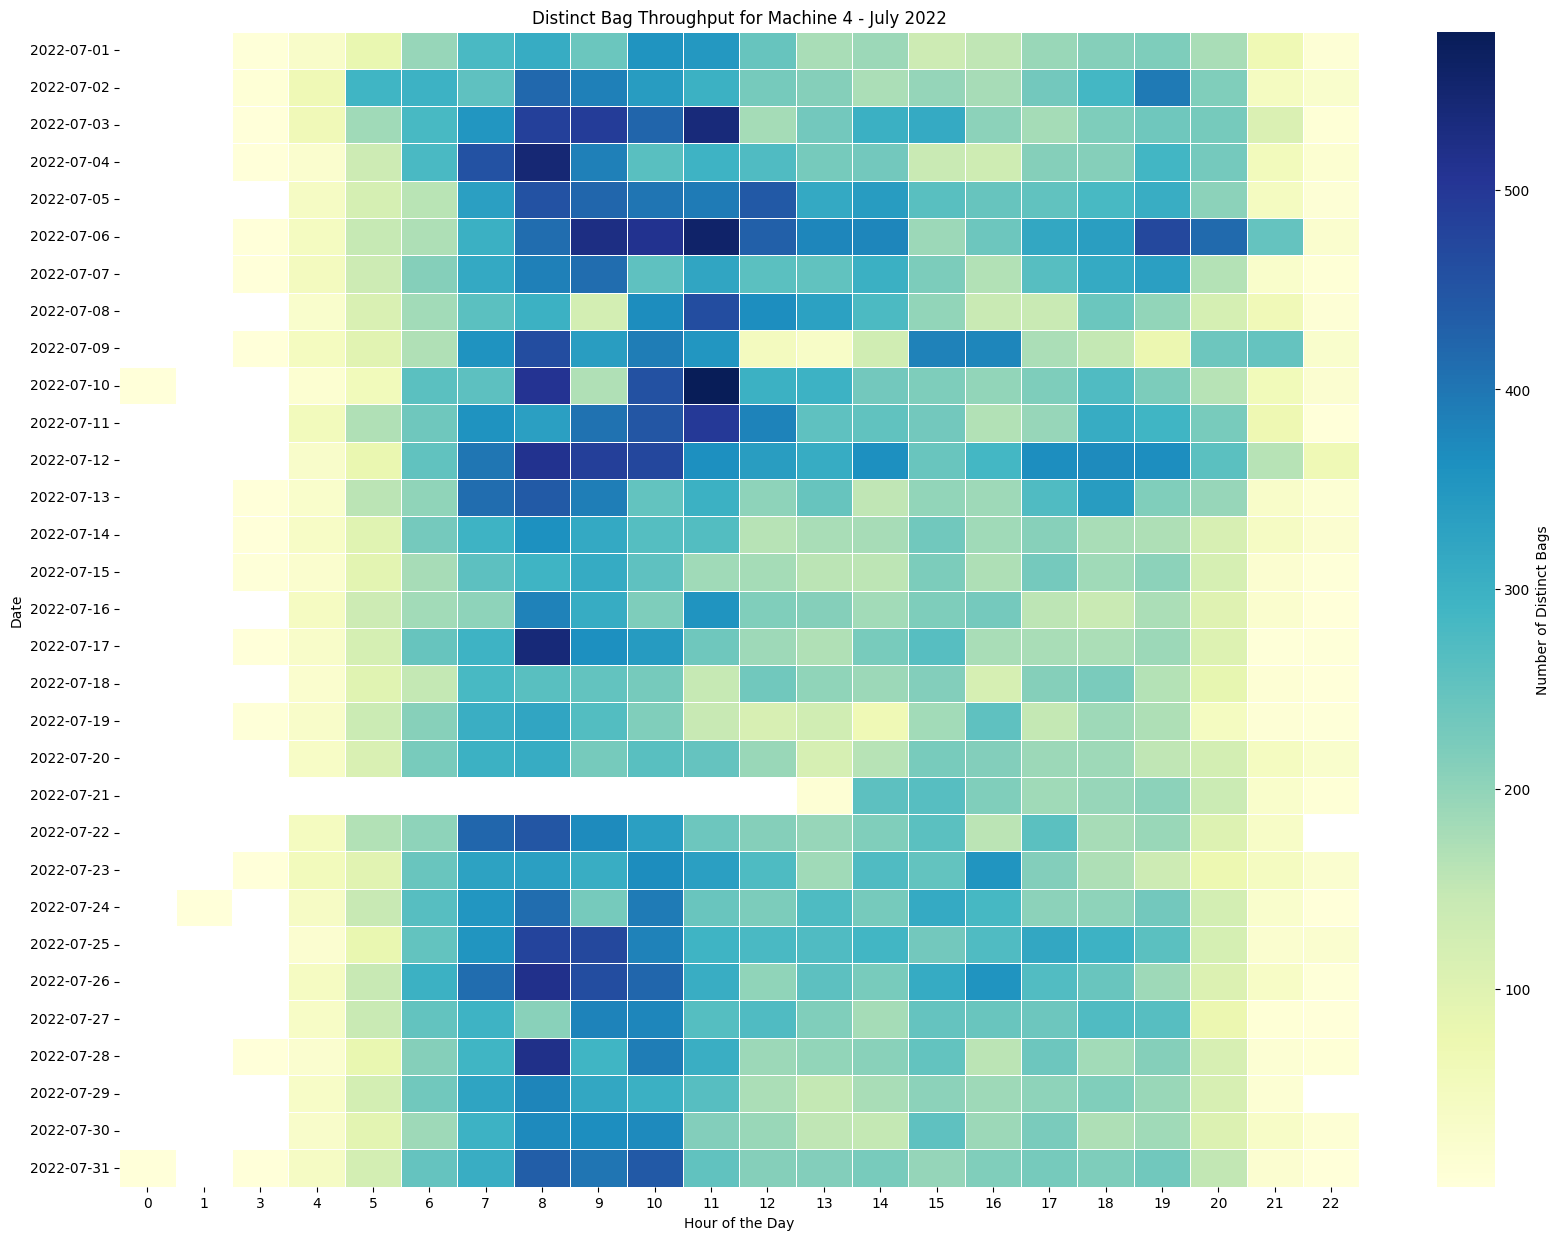

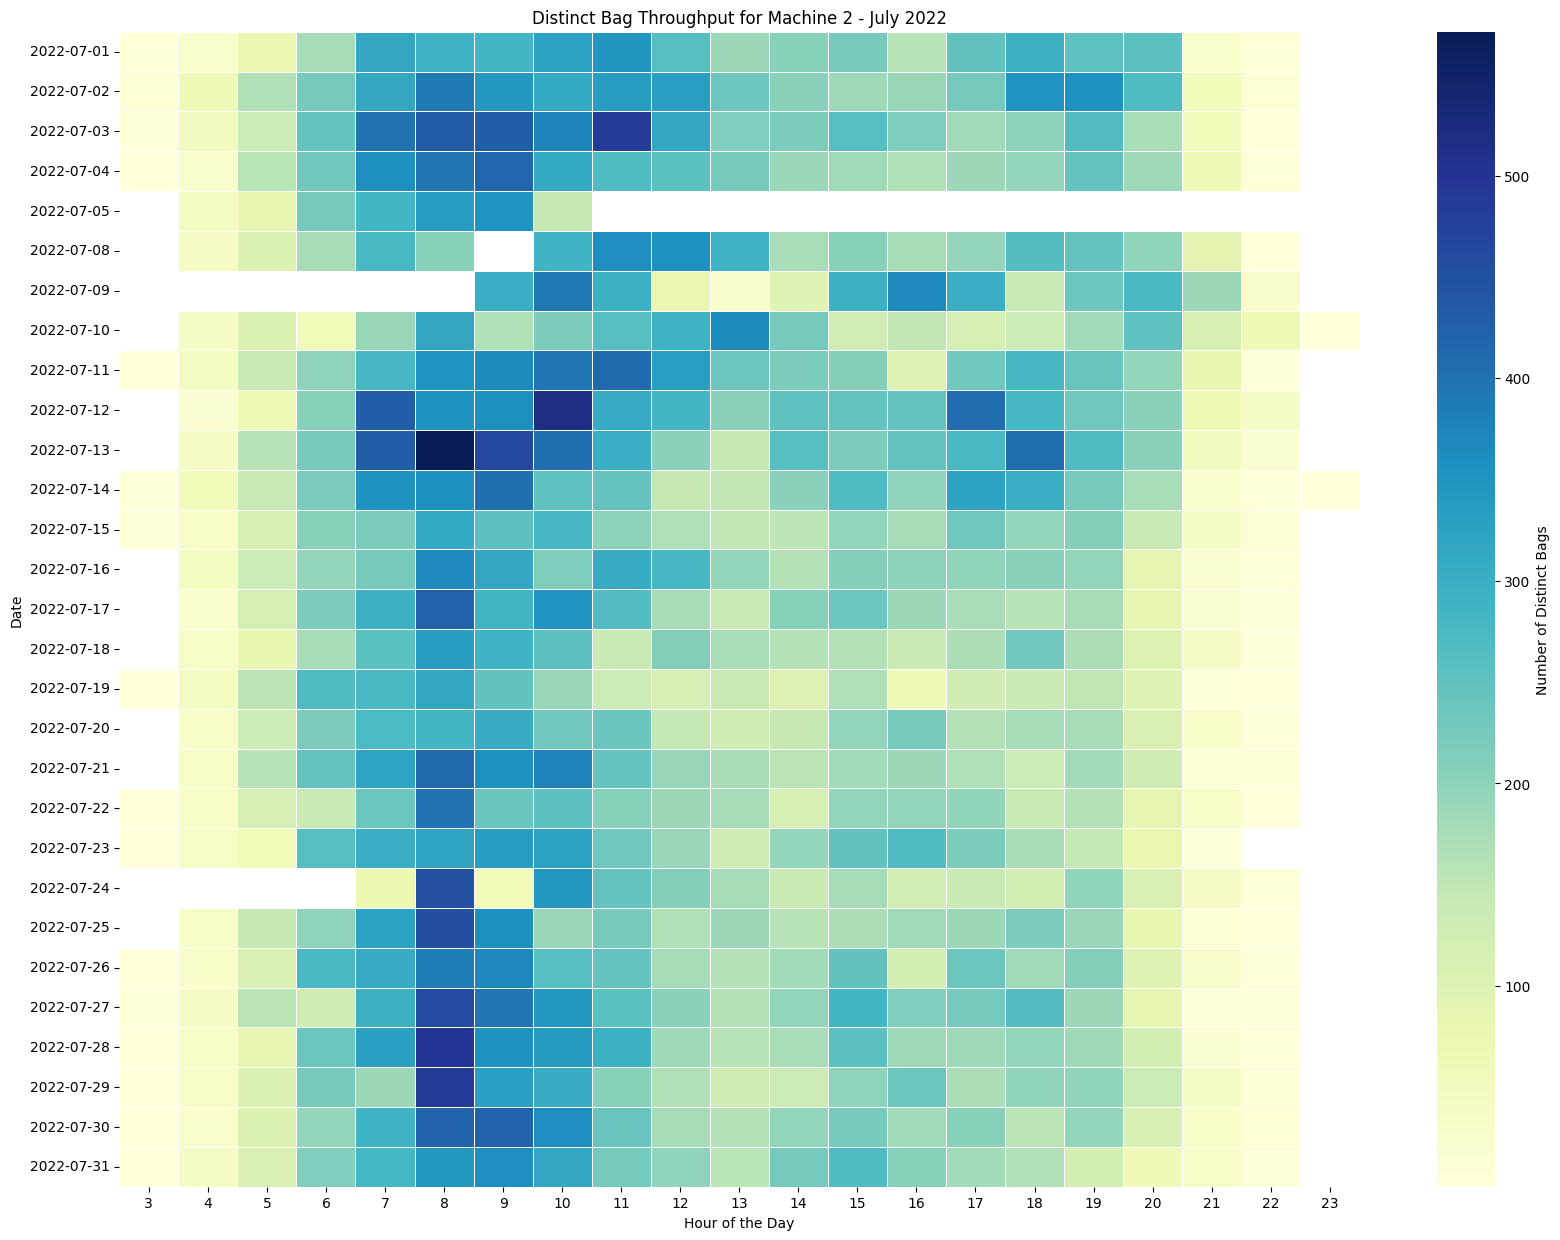

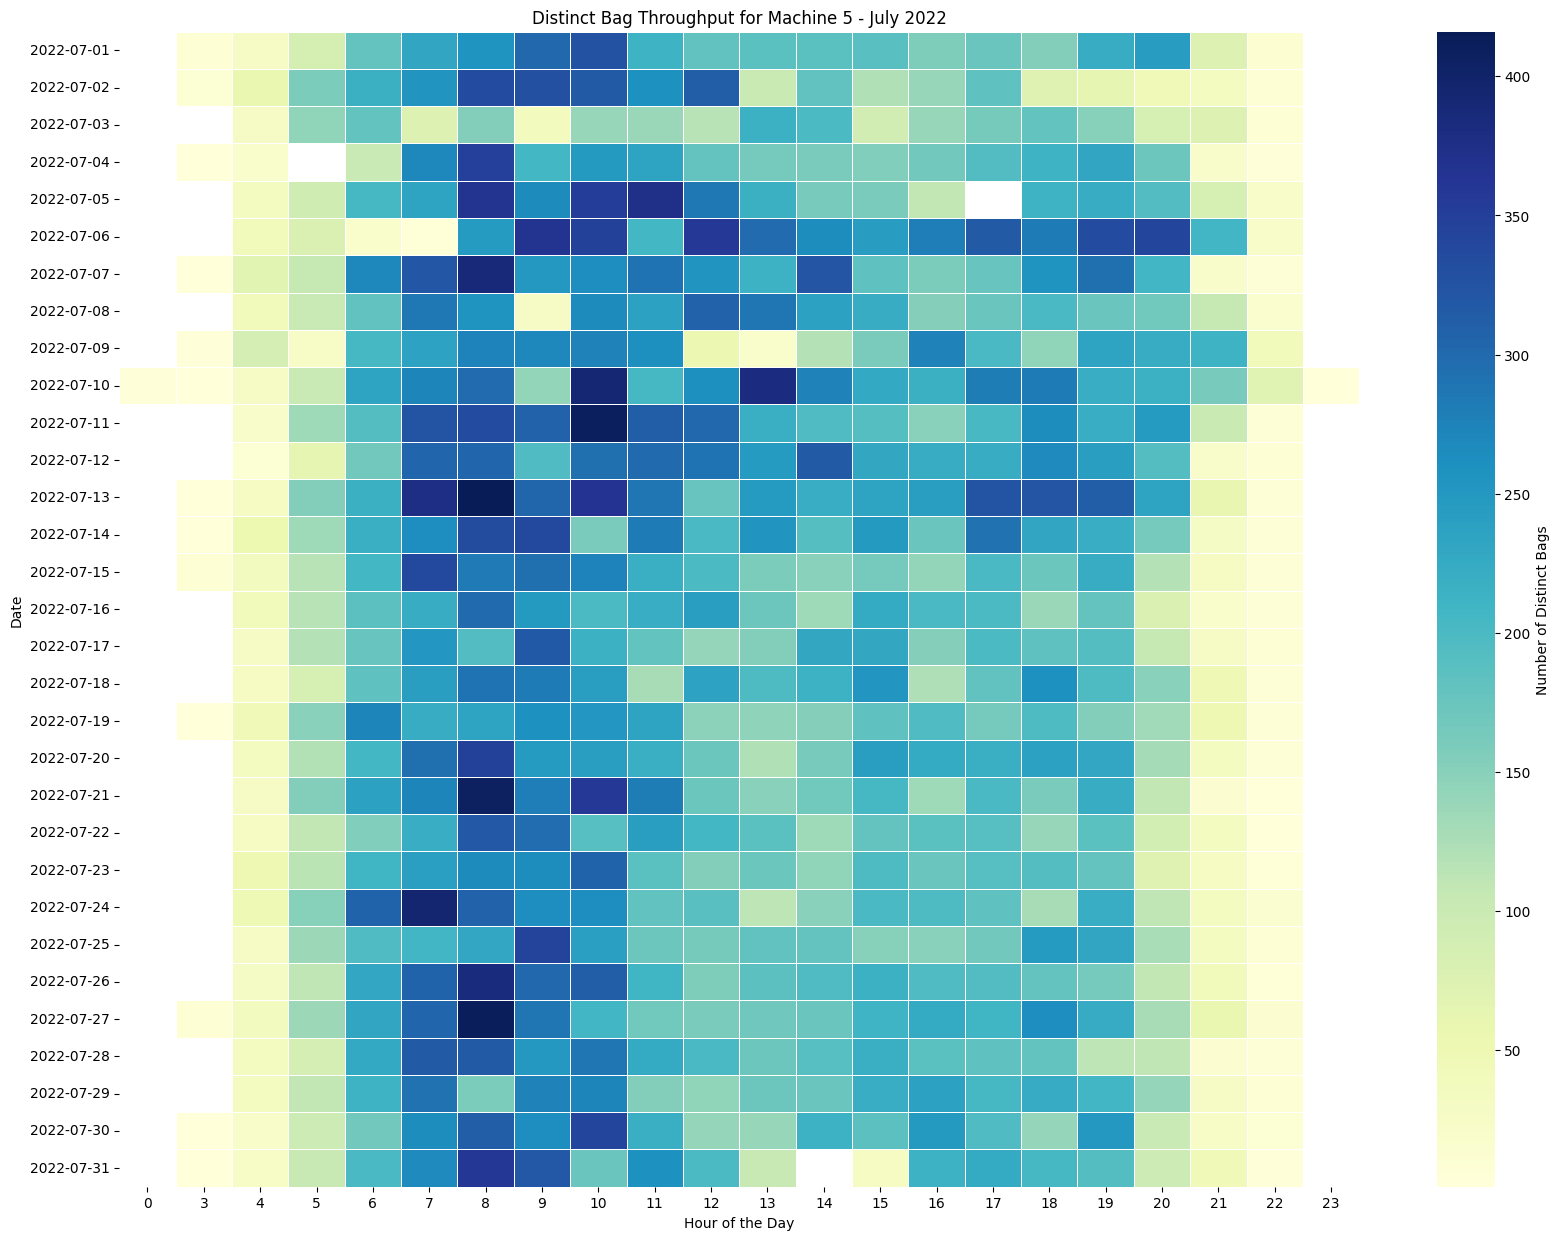

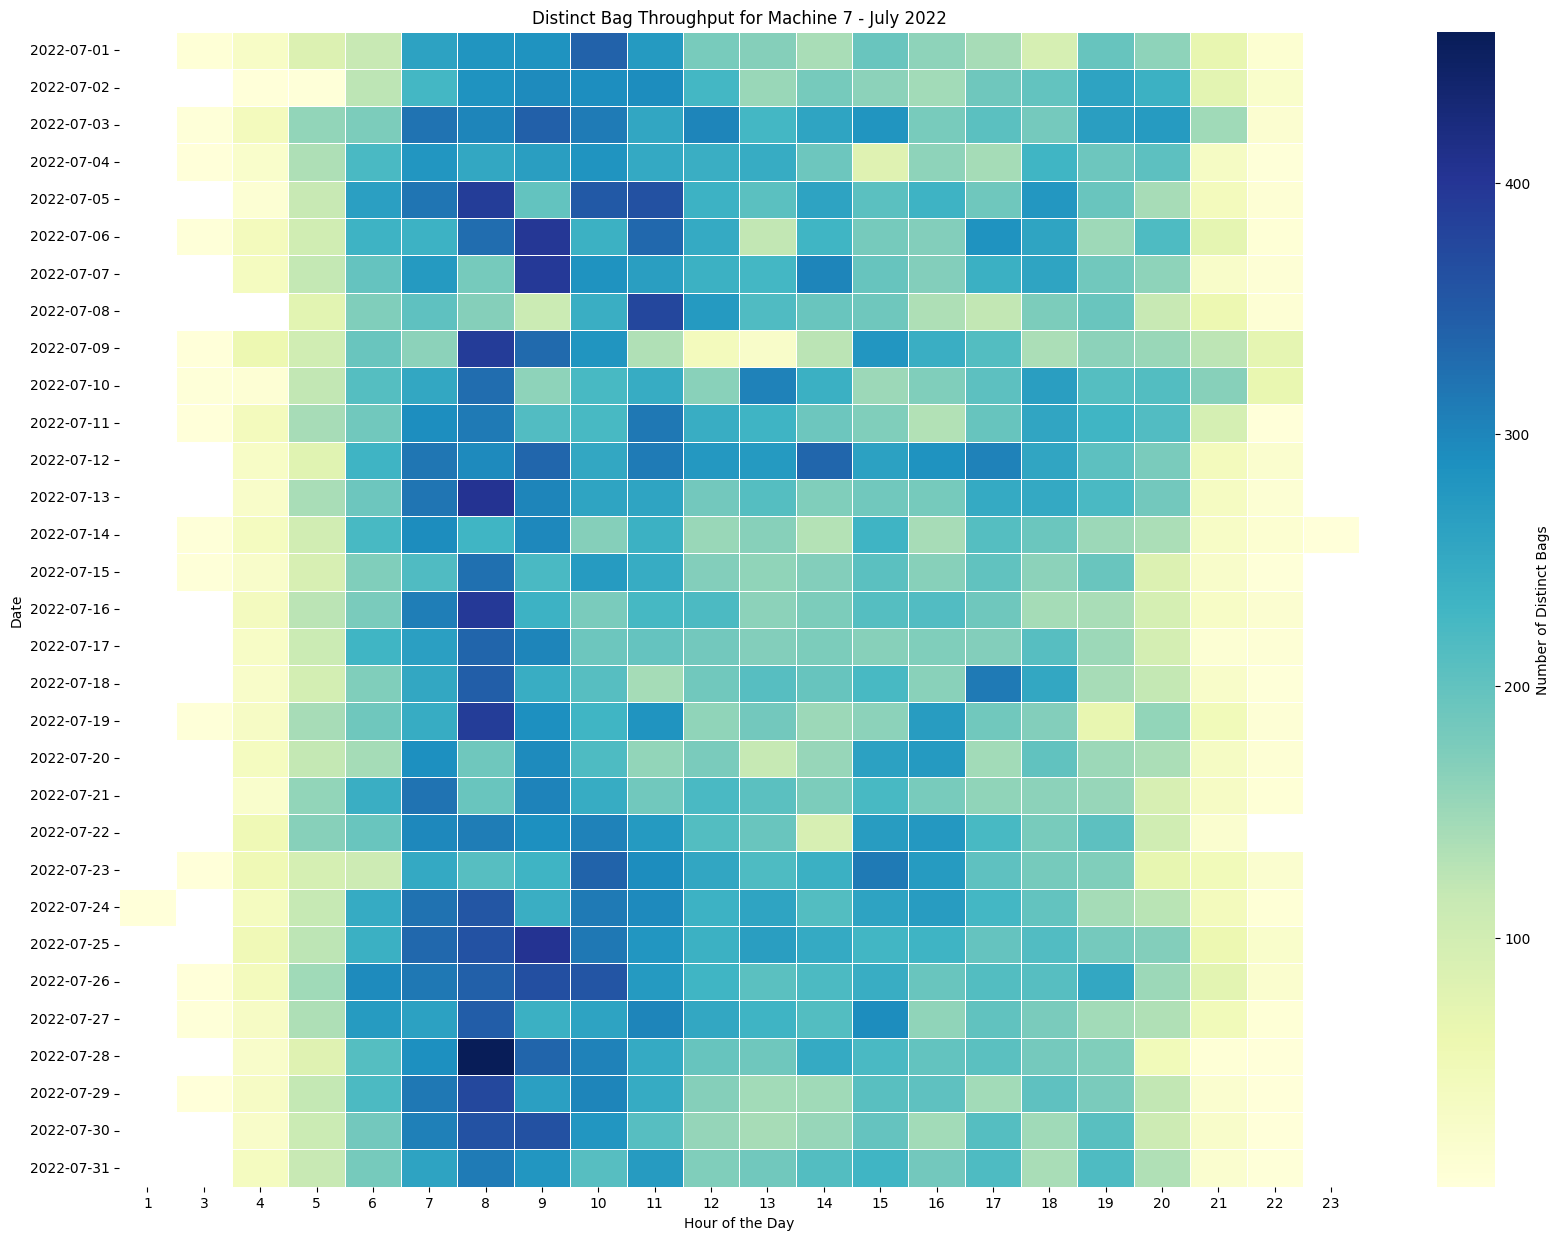

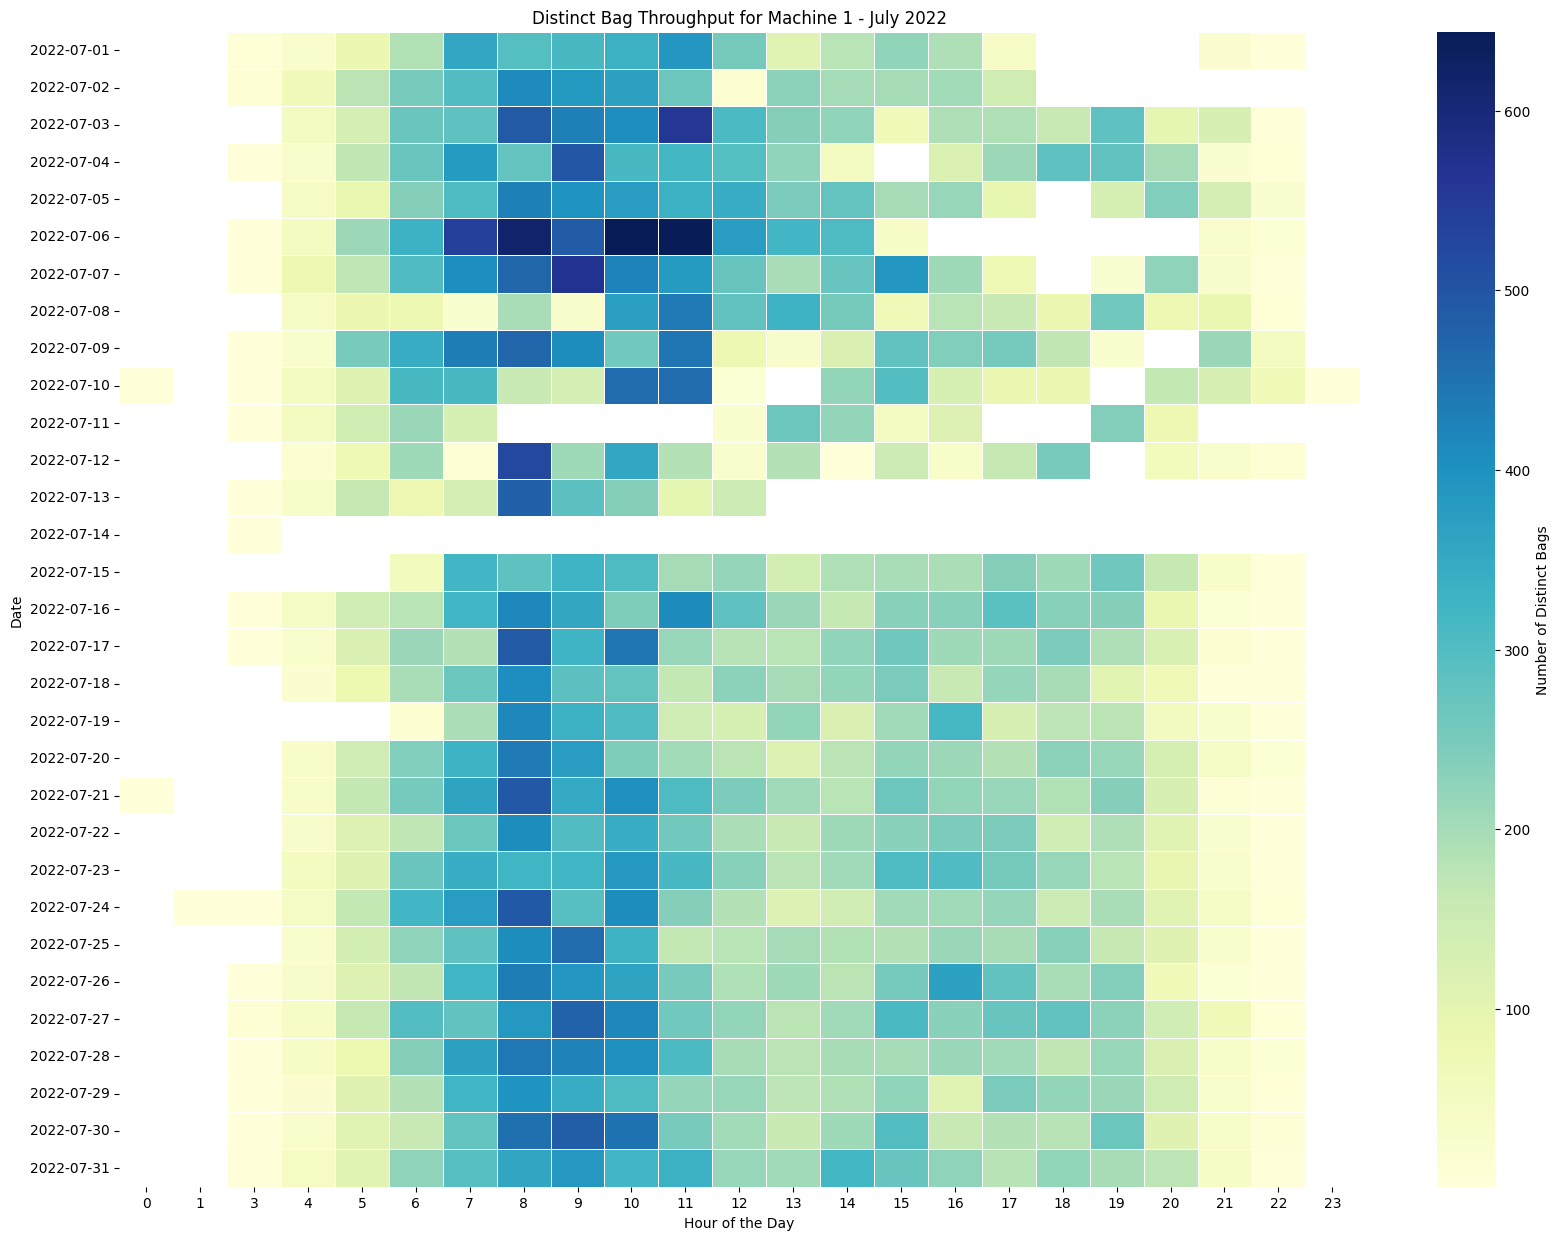

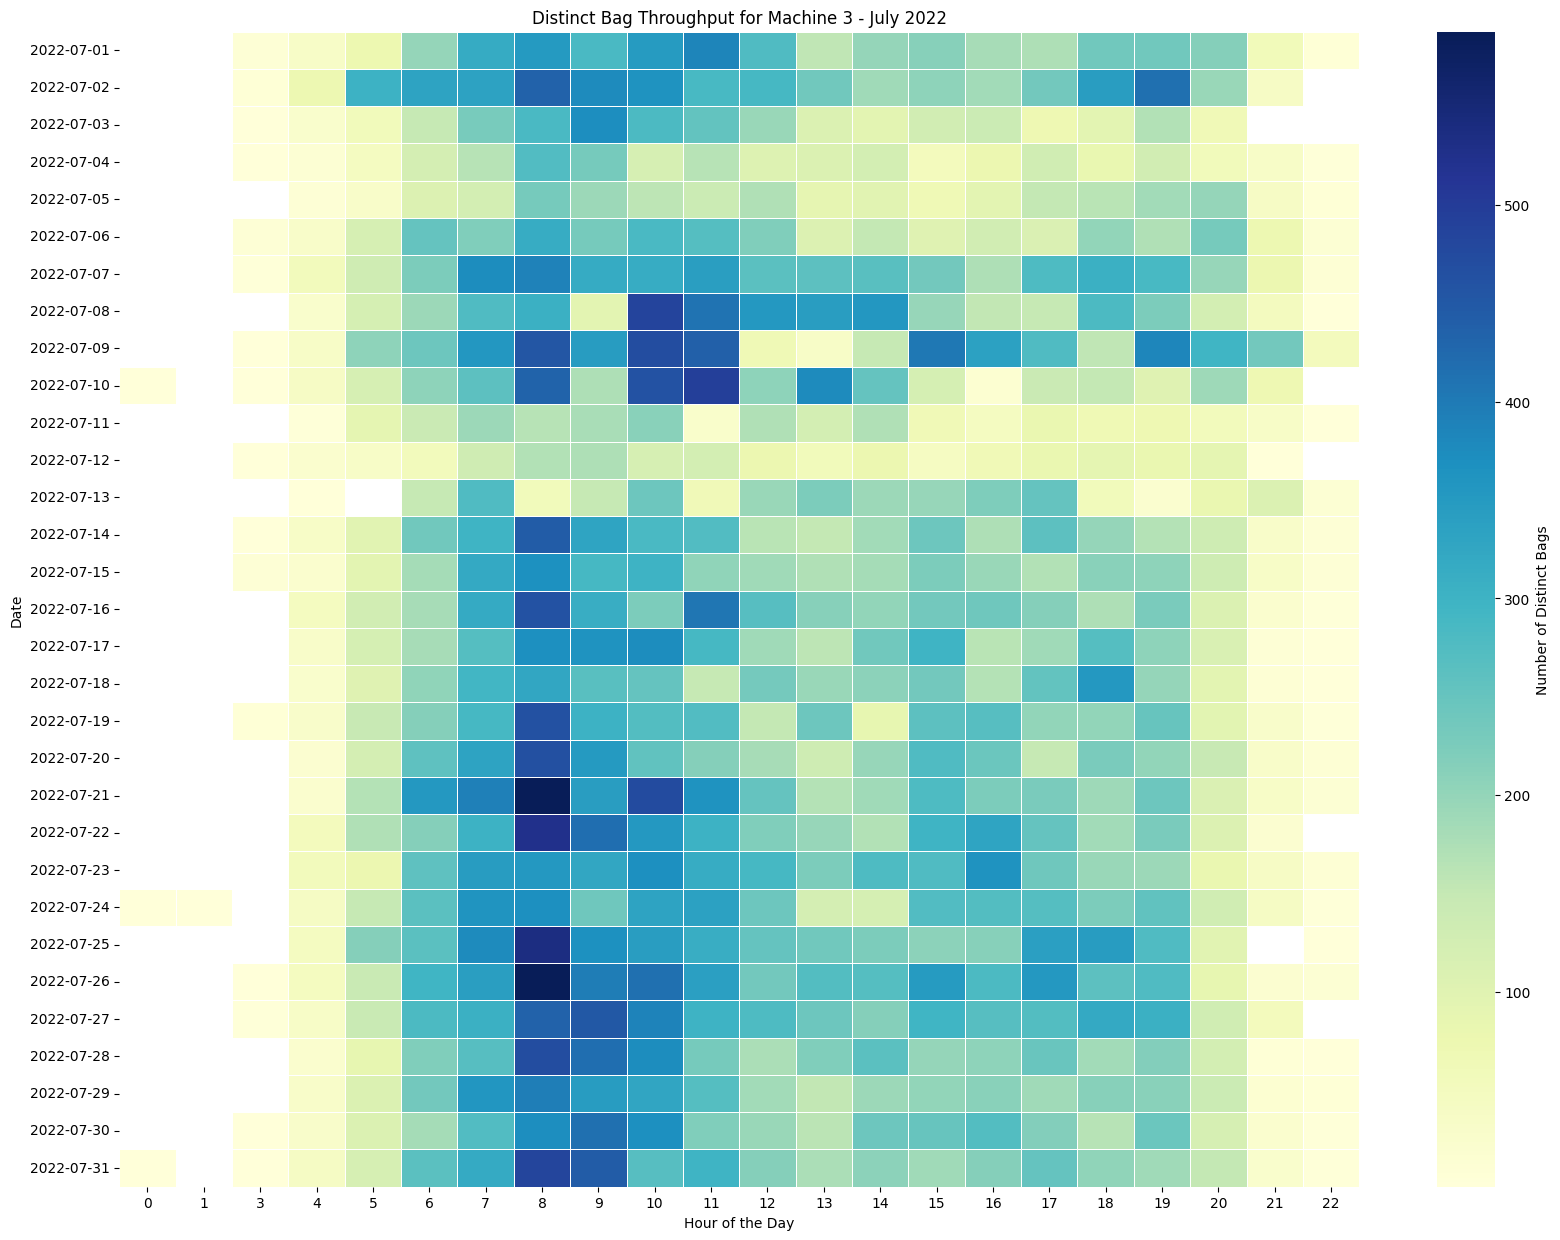

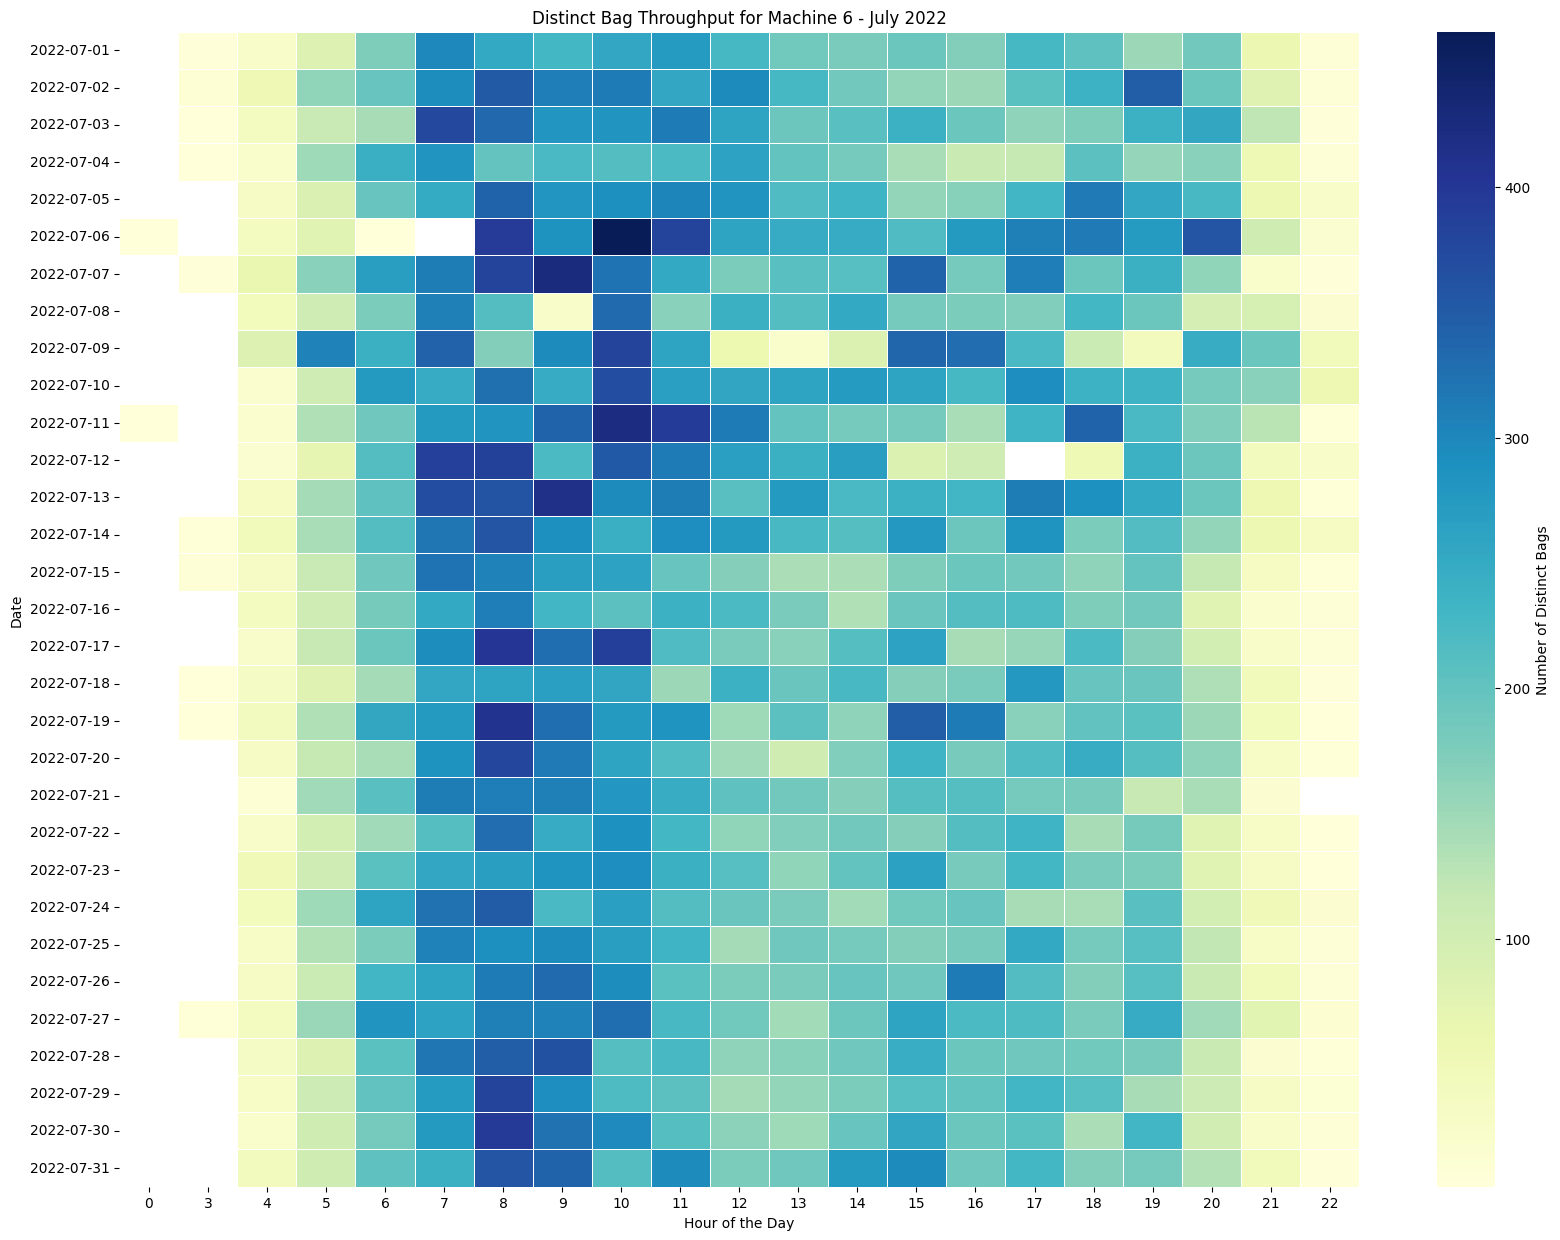

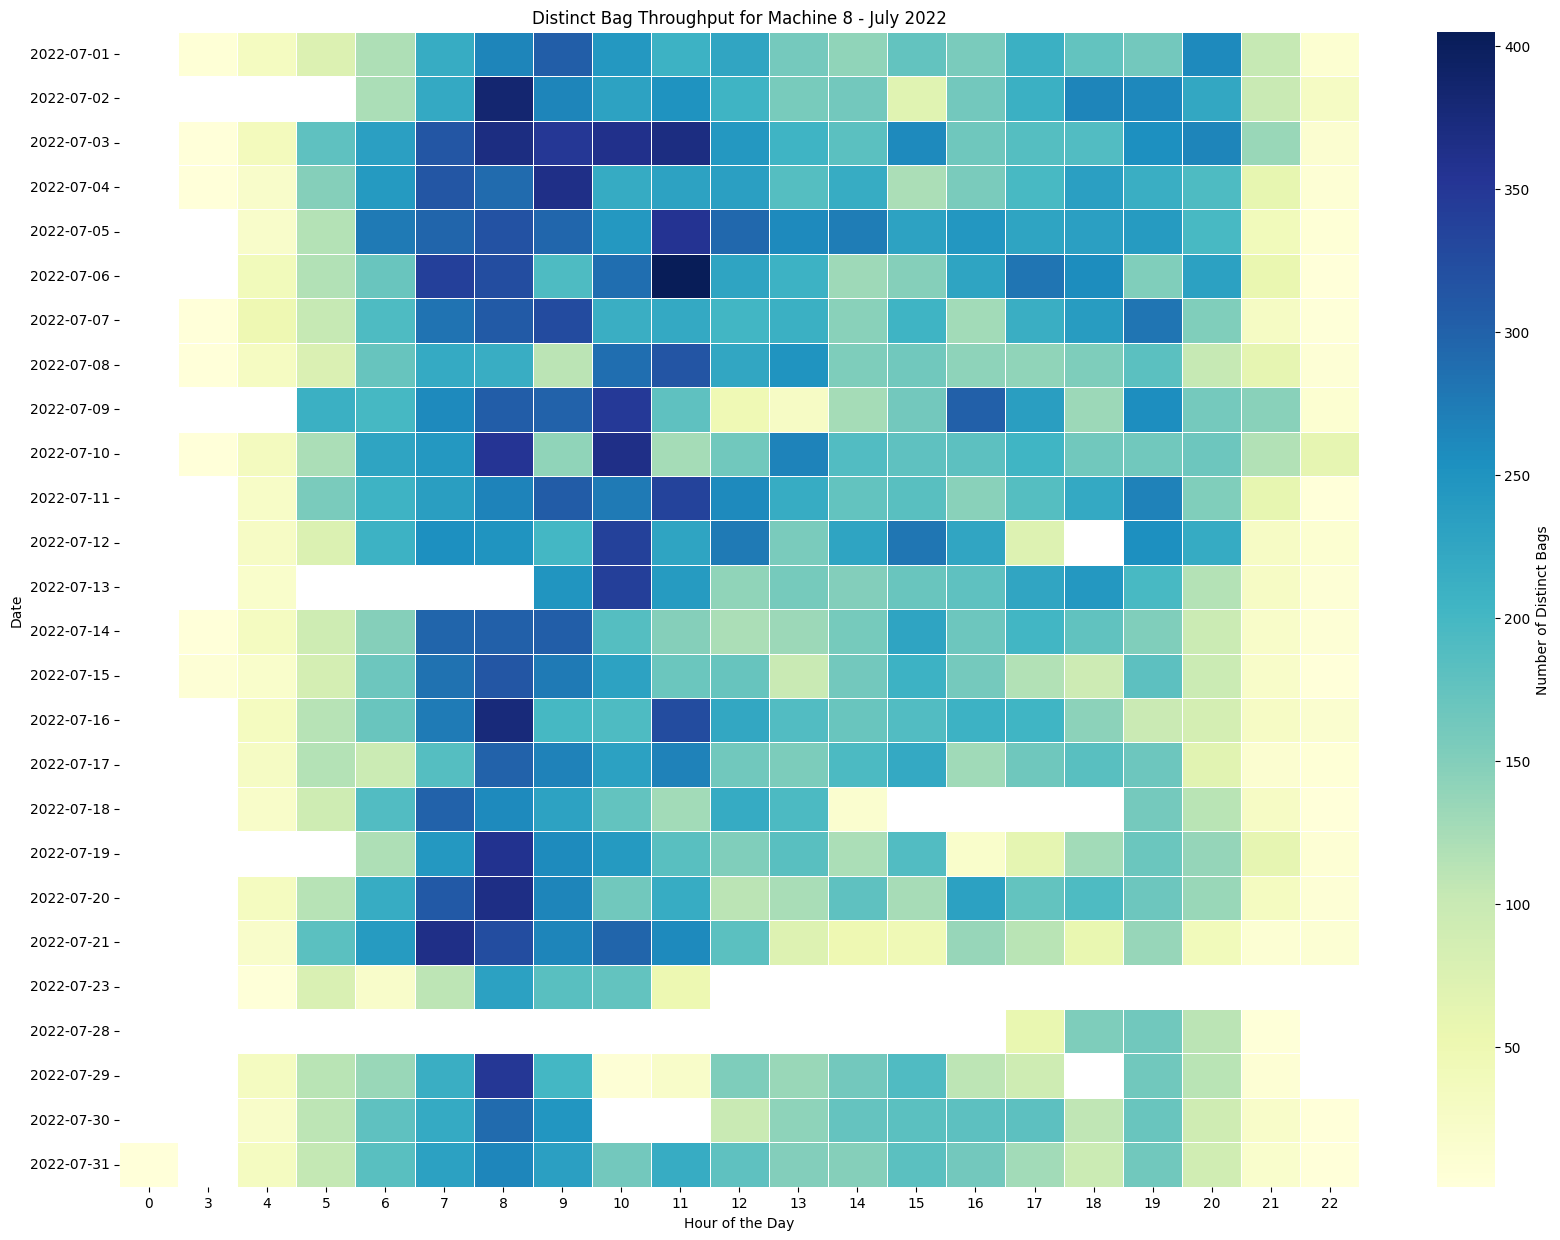

In [80]:
# Create a function to plot heatmap for each machine
def plot_machine_heatmap(machine_data, machine_name):
    # Pivot the data for the heatmap
    heatmap_pivot = machine_data.pivot('day', 'hour', 'count')
    
    # Plotting the heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(heatmap_pivot, cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Number of Distinct Bags'})
    plt.title(f'Distinct Bag Throughput for {machine_name} - July 2022')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Date')
    plt.show()

# Filter data for each machine and plot its heatmap
machines = data['scan_machine_id'].unique()

for machine in machines:
    machine_data = data[data['scan_machine_id'] == machine]
    machine_data = machine_data.groupby(['day', 'hour'])['bag_licence_plate'].nunique().reset_index(name='count')
    plot_machine_heatmap(machine_data, machine)

### 3. Peak Day Analysis
Identify the peak day or time period within a specified date range, capturing the busiest period of activity.

C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\345117743.py:12: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  mean_hourly_counts_data = data.groupby('hour')['bag_licence_plate'].nunique().mean(level=0).reset_index(name='Mean Count of Bags')


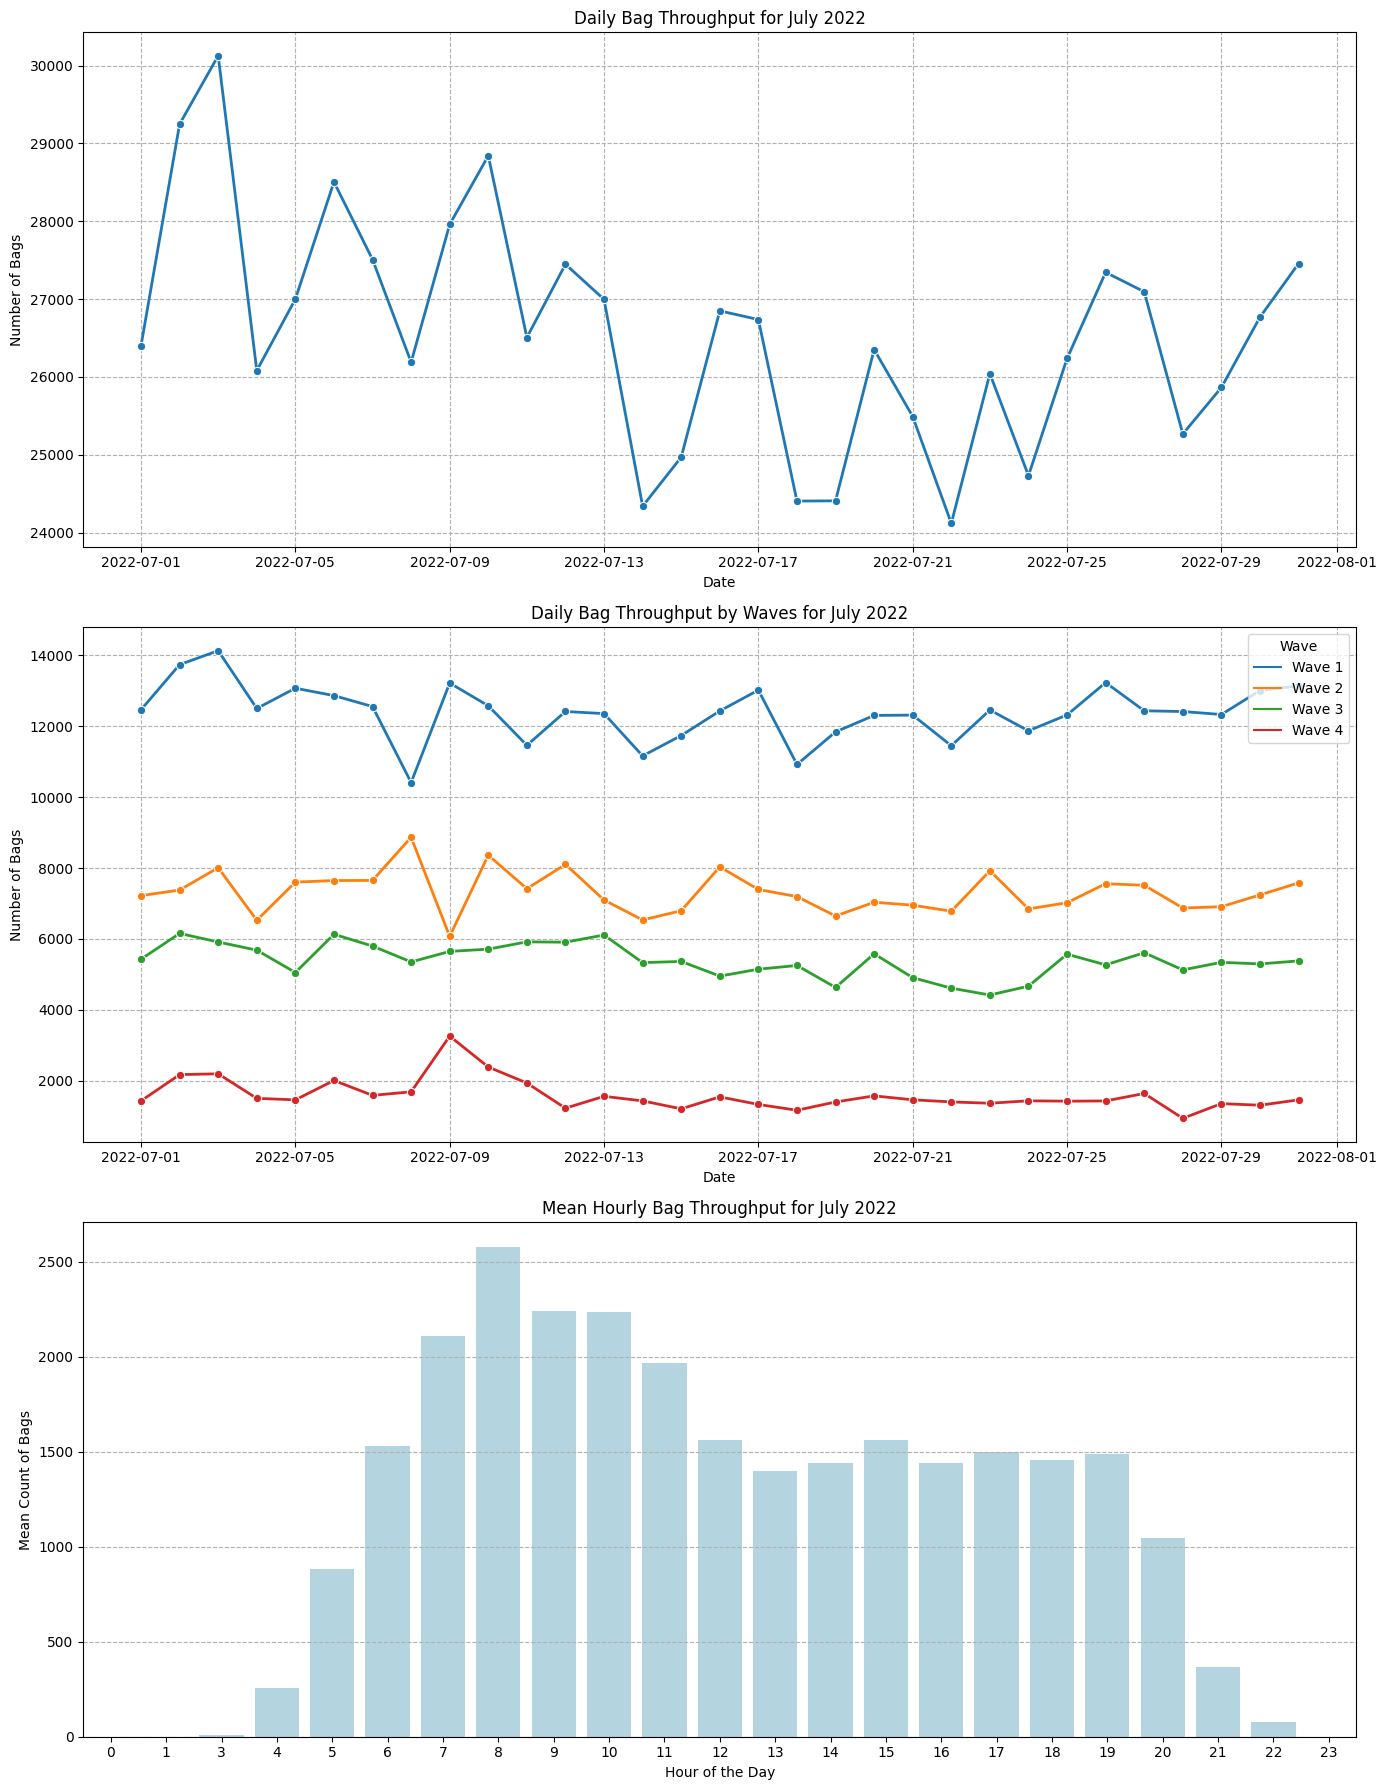

In [81]:
# Extract the hour from the timestamp and assign to waves for the original dataset (data)
data['hour'] = pd.to_datetime(data['bag_scan_timestamp']).dt.hour
data['wave'] = data['hour'].apply(get_wave)

# Group by day and count the distinct bags using 'bag_licence_plate' for the original dataset (data)
daily_counts_data = data.groupby('day')['bag_licence_plate'].nunique().reset_index(name='count')

# Group by day, wave, and then count the distinct bags using 'bag_licence_plate' for the original dataset (data)
daily_wave_counts_data = data.groupby(['day', 'wave'])['bag_licence_plate'].nunique().reset_index(name='count')

# Group by the hour and calculate the mean count of distinct bags for each hour across July for the original dataset (data)
mean_hourly_counts_data = data.groupby('hour')['bag_licence_plate'].nunique().mean(level=0).reset_index(name='Mean Count of Bags')
mean_hourly_counts_data['Mean Count of Bags'] /= 31  # As July has 31 days

# Setting up the figure and axes for 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# 1. Plotting the distribution of daily bag throughput for the month of July on the first axes (top)
sns.lineplot(data=daily_counts_data, x='day', y='count', marker="o", lw=2, ax=ax[0])
ax[0].set_title('Daily Bag Throughput for July 2022')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Bags')
ax[0].grid(True, which="both", ls="--")

# 2. Plotting daily bag throughput by waves for July 2022 on the second axes (middle)
sns.lineplot(data=daily_wave_counts_data, x='day', y='count', hue='wave', marker="o", lw=2, ax=ax[1])
ax[1].set_title('Daily Bag Throughput by Waves for July 2022')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Bags')
ax[1].grid(True, which="both", ls="--")
ax[1].legend(title='Wave')

# 3. Plotting the distribution of mean hourly bag throughput for July on the third axes (bottom)
sns.barplot(data=mean_hourly_counts_data, x='hour', y='Mean Count of Bags', color='lightblue', ax=ax[2])
ax[2].set_title('Mean Hourly Bag Throughput for July 2022')
ax[2].set_xlabel('Hour of the Day')
ax[2].set_ylabel('Mean Count of Bags')
ax[2].grid(axis='y', which="both", ls="--")

# Adjust the layout
plt.tight_layout()
plt.show()

In [82]:
# Finding the day with the highest number of bags processed for the original data
peak_day_data = daily_counts_data[daily_counts_data['count'] == daily_counts_data['count'].max()]
peak_day_data

day  count
2  2022-07-03  30127

July 3rd stands out as the day with the highest throughput (30127 bags).

The first half of July appears to be the busiest period, with a noticeable decline in activity during the latter half of the month.

In [83]:
# Finding the time (hour) with the highest number of bags processed for the original data
peak_hour_data = mean_hourly_counts_data[mean_hourly_counts_data['Mean Count of Bags'] == mean_hourly_counts_data['Mean Count of Bags'].max()]
peak_hour_data

hour  Mean Count of Bags
7     8         2578.935484

8 AM stands out as the hour  with the highest mean throughput (2579 bags).

The mid-morning to early afternoon (7 AM to 11 AM) appears to be the busiest period, with a noticeable decline in activity during the early morning and night hours.

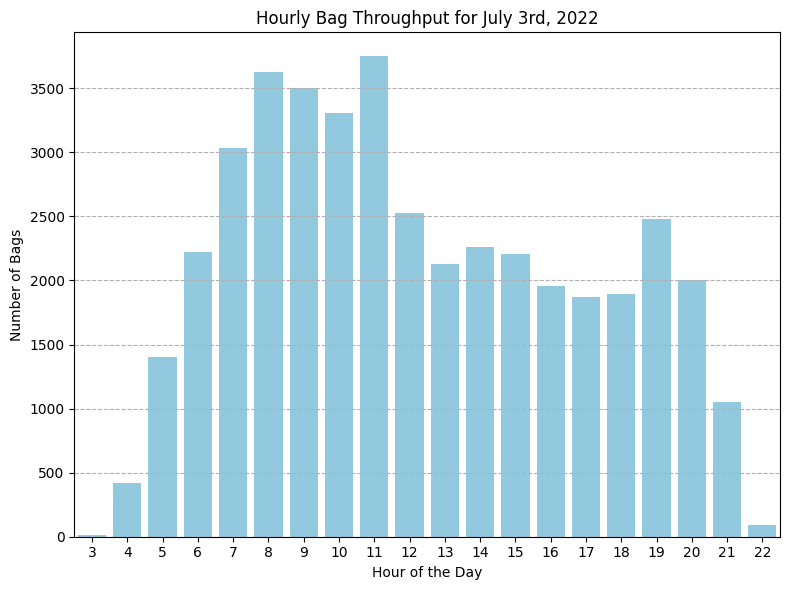

In [84]:
# Filter for data corresponding to July 3rd
july_3rd_data = data[data['day'] == pd.to_datetime('2022-07-03').date()]

# Group by hour to get the count of bags for each hour on July 3rd
hourly_counts_july_3rd = july_3rd_data.groupby(july_3rd_data['hour']).size().reset_index(name='count')
hourly_counts_july_3rd.columns = ['Hour', 'Number of Bags']

# Plotting the distribution of hourly bag counts for July 3rd
plt.figure(figsize=(8, 6))
sns.barplot(data=hourly_counts_july_3rd, x='Hour', y='Number of Bags', color='skyblue')
plt.title('Hourly Bag Throughput for July 3rd, 2022')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Bags')
plt.grid(axis='y', which="both", ls="--")
plt.tight_layout()
plt.show()

In the busy day (July 3rd), 11 AM stands out as the hour  with the highest throughput.

The mid-morning to early afternoon (7 AM to 11 AM) appears to be the busiest period, with a noticeable decline in activity during the early morning and night hours.



### 4. Distribution Analysis
Evaluate whether the system demonstrates equitable distribution of bags across machines and clusters, ensuring an even allocation.

In [88]:
# Calculate the distribution of bags across scan_machine_id and scan_machine_cluster
bag_counts = data.groupby(['scan_machine_cluster', 'scan_machine_id'])['bag_licence_plate'].nunique()
machine_distribution = bag_counts.reset_index(name='Number of Distinct Bags')
machine_distribution

scan_machine_cluster scan_machine_id  Number of Distinct Bags
0            Cluster A       Machine 1                   108498
1            Cluster A       Machine 2                   104096
2            Cluster A       Machine 5                   106799
3            Cluster A       Machine 6                   112550
4            Cluster B       Machine 3                   115178
5            Cluster B       Machine 4                   125640
6            Cluster B       Machine 7                   109546
7            Cluster B       Machine 8                    76379

In [89]:
# Calculate the distribution of bags across scan_machine_cluster
cluster_distribution = data.groupby('scan_machine_cluster')['bag_licence_plate'].nunique().reset_index()
cluster_distribution.columns = ['Cluster', 'Number of Distinct Bags']
cluster_distribution

Cluster  Number of Distinct Bags
0  Cluster A                   418734
1  Cluster B                   414818

The two clusters, Cluster A and Cluster B, processed a nearly even number of bags, with Cluster A handling 631,517 bags and Cluster B managing 617,315 bags, which suggests a balanced distribution at the cluster level.

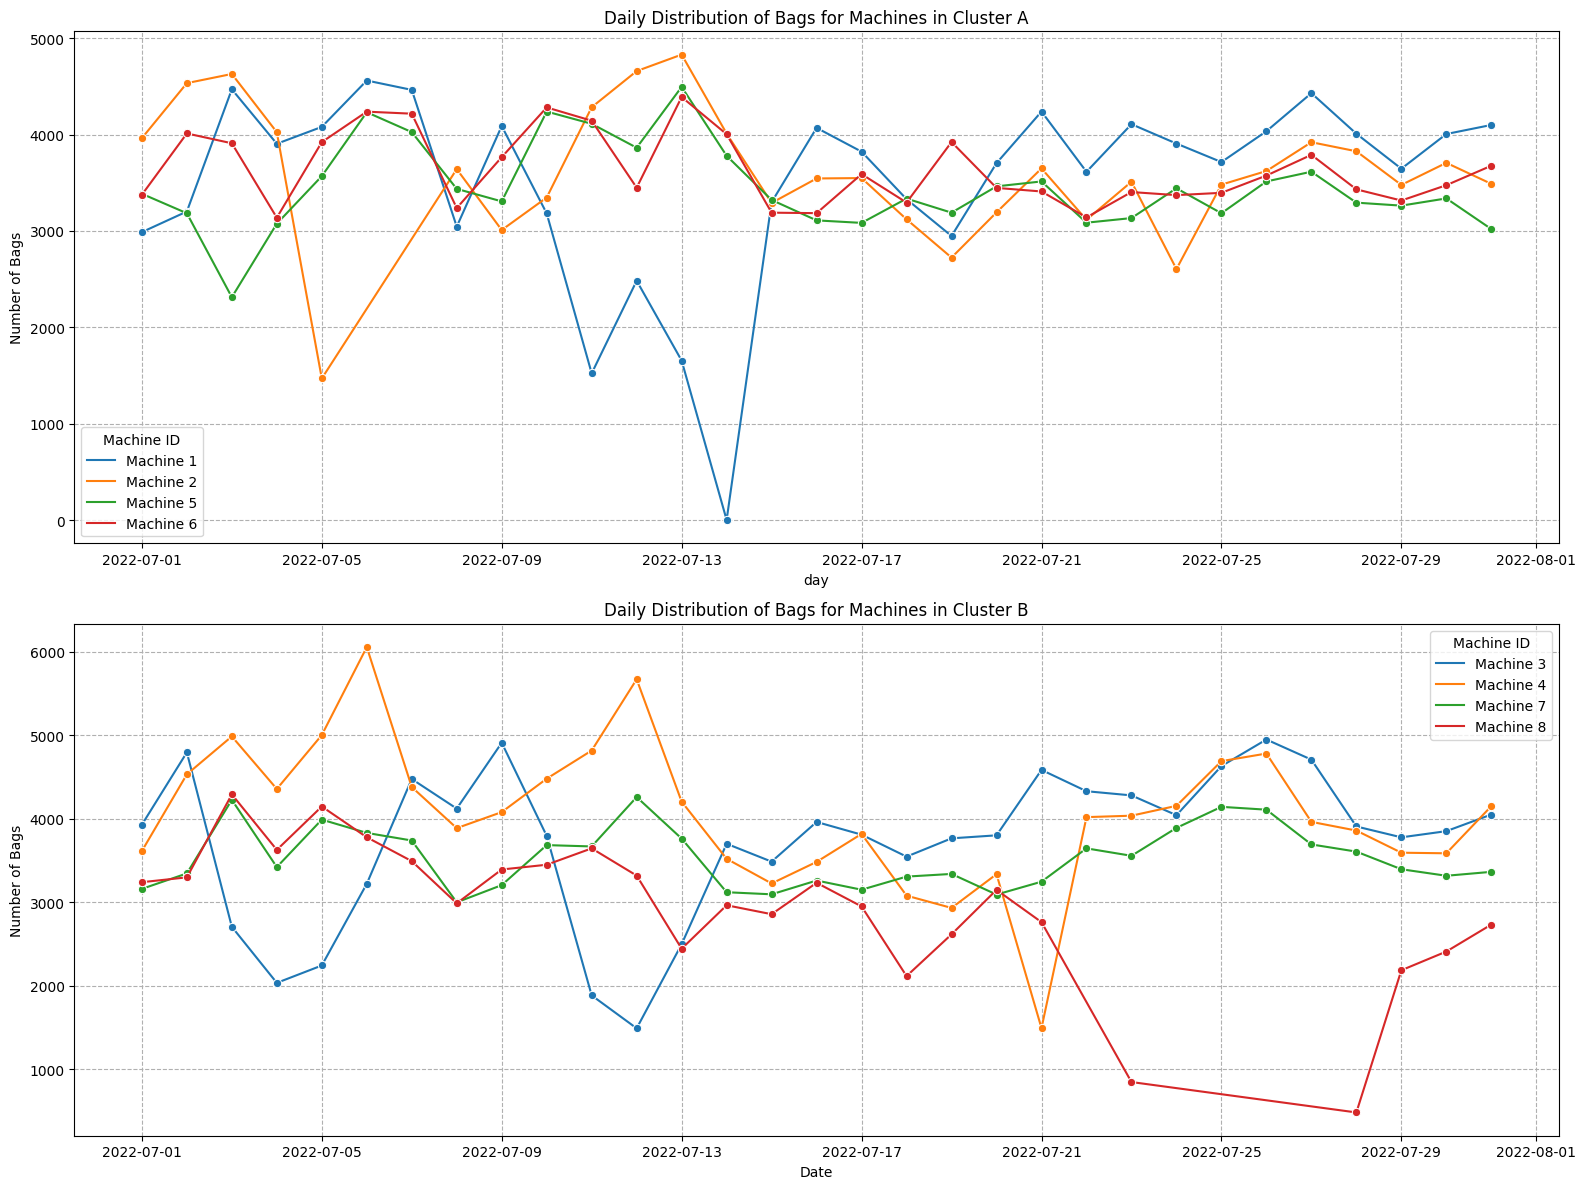

In [90]:
# Group by day, 'scan_machine_cluster', and 'scan_machine_id' and count the distinct number of bags
daily_distribution = data.groupby(['day', 'scan_machine_cluster', 'scan_machine_id'])['bag_licence_plate'].nunique().reset_index(name='bag_count')

# Filter data for the respective clusters
cluster_a_data = daily_distribution[daily_distribution['scan_machine_cluster'] == 'Cluster A']
cluster_b_data = daily_distribution[daily_distribution['scan_machine_cluster'] == 'Cluster B']

# Set up the subplots
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

# Plotting the distribution of bags for Cluster A machines on the top subplot
sns.lineplot(data=cluster_a_data, x='day', y='bag_count', hue='scan_machine_id', marker='o', lw=1.5, ax=ax[0])
ax[0].set_title('Daily Distribution of Bags for Machines in Cluster A')
ax[0].set_ylabel('Number of Bags')
ax[0].grid(True, which="both", ls="--")
ax[0].legend(title='Machine ID')

# Plotting the distribution of bags for Cluster B machines on the bottom subplot
sns.lineplot(data=cluster_b_data, x='day', y='bag_count', hue='scan_machine_id', marker='o', lw=1.5, ax=ax[1])
ax[1].set_title('Daily Distribution of Bags for Machines in Cluster B')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Bags')
ax[1].grid(True, which="both", ls="--")
ax[1].legend(title='Machine ID')

plt.tight_layout()
plt.show()

In [93]:
# Filter the data from 24 July to 28 July
start_date = pd.Timestamp("2022-07-24")
end_date = pd.Timestamp("2022-07-28")
filtered_data = data[(data['bag_scan_timestamp'] >= start_date) & (data['bag_scan_timestamp'] <= end_date)]

# Group by 'scan_machine_cluster' and 'scan_machine_id' and calculate the bag counts
filtered_bag_counts = filtered_data.groupby(['scan_machine_cluster', 'scan_machine_id'])['bag_licence_plate'].nunique().reset_index(name='Number of Distinct Bags')
filtered_bag_counts

scan_machine_cluster scan_machine_id  Number of Distinct Bags
0            Cluster A       Machine 1                    16083
1            Cluster A       Machine 2                    13624
2            Cluster A       Machine 5                    13752
3            Cluster A       Machine 6                    14129
4            Cluster B       Machine 3                    18331
5            Cluster B       Machine 4                    17587
6            Cluster B       Machine 7                    15836

In [99]:
# Define the date ranges to include
start_date_1 = pd.Timestamp("2022-07-01")
end_date_1 = pd.Timestamp("2022-07-21")
start_date_2 = pd.Timestamp("2022-07-29")
end_date_2 = pd.Timestamp("2022-07-31")

# Filter the data based on the defined ranges
filtered_data = data[((data['bag_scan_timestamp'] >= start_date_1) & (data['bag_scan_timestamp'] <= end_date_1)) |
                     ((data['bag_scan_timestamp'] >= start_date_2) & (data['bag_scan_timestamp'] <= end_date_2))]

# Group by 'scan_machine_cluster' and 'scan_machine_id' and calculate the number of distinct bags
filtered_bag_counts = filtered_data.groupby(['scan_machine_cluster', 'scan_machine_id'])['bag_licence_plate'].nunique().reset_index(name='Number of Distinct Bags')
filtered_bag_counts

scan_machine_cluster scan_machine_id  Number of Distinct Bags
0            Cluster A       Machine 1                    72411
1            Cluster A       Machine 2                    72934
2            Cluster A       Machine 5                    77049
3            Cluster A       Machine 6                    81425
4            Cluster B       Machine 3                    75761
5            Cluster B       Machine 4                    90572
6            Cluster B       Machine 7                    76335
7            Cluster B       Machine 8                    69558

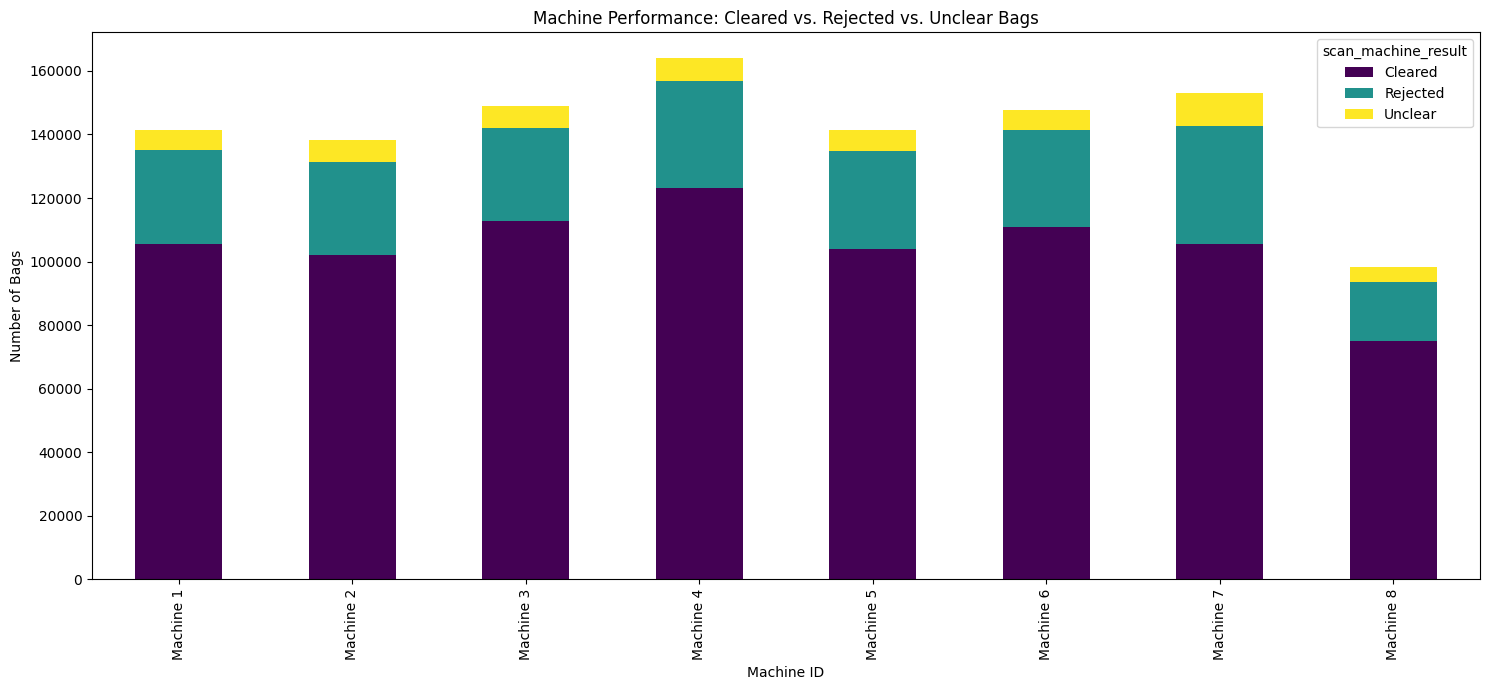

In [100]:
# Group by machine and result to get counts again
machine_performance = data.groupby(['scan_machine_id', 'scan_machine_result'])['bag_licence_plate'].nunique().reset_index(name='count')


# Pivot the data for better visualization
machine_performance_pivot = machine_performance.pivot(index='scan_machine_id', columns='scan_machine_result', values='count').fillna(0)

# Plotting
machine_performance_pivot.plot(kind='bar', stacked=True, figsize=(15, 7), colormap="viridis")
plt.title('Machine Performance: Cleared vs. Rejected vs. Unclear Bags')
plt.xlabel('Machine ID')
plt.ylabel('Number of Bags')
plt.tight_layout()
plt.show()

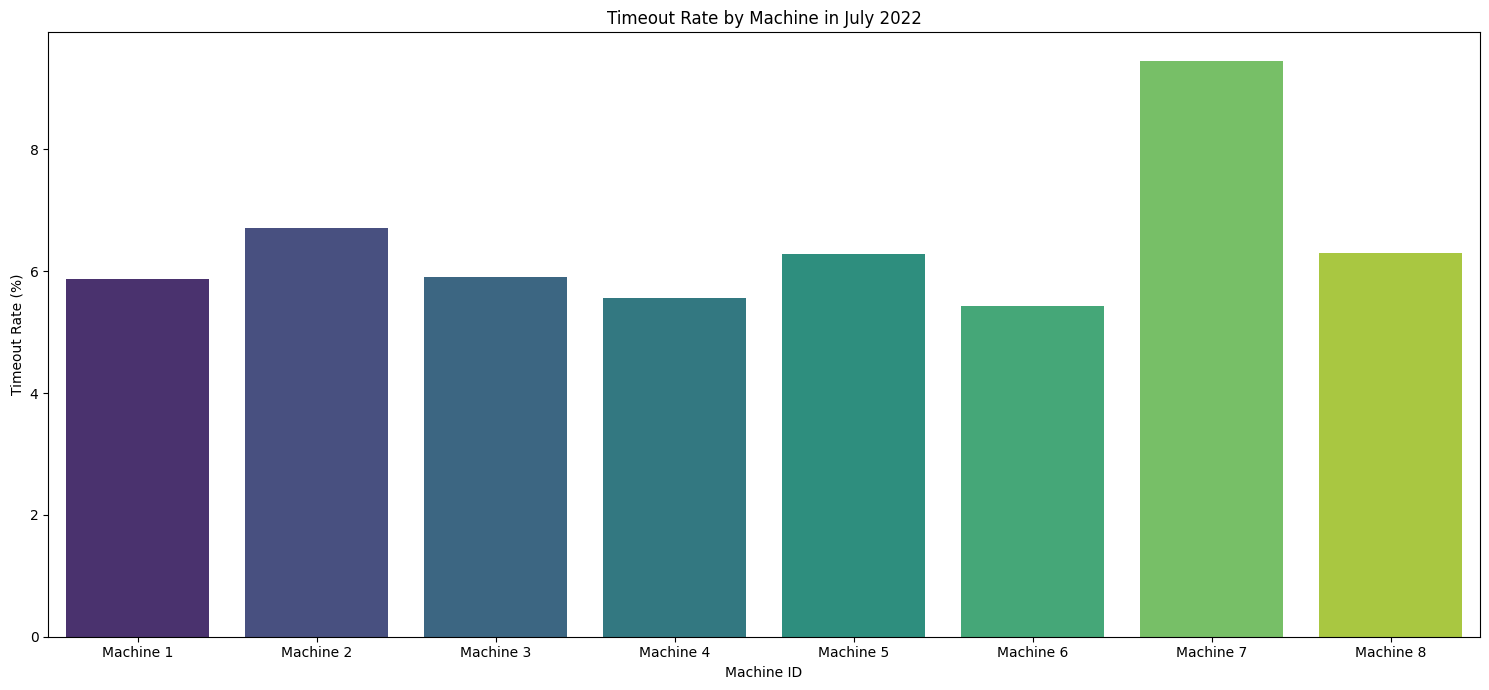

In [102]:
# Filter data for bags that encountered "time out" situations
timeout_data = data[data['scan_machine_result_reason'] == 'Time out']

# Group by machine to get counts of distinct bags that faced "time out" situations for each machine
timeout_counts_by_machine = timeout_data.groupby('scan_machine_id')['bag_licence_plate'].nunique().reset_index(name='timeout_count')
total_counts_by_machine = data.groupby('scan_machine_id')['bag_licence_plate'].nunique().reset_index(name='total_count')

# Merging the counts to compute timeout rate for each machine
timeout_rate_by_machine = pd.merge(total_counts_by_machine, timeout_counts_by_machine, on='scan_machine_id')
timeout_rate_by_machine['timeout_rate'] = (timeout_rate_by_machine['timeout_count'] / timeout_rate_by_machine['total_count']) * 100

# Plotting
plt.figure(figsize=(15, 7))
sns.barplot(data=timeout_rate_by_machine, x='scan_machine_id', y='timeout_rate', palette='viridis')
plt.title('Timeout Rate by Machine in July 2022')
plt.xlabel('Machine ID')
plt.ylabel('Timeout Rate (%)')
plt.tight_layout()
plt.show()

### 5. Machine Performance Analysis
Ascertain the average duration expended by operators in examining each bag at every machine. The time interval between consecutive bags will indicate the duration required for decision-making at either level.

In [103]:
# Sort the data by machine ID and timestamp
sorted_data = data.sort_values(by=['scan_machine_id', 'bag_scan_timestamp'])

# Calculate the time difference between consecutive rows for each machine in seconds
sorted_data['time_diff_seconds'] = sorted_data.groupby('scan_machine_id')['bag_scan_timestamp'].diff().dt.total_seconds()
sorted_data[['bag_scan_timestamp','scan_machine_id','time_diff_seconds']]

bag_scan_timestamp scan_machine_id  time_diff_seconds
1796    2022-07-01 03:05:04       Machine 1                NaN
1       2022-07-01 03:05:08       Machine 1                4.0
2       2022-07-01 03:05:13       Machine 1                5.0
27      2022-07-01 03:09:47       Machine 1              274.0
9196    2022-07-01 03:14:50       Machine 1              303.0
...                     ...             ...                ...
1248662 2022-07-31 21:35:20       Machine 8                3.0
1248663 2022-07-31 21:35:21       Machine 8                1.0
1248664 2022-07-31 21:35:26       Machine 8                5.0
1248666 2022-07-31 21:35:34       Machine 8                8.0
1248789 2022-07-31 22:07:25       Machine 8             1911.0

[1138220 rows x 3 columns]

In [104]:
# Sort the data by machine ID and timestamp
sorted_data = data.sort_values(by=['scan_machine_id', 'bag_scan_timestamp'])

# Calculate the time difference between rows for each machine in seconds
sorted_data['time_diff_seconds'] = sorted_data.groupby('scan_machine_id')['bag_scan_timestamp'].diff().dt.total_seconds()

# Compute the average duration for each machine in seconds
corrected_average_durations = sorted_data.groupby('scan_machine_id')['time_diff_seconds'].mean().reset_index()
corrected_average_durations

scan_machine_id  time_diff_seconds
0       Machine 1          18.640715
1       Machine 2          19.145897
2       Machine 3          17.787595
3       Machine 4          16.162645
4       Machine 5          18.749523
5       Machine 6          17.969178
6       Machine 7          17.332154
7       Machine 8          26.972686

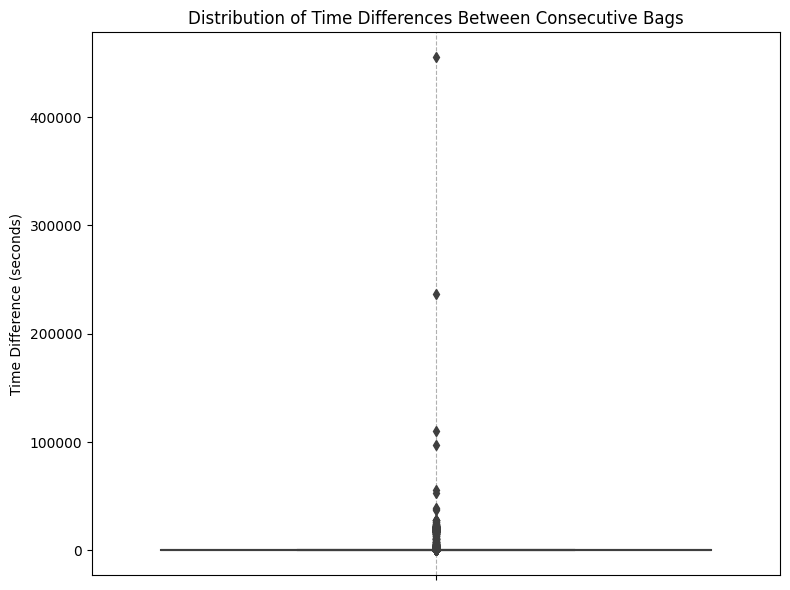

In [105]:
# boxplot to visualize the distribution of time_diff_seconds
plt.figure(figsize=(8, 6))
sns.boxplot(y=sorted_data['time_diff_seconds'])
plt.title('Distribution of Time Differences Between Consecutive Bags')
plt.ylabel('Time Difference (seconds)')
plt.grid(axis='x', which="both", ls="--")
plt.tight_layout()
plt.show()

In [106]:
# Number of rows removed if applying filter of time differences that are above 18000 seconds (5 hours) 
num_rows_removed = sorted_data.shape[0] - sorted_data[sorted_data['time_diff_seconds'] < 10800].shape[0]
num_rows_removed_pecentage = num_rows_removed/sorted_data.shape[0]

sorted_data.shape[0],num_rows_removed,num_rows_removed_pecentage

(1138220, 243, 0.00021349124070917748)

In [107]:
# Filtering out time differences that are above 18000 seconds (5 hours)
filtered_data = sorted_data[sorted_data['time_diff_seconds'] < 18000]

# Compute the average duration for each machine in seconds using the filtered data
corrected_average_durations_filtered = filtered_data.groupby('scan_machine_id')['time_diff_seconds'].mean().reset_index()
corrected_average_durations_filtered

scan_machine_id  time_diff_seconds
0       Machine 1          14.269646
1       Machine 2          14.033231
2       Machine 3          14.628398
3       Machine 4          12.968079
4       Machine 5          15.192731
5       Machine 6          14.503016
6       Machine 7          14.329185
7       Machine 8          17.230682

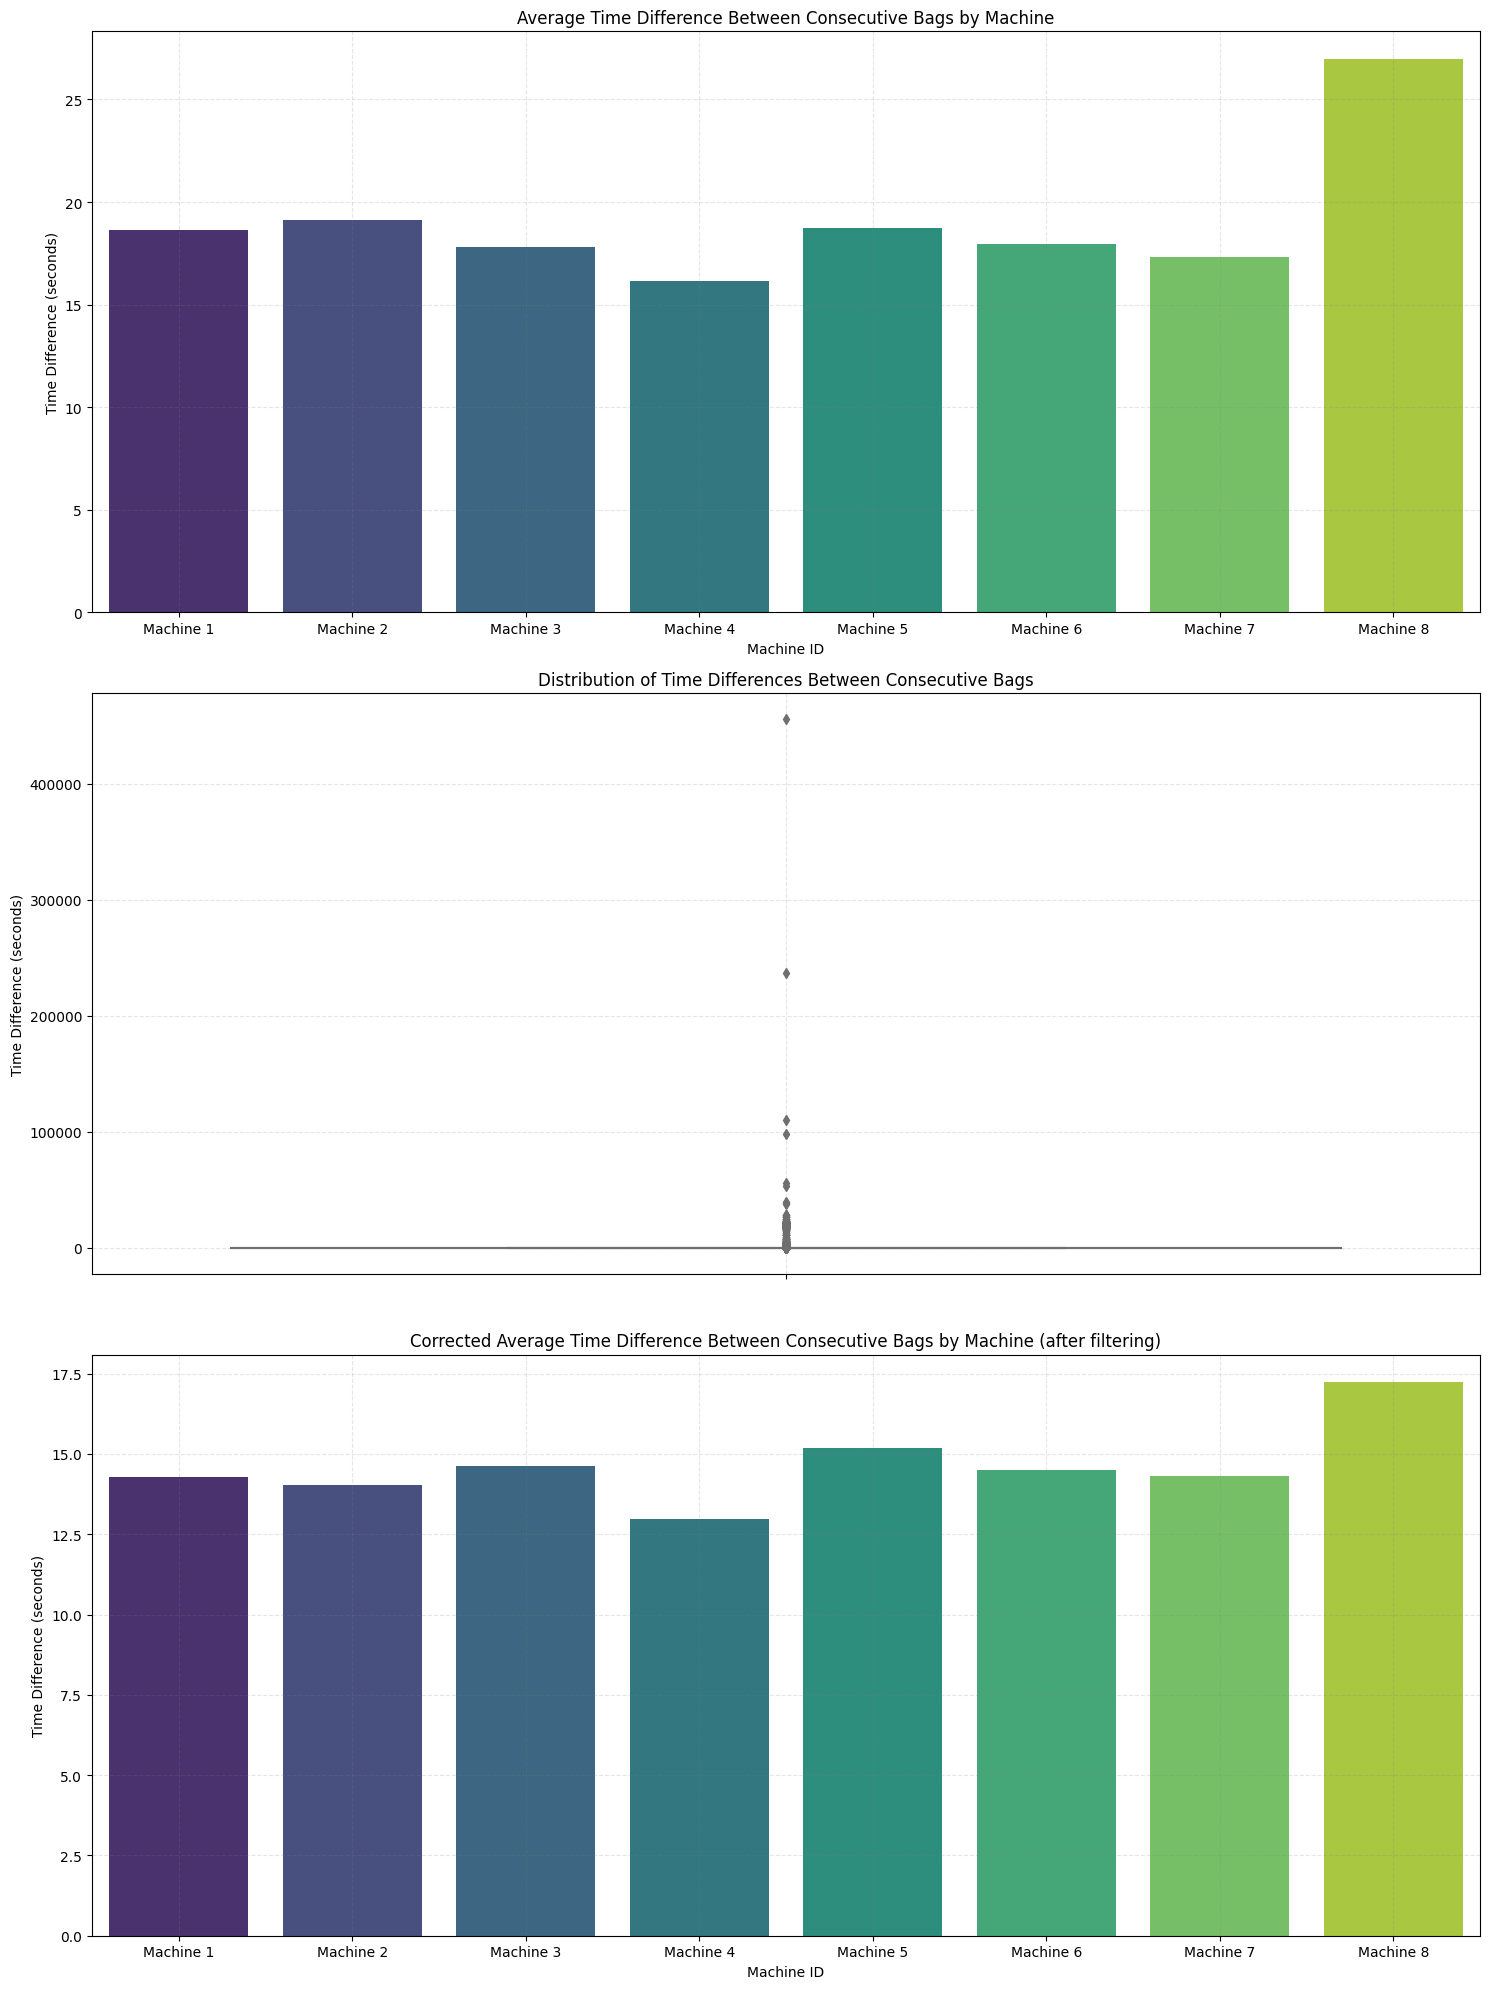

In [120]:
# Group by machine and calculate the time difference between consecutive bags
sorted_data = data.sort_values(by=['scan_machine_id', 'bag_scan_timestamp'])
sorted_data['time_diff_seconds'] = sorted_data.groupby('scan_machine_id')['bag_scan_timestamp'].diff().dt.total_seconds()

# Compute the average duration for each machine in seconds
corrected_average_durations = sorted_data.groupby('scan_machine_id')['time_diff_seconds'].mean().reset_index()

# Filtering out time differences that are above 18000 seconds (5 hours)
filtered_data = sorted_data[sorted_data['time_diff_seconds'] < 18000]

# Compute the average duration for each machine in seconds using the filtered data
corrected_average_durations_filtered = filtered_data.groupby('scan_machine_id')['time_diff_seconds'].mean().reset_index()

# Visualization
fig, ax = plt.subplots(3, 1, figsize=(15, 20))

# 1. Bar chart showing the average time difference between bags for each machine
sns.barplot(data=corrected_average_durations, x='scan_machine_id', y='time_diff_seconds', ax=ax[0], palette='viridis')
ax[0].set_title('Average Time Difference Between Consecutive Bags by Machine')
ax[0].set_xlabel('Machine ID')
ax[0].set_ylabel('Time Difference (seconds)')
ax[0].grid(True, which="both", ls="--", c='gray', alpha=0.2)

# 2. Boxplot showing the distribution of time differences between consecutive bags
sns.boxplot(y=sorted_data['time_diff_seconds'], ax=ax[1], color='skyblue')
ax[1].set_title('Distribution of Time Differences Between Consecutive Bags')
ax[1].set_ylabel('Time Difference (seconds)')
ax[1].grid(True, which="both", ls="--", c='gray', alpha=0.2)

# 3. Bar chart showing the corrected average time difference between bags for each machine after filtering
sns.barplot(data=corrected_average_durations_filtered, x='scan_machine_id', y='time_diff_seconds', ax=ax[2], palette='viridis')
ax[2].set_title('Corrected Average Time Difference Between Consecutive Bags by Machine (after filtering)')
ax[2].set_xlabel('Machine ID')
ax[2].set_ylabel('Time Difference (seconds)')
ax[2].grid(True, which="both", ls="--", c='gray', alpha=0.2)

plt.tight_layout()
plt.show()

### 6. Level 2 Screening Analysis
Determine the quantity of bags reaching level 2, providing insights into the volume of bags subjected to this screening level.

In [108]:
# Filter the dataset to select bags processed at scan_machine_level 2
level_2_bags = len(data[data['scan_machine_level'] == 'Level 2'])

# Calcualte the percentage
total_bags = len(data)
level_2_percentage = level_2_bags/total_bags*100

total_bags, level_2_bags, level_2_percentage

(1138220, 287641, 25.271125090052887)

310796 bags reached level 2 in July.

This represents approximately 24.89% of the total bags processed during July.

In [109]:
# Filter bags processed at Level 2 and get value counts for scan_machine_result and scan_machine_result_reason
level_2_result_counts = data[data['scan_machine_level'] == 'Level 2']['scan_machine_result'].value_counts()
level_2_result_reason_counts = data[data['scan_machine_level'] == 'Level 2']['scan_machine_result_reason'].value_counts()

level_2_result_counts, level_2_result_reason_counts

(Cleared     286359
 Rejected      1282
 Name: scan_machine_result, dtype: int64,
 None          286359
 Explosives      1282
 Name: scan_machine_result_reason, dtype: int64)

In [110]:
1282/(1282+286359)*100

0.4456944594129488

In scanning machine level 2, there are no "Unclear" results and "Time out" and "No decision" reasons compared to level 1, which reflect its efficiency in the baggage screening process.

Maritory of bags are 'Cleared' and only 1282 bags (0.45%) are 'Rejected' due to 'Explosives'.

C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\3615792642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_2_data['hour'] = pd.to_datetime(level_2_data['bag_scan_timestamp']).dt.hour
C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\3615792642.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_2_data['wave'] = level_2_data['hour'].apply(get_wave)
C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\3615792642.py:15: FutureWarning: Using the level keyword in DataFrame and Series aggregations 

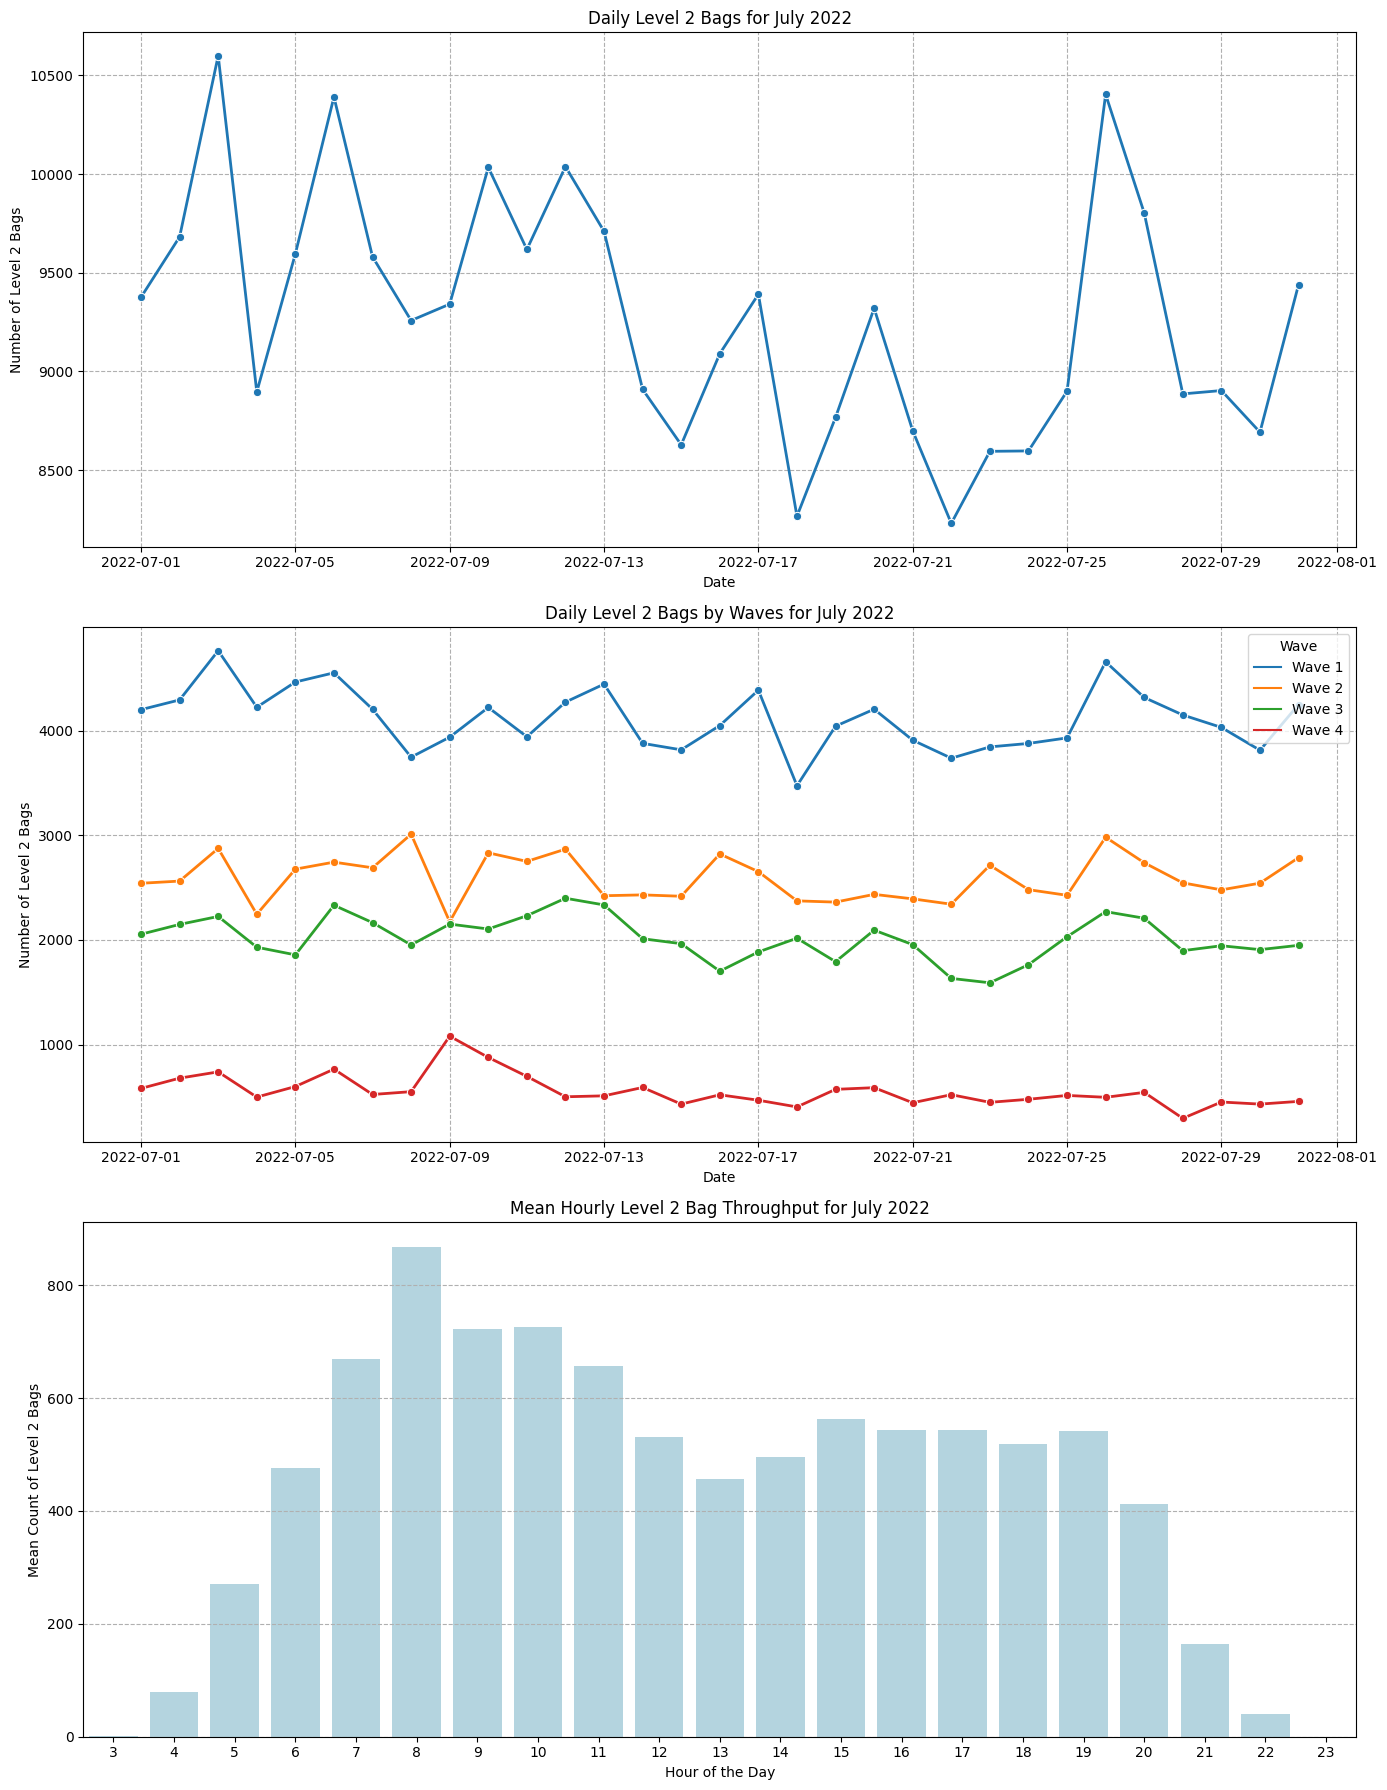

In [111]:
# Filter data for Level 2 screenings
level_2_data = data[data['scan_machine_level'] == 'Level 2']

# 1. Grouping by day and counting the number of Level 2 bags
daily_level_2 = level_2_data.groupby('day').size().reset_index(name='level_2_count')

# 2. Extract the hour and identify the wave based on the hour
level_2_data['hour'] = pd.to_datetime(level_2_data['bag_scan_timestamp']).dt.hour
level_2_data['wave'] = level_2_data['hour'].apply(get_wave)

# Grouping by day, hour, and wave, then counting the number of Level 2 bags
daily_wave_level_2 = level_2_data.groupby(['day', 'wave']).size().reset_index(name='level_2_count')

# 3. Group by the hour and calculate the mean count of Level 2 bags for each hour across July
mean_hourly_level_2 = level_2_data.groupby(level_2_data['hour']).size().mean(level=0).reset_index(name='Mean Count of Level 2 Bags')
mean_hourly_level_2['Mean Count of Level 2 Bags'] /= 31  # As July has 31 days

# Setting up the figure and axes for 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# Plotting the distribution of daily Level 2 bags for the month of July on the first axes (top)
sns.lineplot(data=daily_level_2, x='day', y='level_2_count', marker="o", lw=2, ax=ax[0])
ax[0].set_title('Daily Level 2 Bags for July 2022')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Level 2 Bags')
ax[0].grid(True, which="both", ls="--")

# Plotting daily Level 2 bags by waves for July 2022 on the second axes (middle)
sns.lineplot(data=daily_wave_level_2, x='day', y='level_2_count', hue='wave', marker="o", lw=2, ax=ax[1])
ax[1].set_title('Daily Level 2 Bags by Waves for July 2022')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Level 2 Bags')
ax[1].grid(True, which="both", ls="--")
ax[1].legend(title='Wave')

# Plotting the distribution of mean hourly Level 2 bag counts for July on the third axes (bottom)
sns.barplot(data=mean_hourly_level_2, x='hour', y='Mean Count of Level 2 Bags', color='lightblue', ax=ax[2])
ax[2].set_title('Mean Hourly Level 2 Bag Throughput for July 2022')
ax[2].set_xlabel('Hour of the Day')
ax[2].set_ylabel('Mean Count of Level 2 Bags')
ax[2].grid(axis='y', which="both", ls="--")

plt.tight_layout()
plt.show()

### 7. Recirculation Analysis
Investigate the occurrence of bags undergoing multiple screenings (recirculation). Under normal circumstances, a bag should be screened at either level 1 or level 2 only if a decision cannot be reached at level 1. It is imperative to ascertain whether bags are being re-examined after clearance at any level.

In [112]:
# Identify bags that were screened at both Level 1 and Level 2
level_1_bags = set(data[data['scan_machine_level'] == 'Level 1']['bag_licence_plate'])
level_2_bags = set(data[data['scan_machine_level'] == 'Level 2']['bag_licence_plate'])
bags_both_levels = level_1_bags.intersection(level_2_bags)

num_bags_both_levels = len(bags_both_levels)
both_levels_percentage = num_bags_both_levels/total_bags*100
total_bags,num_bags_both_levels,both_levels_percentage

(1138220, 287231, 25.235103934213072)

287,248 bags underwent screenings at both Level 1 and Level 2 in July.

This represents approximately 23% of the total bags processed during July.

In [117]:
# Filter bags that were screened at both Level 1 and Level 2 using the intersection of sets
multi_screened_data = data[data['bag_licence_plate'].isin(bags_both_levels)]

# Find the reasons these bags transitioned from Level 1 to Level 2
transition_reasons = multi_screened_data[multi_screened_data['scan_machine_level'] == 'Level 1']['scan_machine_result_reason'].value_counts()
transition_reasons

Explosives    232185
Time out       55011
None              35
Name: scan_machine_result_reason, dtype: int64

In [116]:
# Calcualte the percentage of transition reasons that are 'Explosoves' and 'Time out'
(232185+55011)/transition_reasons.sum()*100

99.98781468574074

Some bags have multiple records at Level 1 with different reasons for transitioning to Level 2.

Around 99.9% bags were flagged due to potential explosives detection and faced a time out.

C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\1609561908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_screened_data['hour'] = pd.to_datetime(multi_screened_data['bag_scan_timestamp']).dt.hour
C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\1609561908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_screened_data['wave'] = multi_screened_data['hour'].apply(get_wave)
C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\1609561908.py:12: FutureWarning: Using the level keyword in DataFr

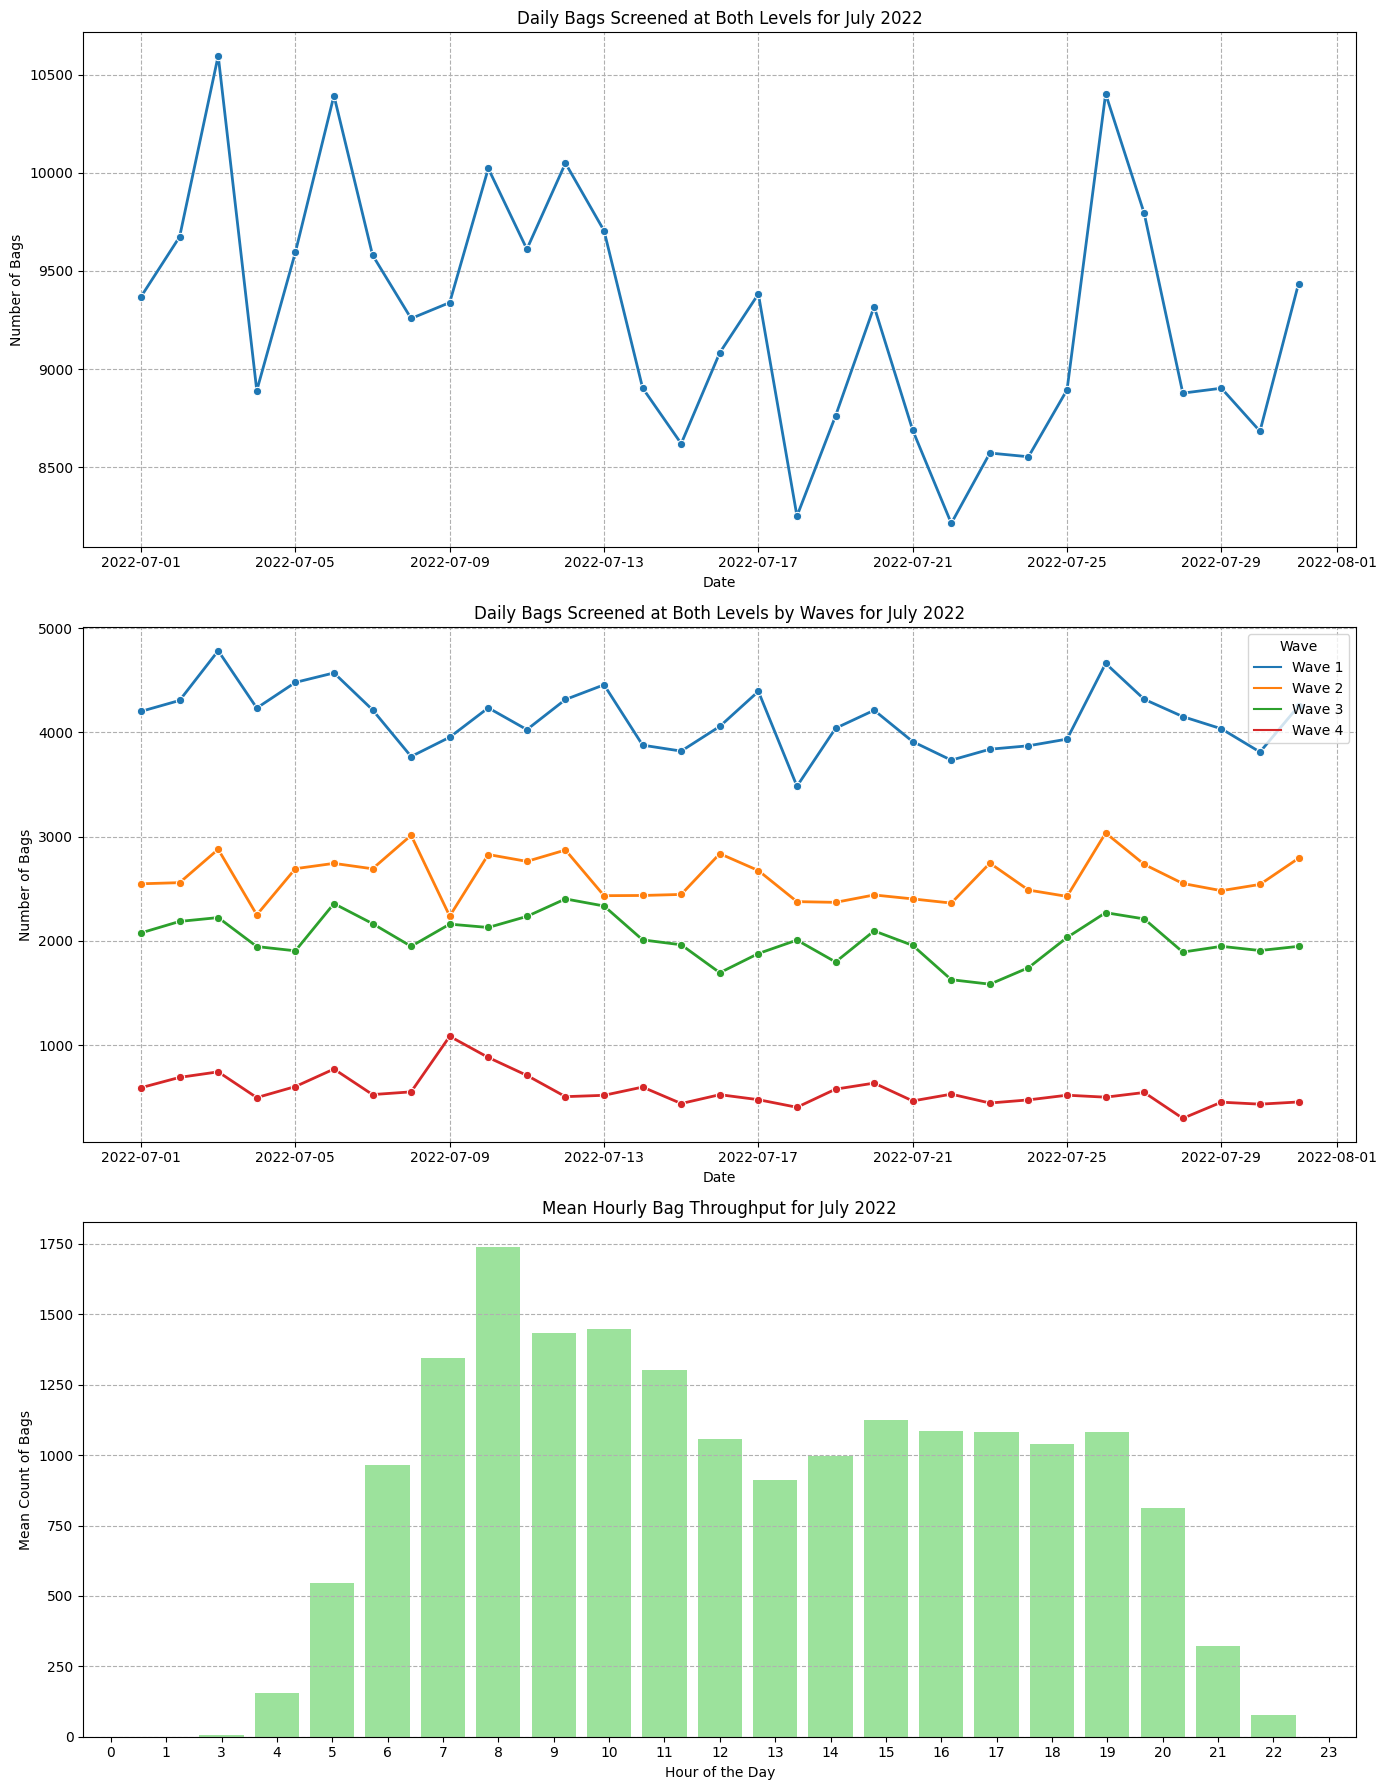

In [118]:
# Group by day and count the number of unique bags
daily_multi_screened_counts = multi_screened_data.groupby('day').nunique()['bag_licence_plate'].reset_index(name='count')

# Extract the hour and identify the wave based on the hour
multi_screened_data['hour'] = pd.to_datetime(multi_screened_data['bag_scan_timestamp']).dt.hour
multi_screened_data['wave'] = multi_screened_data['hour'].apply(get_wave)

# Group by day and wave, then count the number of unique bags
daily_wave_multi_screened_counts = multi_screened_data.groupby(['day', 'wave']).nunique()['bag_licence_plate'].reset_index(name='count')

# Group by the hour and calculate the mean count of bags for each hour across July
mean_hourly_counts = multi_screened_data.groupby(multi_screened_data['hour'])['bag_licence_plate'].count().mean(level=0).reset_index(name='Mean Count of Bags')
mean_hourly_counts['Mean Count of Bags'] /= 31  # As July has 31 days

# Setting up the figure and axes for 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# 1. Plotting the distribution of daily bags screened at both levels for the month of July on the first axes (top)
sns.lineplot(data=daily_multi_screened_counts, x='day', y='count', marker="o", lw=2, ax=ax[0])
ax[0].set_title('Daily Bags Screened at Both Levels for July 2022')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Bags')
ax[0].grid(True, which="both", ls="--")

# 2. Plotting daily bags screened at both levels by waves for July 2022 on the second axes (middle)
sns.lineplot(data=daily_wave_multi_screened_counts, x='day', y='count', hue='wave', marker="o", lw=2, ax=ax[1])
ax[1].set_title('Daily Bags Screened at Both Levels by Waves for July 2022')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Bags')
ax[1].grid(True, which="both", ls="--")
ax[1].legend(title='Wave')

# 3. Plotting the distribution of mean hourly bag counts for July on the third axes (bottom)
sns.barplot(data=mean_hourly_counts, x='hour', y='Mean Count of Bags', color='lightgreen', ax=ax[2])
ax[2].set_title('Mean Hourly Bag Throughput for July 2022')
ax[2].set_xlabel('Hour of the Day')
ax[2].set_ylabel('Mean Count of Bags')
ax[2].grid(axis='y', which="both", ls="--")

# Adjust the layout
plt.tight_layout()
plt.show()

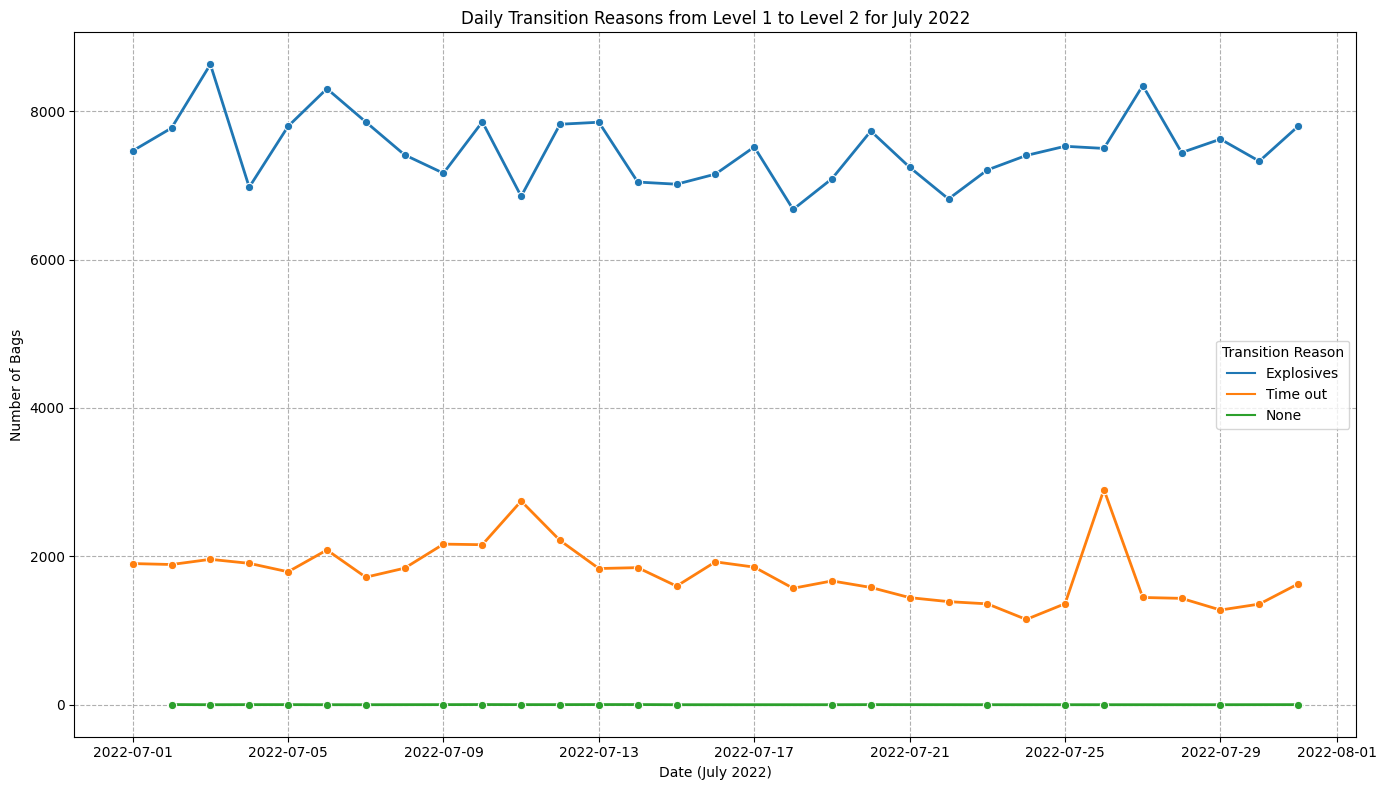

In [119]:
# Group the data by day and reason for transition, then reset the index for plotting
transition_counts = multi_screened_data[multi_screened_data['scan_machine_level'] == 'Level 1'].groupby(['day', 'scan_machine_result_reason']).size().reset_index(name='count')

# Plotting the daily transition reasons for bags screened at both Level 1 and Level 2
plt.figure(figsize=(14, 8))
sns.lineplot(data=transition_counts, x='day', y='count', hue='scan_machine_result_reason', marker="o", lw=2)
plt.title('Daily Transition Reasons from Level 1 to Level 2 for July 2022')
plt.xlabel('Date (July 2022)')
plt.ylabel('Number of Bags')
plt.grid(True, which="both", ls="--")
plt.legend(title='Transition Reason')
plt.tight_layout()
plt.show()

### 8. "Time Out" Situations & "Time Out" Rate Analysis by Day & Machines

Assess the significance of bags that encounter "time out" situations, aiming to gauge the extent of this issue.

In [121]:
# Investigate the value count of the 'scan_machine_result_reason' column
data['scan_machine_result_reason'].value_counts()

None          843059
Explosives    240014
Time out       55147
Name: scan_machine_result_reason, dtype: int64

In [123]:
# Count the bags for "time out" situations using the 'scan_machine_result_reason' column
timeout_bags = len(data[data['scan_machine_result_reason'] == 'Time out'])

# Calcualte the percentage
total_bags = len(data)
timeout_percentage = timeout_bags/total_bags*100

total_bags,timeout_bags,timeout_percentage

(1138220, 55147, 4.845021173411116)

55,147 bags encountered "time out" situations in July.

This represents approximately 4.85% of the total bags processed during July.

In [124]:
# Calcualte the percentage of bags that are not 'None'
total_bags_NotNone = len(data[data['scan_machine_result_reason'] != 'None'])
timeout_percentage_NotNone = timeout_bags/total_bags_NotNone*100

total_bags_NotNone,timeout_bags,timeout_percentage_NotNone

(295161, 55147, 18.68370143752054)

Among the bags that had some specific reason recorded (other than 'None'), around 18.68% of them had "time out" as the reason

C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\1497954165.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeout_data['hour'] = pd.to_datetime(timeout_data['bag_scan_timestamp']).dt.hour
C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\1497954165.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeout_data['wave'] = timeout_data['hour'].apply(get_wave)
C:\Users\Gurne\AppData\Local\Temp\ipykernel_15664\1497954165.py:26: FutureWarning: Using the level keyword in DataFrame and Series aggregation

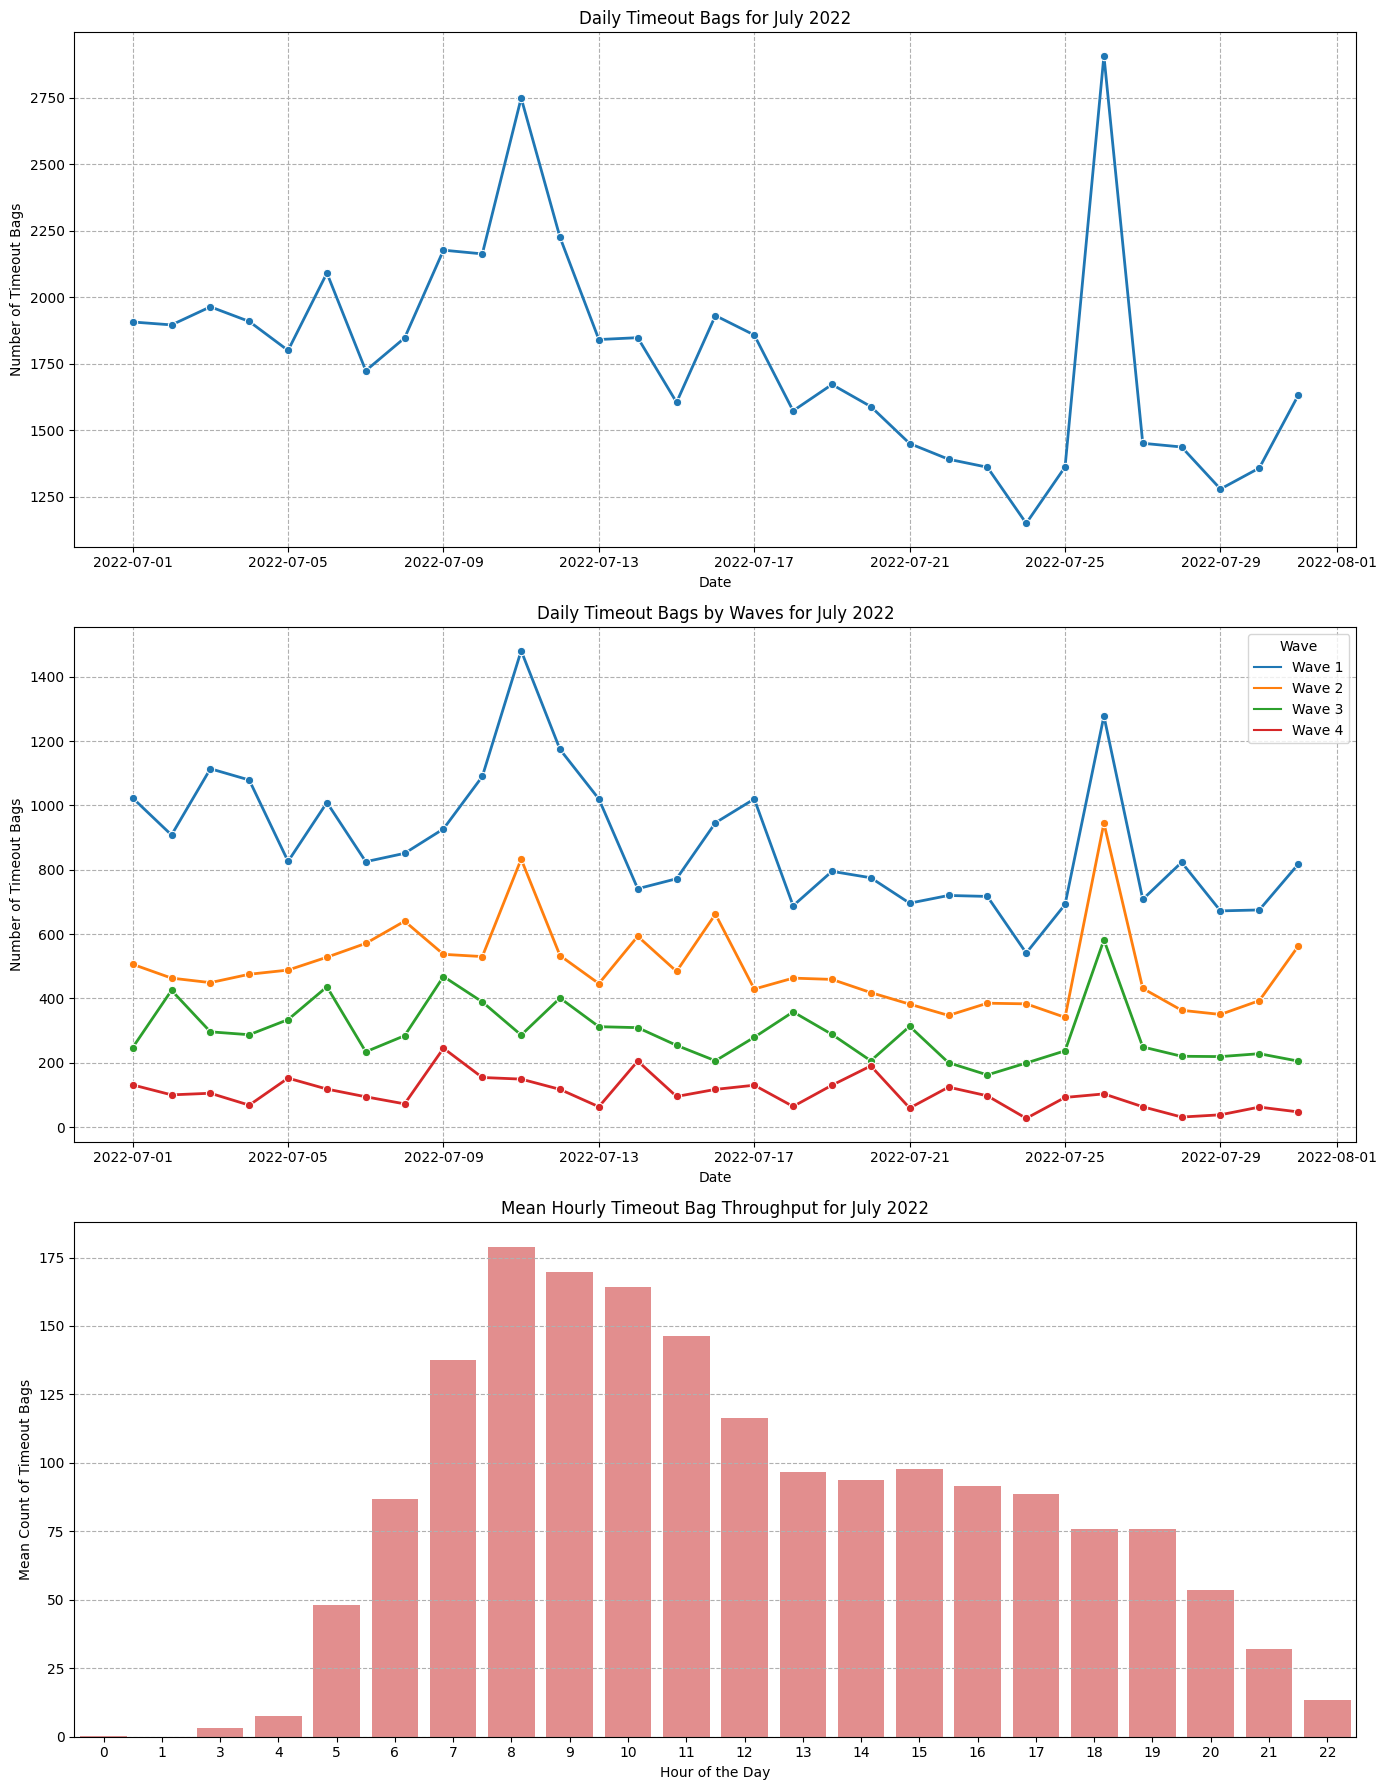

In [133]:
# Filter the data for "time out" situations
timeout_data = data[data['scan_machine_result_reason'] == 'Time out']

# Grouping by day and counting the number of timeout bags
daily_timeouts = timeout_data.groupby('day').size().reset_index(name='timeout_count')

# Define the "get_wave" function to categorize the hour into specific waves
def get_wave(hour):
    if 6 <= hour < 12:
        return 'Wave 1'
    elif 12 <= hour < 17:
        return 'Wave 2'
    elif 17 <= hour < 21:
        return 'Wave 3'
    else:
        return 'Wave 4'

# Extract the hour and identify the wave based on the hour
timeout_data['hour'] = pd.to_datetime(timeout_data['bag_scan_timestamp']).dt.hour
timeout_data['wave'] = timeout_data['hour'].apply(get_wave)

# Grouping by day and wave, then counting the number of timeout bags
daily_wave_timeouts = timeout_data.groupby(['day', 'wave']).size().reset_index(name='timeout_count')

# Grouping by the hour and calculating the mean count of timeout bags for each hour across July
mean_hourly_timeouts = timeout_data.groupby(timeout_data['hour'])['bag_licence_plate'].nunique().mean(level=0).reset_index(name='Mean Count of Timeout Bags')
mean_hourly_timeouts['Mean Count of Timeout Bags'] /= 31  # As July has 31 days

# Setting up the figure and axes for 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# 1. Plotting the distribution of daily timeout bags for the month of July on the first axes (top)
sns.lineplot(data=daily_timeouts, x='day', y='timeout_count', marker="o", lw=2, ax=ax[0])
ax[0].set_title('Daily Timeout Bags for July 2022')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Timeout Bags')
ax[0].grid(True, which="both", ls="--")

# 2. Plotting daily timeout bags by waves for July 2022 on the second axes (middle)
sns.lineplot(data=daily_wave_timeouts, x='day', y='timeout_count', hue='wave', marker="o", lw=2, ax=ax[1])
ax[1].set_title('Daily Timeout Bags by Waves for July 2022')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Number of Timeout Bags')
ax[1].grid(True, which="both", ls="--")
ax[1].legend(title='Wave')

# 3. Plotting the distribution of mean hourly timeout bag counts for July on the third axes (bottom)
sns.barplot(data=mean_hourly_timeouts, x='hour', y='Mean Count of Timeout Bags', color='lightcoral', ax=ax[2])
ax[2].set_title('Mean Hourly Timeout Bag Throughput for July 2022')
ax[2].set_xlabel('Hour of the Day')
ax[2].set_ylabel('Mean Count of Timeout Bags')
ax[2].grid(axis='y', which="both", ls="--")

# Adjust the layout
plt.tight_layout()
plt.show()

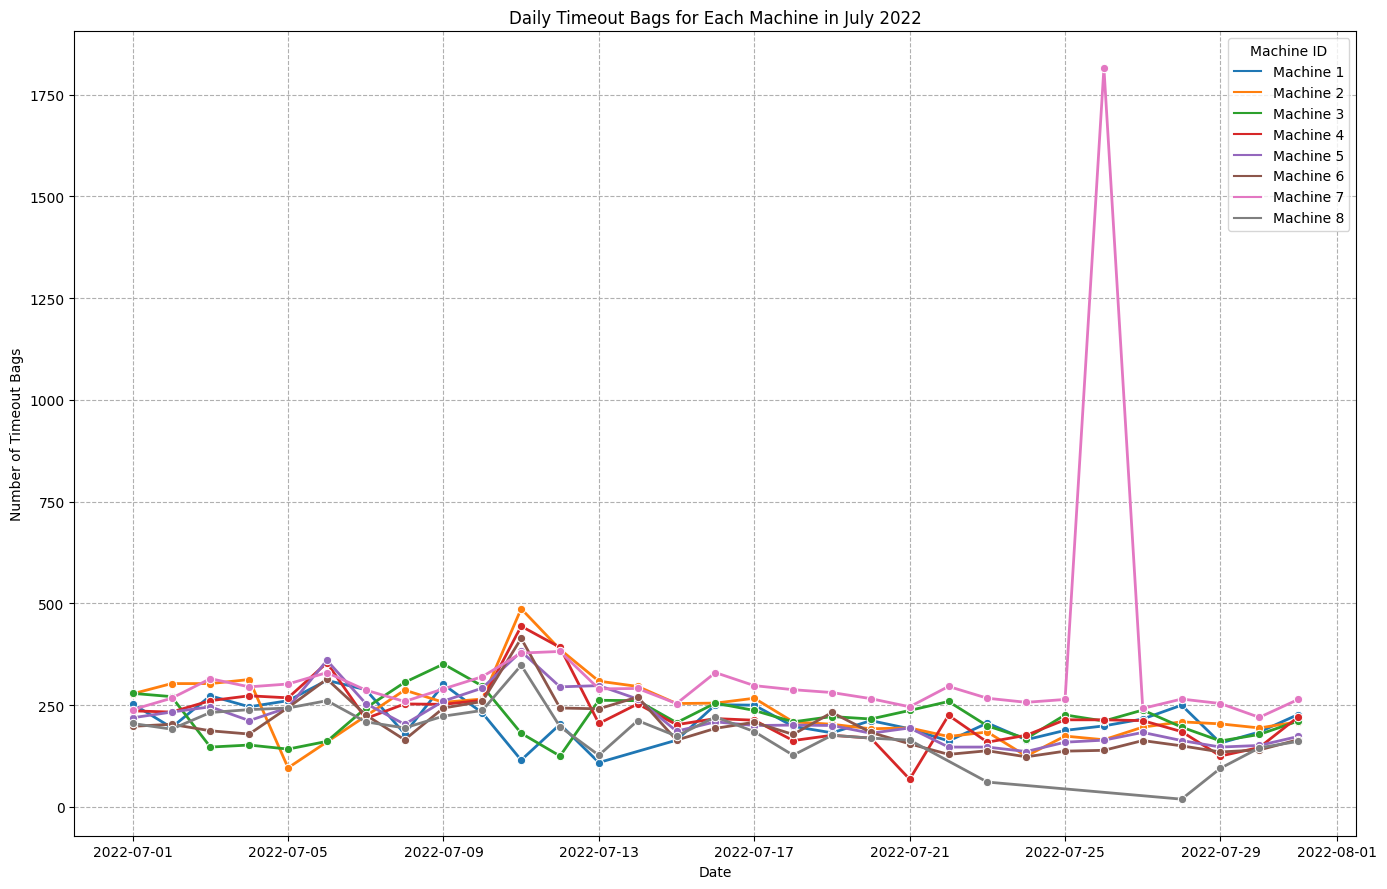

In [131]:
# Grouping by day and machine ID, then counting the number of distinct timeout bags
daily_machine_timeouts = timeout_data.groupby(['day', 'scan_machine_id'])['bag_licence_plate'].nunique().reset_index(name='timeout_count')

# Set up the figure for the plot
plt.figure(figsize=(14, 9))

# Plotting the distribution of daily timeout bags for the month of July for each machine
sns.lineplot(data=daily_machine_timeouts, x='day', y='timeout_count', hue='scan_machine_id', marker="o", lw=2)
plt.title('Daily Timeout Bags for Each Machine in July 2022')
plt.xlabel('Date')
plt.ylabel('Number of Timeout Bags')
plt.grid(True, which="both", ls="--")
plt.legend(title='Machine ID')
plt.tight_layout()
plt.show()

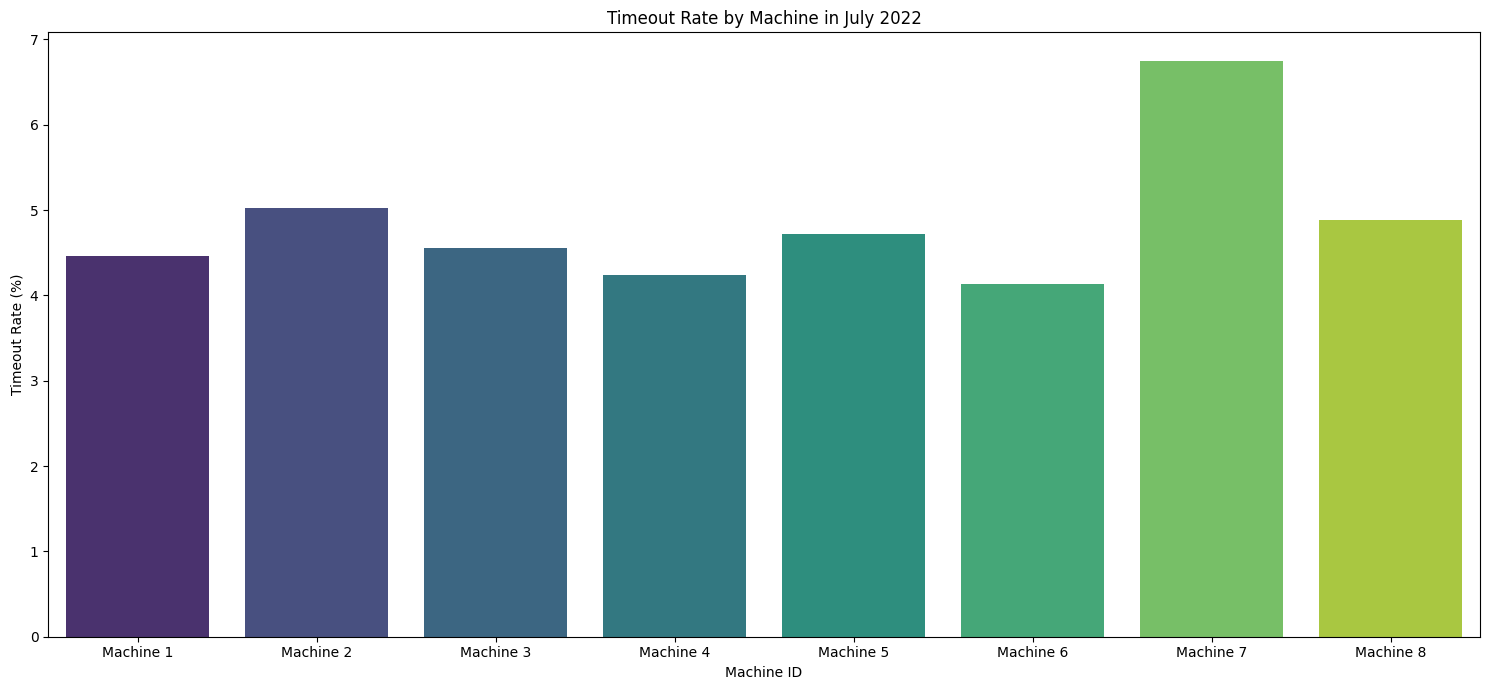

In [127]:
# Filter data for bags that encountered "time out" situations
timeout_data = data[data['scan_machine_result_reason'] == 'Time out']

# Group by machine to get counts of "time out" situations for each machine
timeout_counts_by_machine = timeout_data.groupby('scan_machine_id').size().reset_index(name='timeout_count')
total_counts_by_machine = data.groupby('scan_machine_id').size().reset_index(name='total_count')

# Merging the counts to compute timeout rate for each machine
timeout_rate_by_machine = pd.merge(total_counts_by_machine, timeout_counts_by_machine, on='scan_machine_id')
timeout_rate_by_machine['timeout_rate'] = (timeout_rate_by_machine['timeout_count'] / timeout_rate_by_machine['total_count']) * 100

# Plotting
plt.figure(figsize=(15, 7))
sns.barplot(data=timeout_rate_by_machine, x='scan_machine_id', y='timeout_rate', palette='viridis')
plt.title('Timeout Rate by Machine in July 2022')
plt.xlabel('Machine ID')
plt.ylabel('Timeout Rate (%)')
plt.tight_layout()
plt.show()

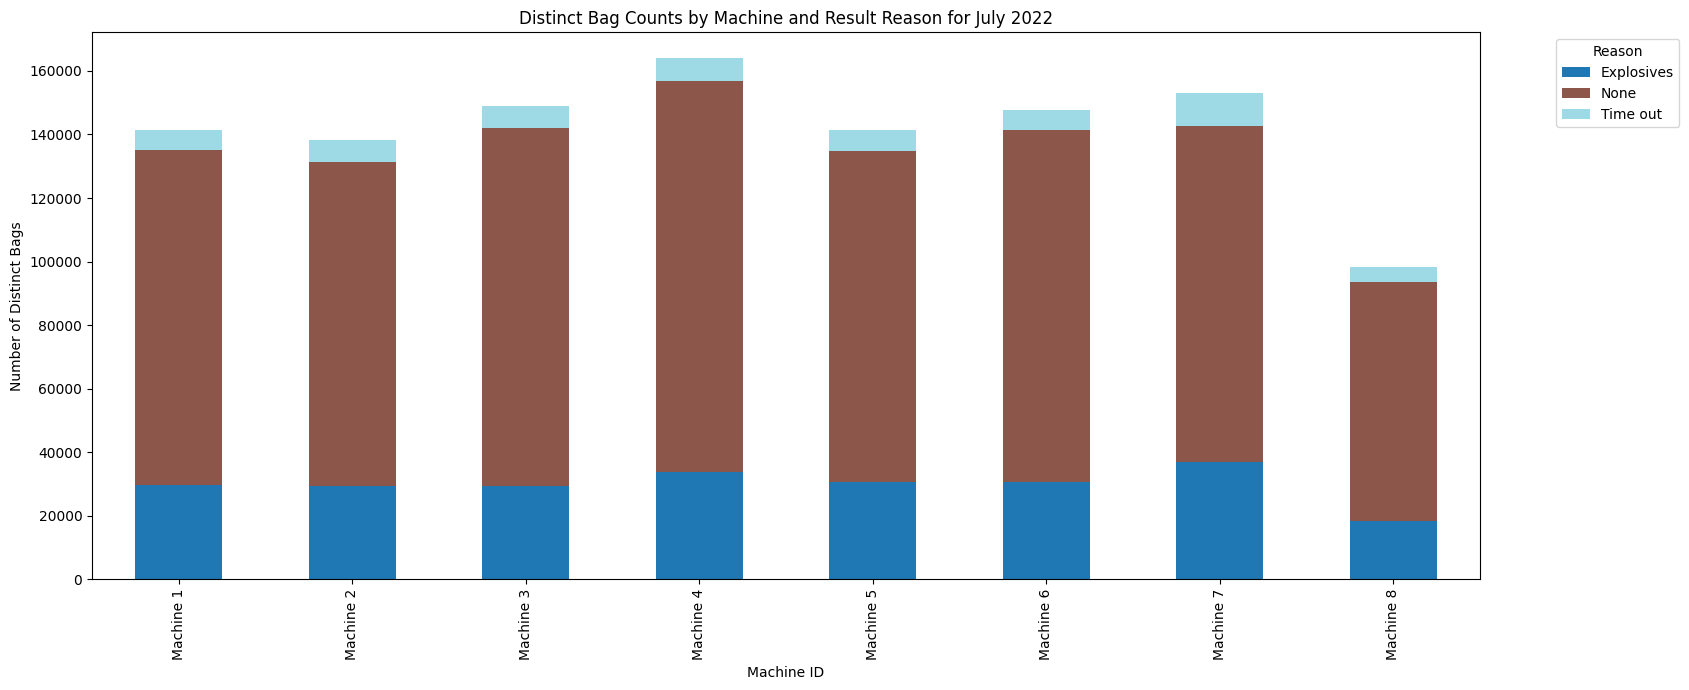

In [134]:
# Group by machine and result reason to get counts for each reason
reason_counts_by_machine = data.groupby(['scan_machine_id', 'scan_machine_result_reason'])['bag_licence_plate'].nunique().reset_index(name='distinct_count')

# Pivot the data for better visualization
reason_counts_pivot = reason_counts_by_machine.pivot(index='scan_machine_id', columns='scan_machine_result_reason', values='distinct_count').fillna(0)

# Plotting the stacked bar chart
reason_counts_pivot.plot(kind='bar', stacked=True, figsize=(15, 7), colormap="tab20")
plt.title('Distinct Bag Counts by Machine and Result Reason for July 2022')
plt.xlabel('Machine ID')
plt.ylabel('Number of Distinct Bags')
plt.tight_layout()
plt.legend(title="Reason", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 9. Stress Level

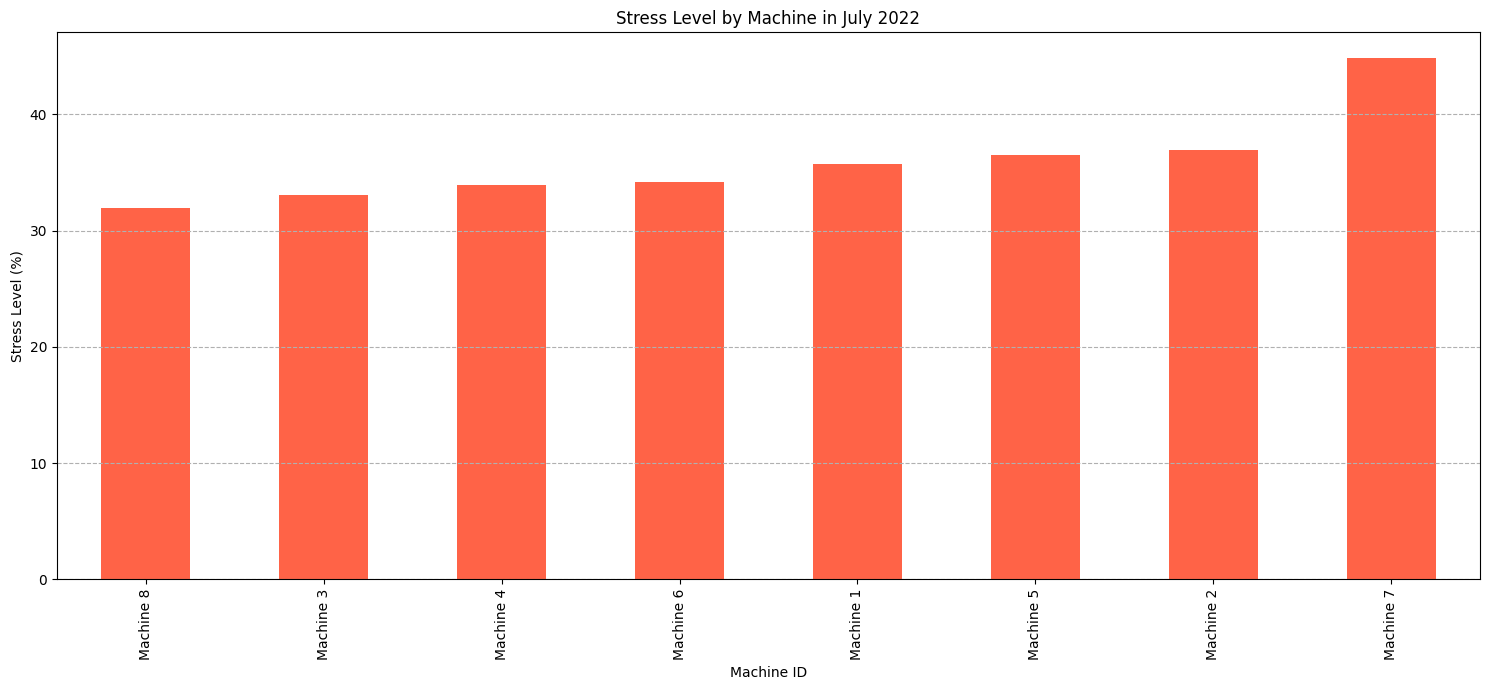

In [136]:
# Convert the timestamp column to a datetime object for easier manipulation
data['bag_scan_timestamp'] = pd.to_datetime(data['bag_scan_timestamp'])

# Create a distinct dataset
distinct_data = data.drop_duplicates(subset='bag_licence_plate')

# Group data by machine and result
machine_counts = distinct_data.groupby(['scan_machine_id', 'scan_machine_result']).size().reset_index(name='count')

# Pivot the data for better visualization
machine_pivot = machine_counts.pivot(index='scan_machine_id', columns='scan_machine_result', values='count').fillna(0)

# Compute the total bags processed by each machine
machine_pivot['Total'] = machine_pivot.sum(axis=1)

# Compute the stress level for each machine
machine_pivot['Stress Level (%)'] = ((machine_pivot['Rejected'] + machine_pivot['Unclear']) / machine_pivot['Total']) * 100

# Plotting
plt.figure(figsize=(15, 7))
machine_pivot['Stress Level (%)'].sort_values().plot(kind='bar', color='tomato')
plt.title('Stress Level by Machine in July 2022')
plt.xlabel('Machine ID')
plt.ylabel('Stress Level (%)')
plt.tight_layout()
plt.grid(axis='y', which="both", ls="--")
plt.show()

### 10. Error Rate Analysis

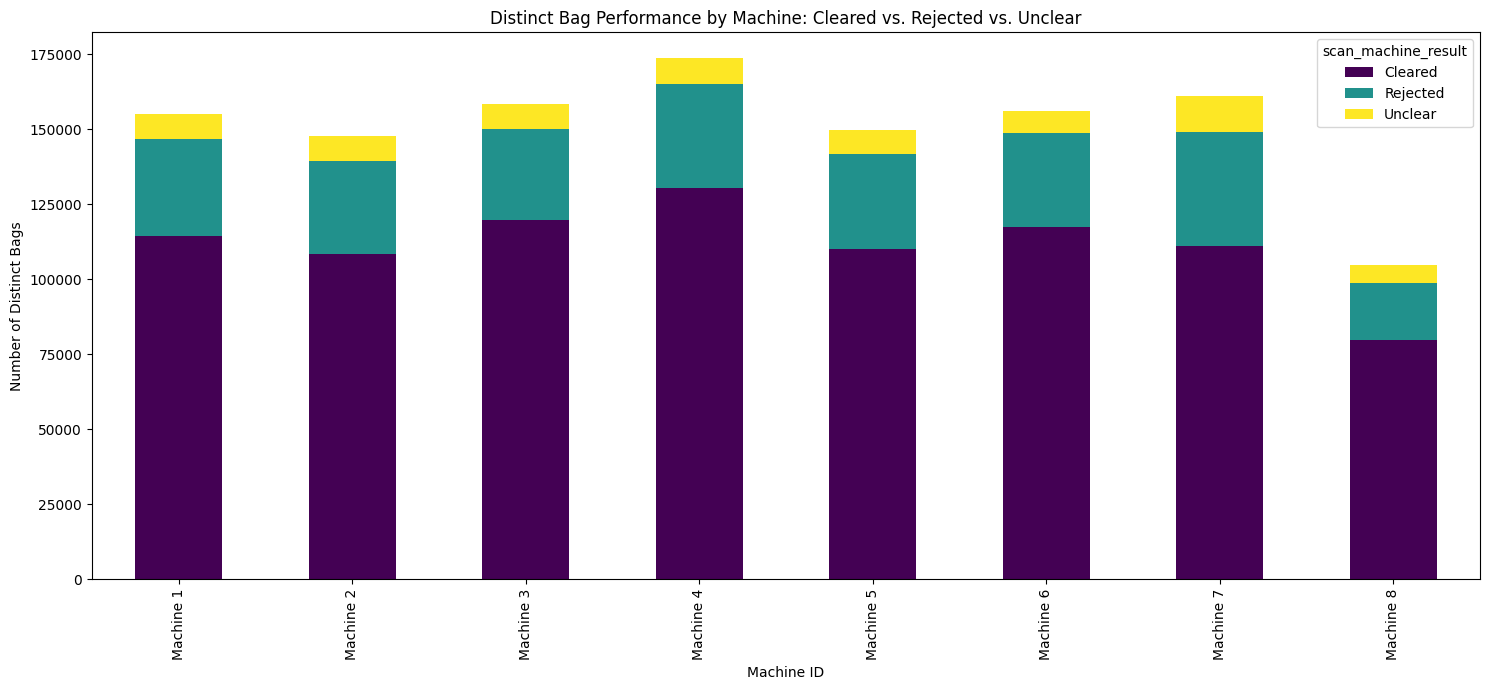

In [140]:
# Group by machine and result to get counts again
machine_performance = data_1.groupby(['scan_machine_id', 'scan_machine_result'])['bag_licence_plate'].nunique().reset_index(name='count')

# Pivot the data for better visualization
machine_performance_pivot = machine_performance.pivot(index='scan_machine_id', columns='scan_machine_result', values='count').fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
machine_performance_pivot.plot(kind='bar', stacked=True, colormap="viridis", ax=ax)
ax.set_title('Distinct Bag Performance by Machine: Cleared vs. Rejected vs. Unclear')
ax.set_xlabel('Machine ID')
ax.set_ylabel('Number of Distinct Bags')
plt.tight_layout()
plt.show()

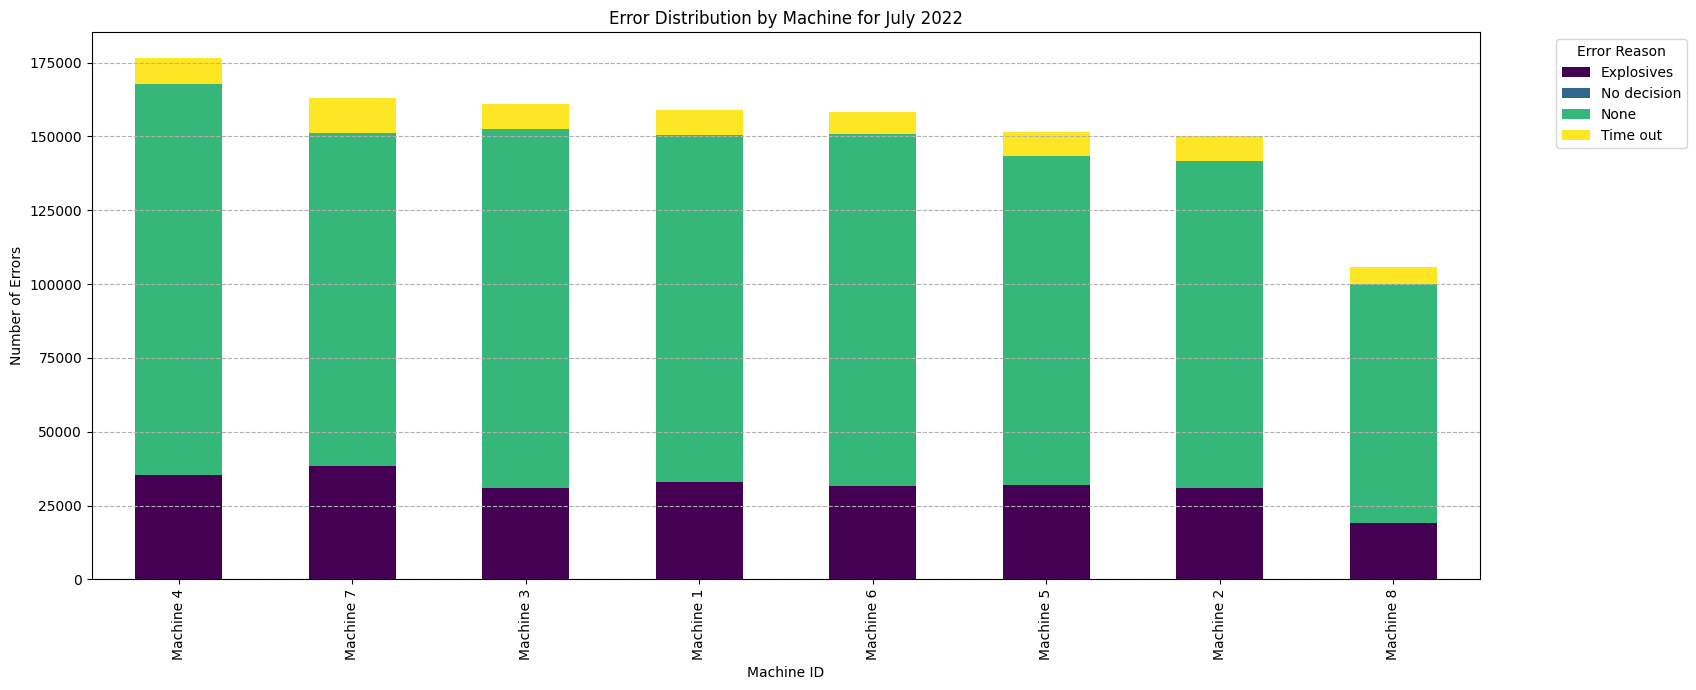

In [137]:
# Filter data for rows with 'Time out' and other result reasons
error_data = data_1[data_1['scan_machine_result_reason'].notna()]

# Group by machine and result reason to get counts
error_counts_by_machine = error_data.groupby(['scan_machine_id', 'scan_machine_result_reason']).size().reset_index(name='count')

# Pivot the data for better visualization
error_pivot = error_counts_by_machine.pivot(index='scan_machine_id', columns='scan_machine_result_reason', values='count').fillna(0)

# Compute the total errors for each machine
error_pivot['Total Errors'] = error_pivot.sum(axis=1)

# Sort the data based on total errors
sorted_error_pivot = error_pivot.sort_values(by='Total Errors', ascending=False)

# Plotting
sorted_error_pivot.drop(columns='Total Errors').plot(kind='bar', stacked=True, figsize=(15, 7), colormap="viridis")
plt.title('Error Distribution by Machine for July 2022')
plt.xlabel('Machine ID')
plt.ylabel('Number of Errors')
plt.tight_layout()
plt.legend(title='Error Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', which="both", ls="--")
plt.show()

### 11. 'Time Out' Analysis

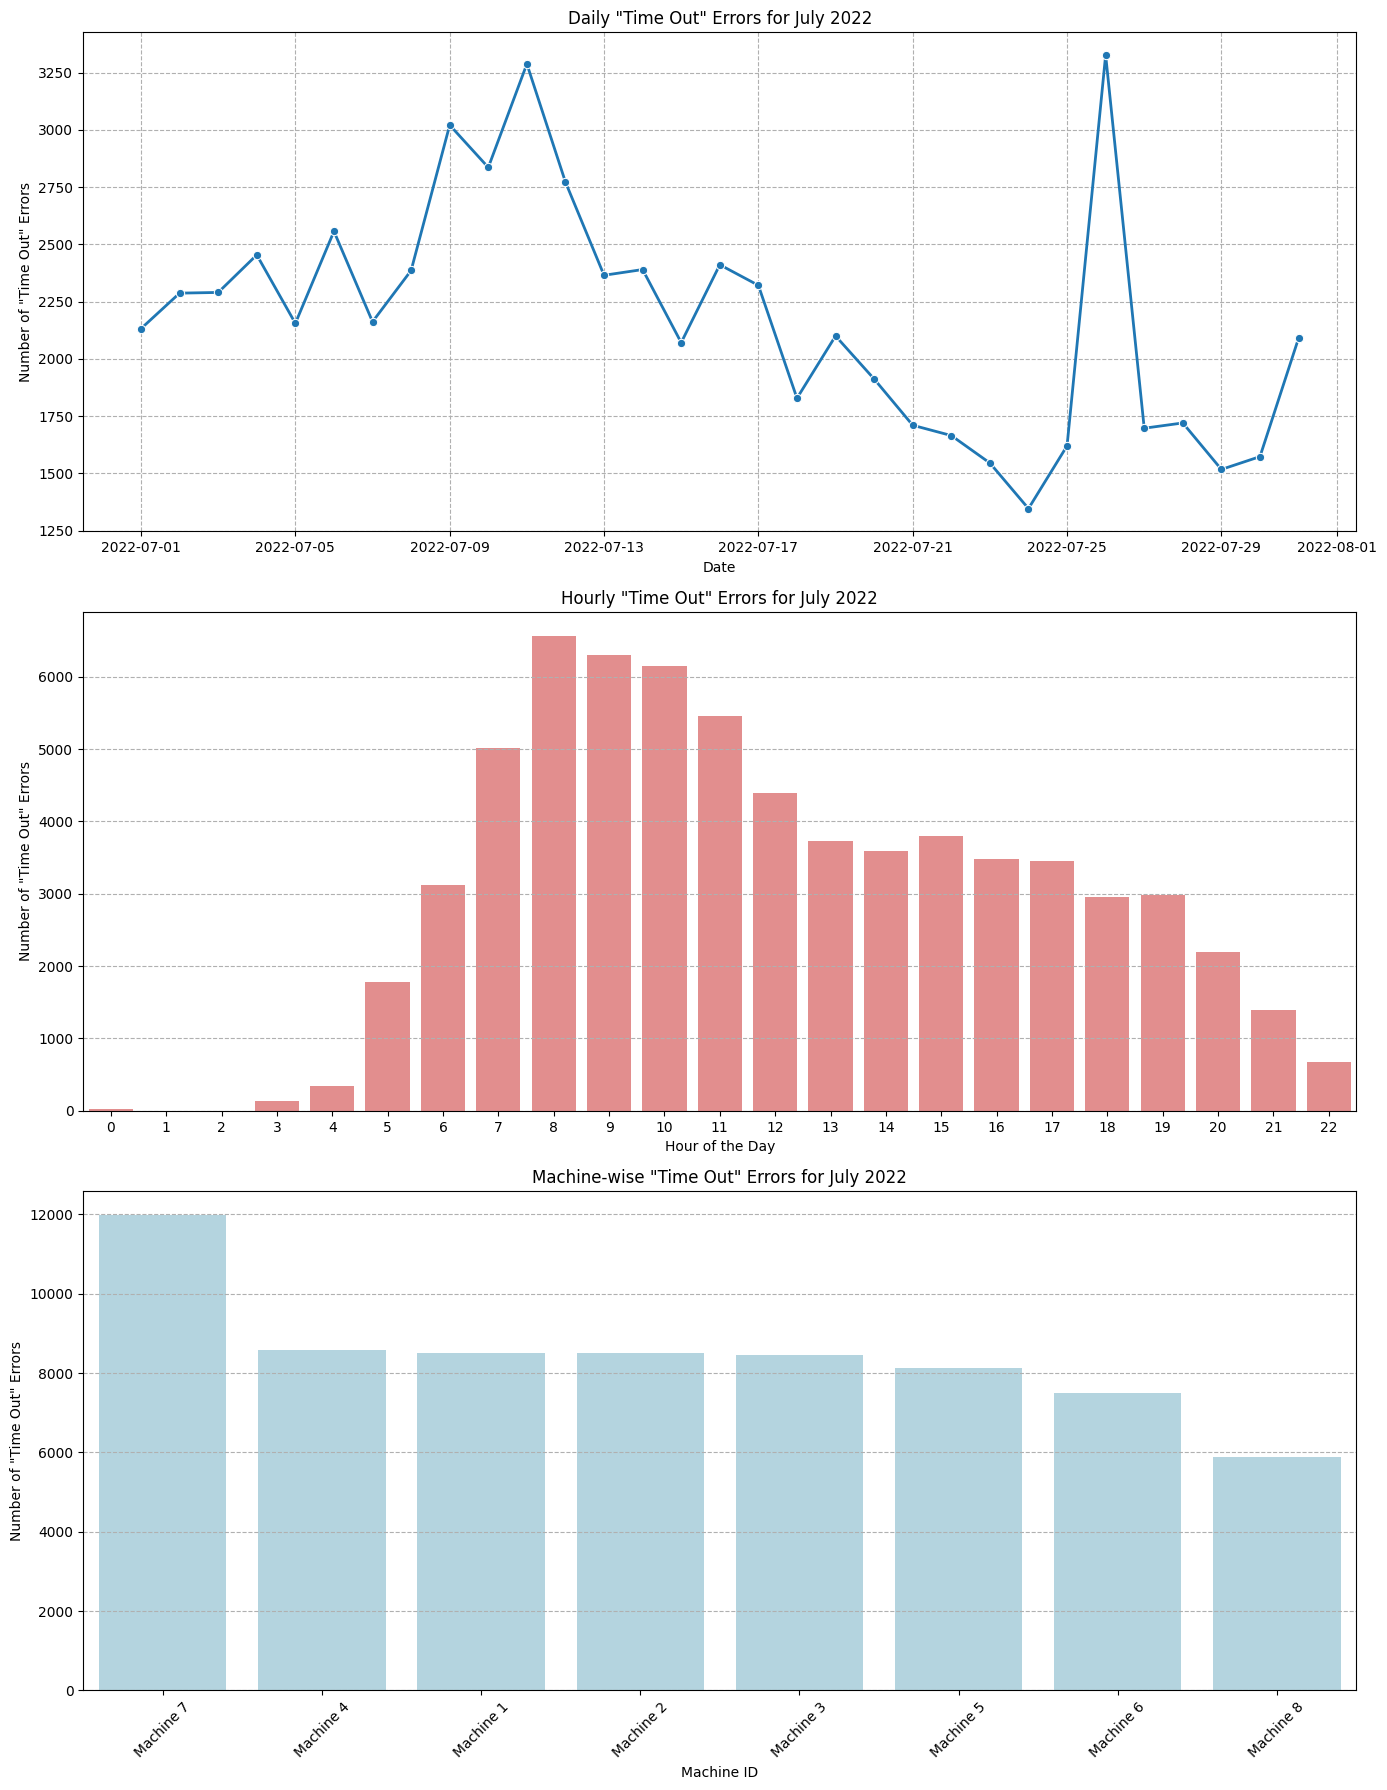

In [138]:
# Extract day and hour from 'bag_scan_timestamp' for further analysis
data_1['day'] = pd.to_datetime(data_1['bag_scan_timestamp']).dt.date
data_1['hour'] = pd.to_datetime(data_1['bag_scan_timestamp']).dt.hour

# Filter data for rows with 'Time out' reason
timeout_data = data_1[data_1['scan_machine_result_reason'] == 'Time out']

# 1. Overall daily distribution of "Time Out" errors in July
daily_timeouts = timeout_data.groupby('day').size().reset_index(name='timeout_count')

# 2. Hourly distribution of "Time Out" errors in July
hourly_timeouts = timeout_data.groupby('hour').size().reset_index(name='timeout_count')

# 3. Machine-wise distribution of "Time Out" errors in July
machine_timeouts = timeout_data.groupby('scan_machine_id').size().reset_index(name='timeout_count').sort_values(by='timeout_count', ascending=False)

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(14, 18))

# Daily distribution
sns.lineplot(data=daily_timeouts, x='day', y='timeout_count', marker="o", lw=2, ax=ax[0])
ax[0].set_title('Daily "Time Out" Errors for July 2022')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of "Time Out" Errors')
ax[0].grid(True, which="both", ls="--")

# Hourly distribution
sns.barplot(data=hourly_timeouts, x='hour', y='timeout_count', color='lightcoral', ax=ax[1])
ax[1].set_title('Hourly "Time Out" Errors for July 2022')
ax[1].set_xlabel('Hour of the Day')
ax[1].set_ylabel('Number of "Time Out" Errors')
ax[1].grid(axis='y', which="both", ls="--")

# Machine-wise distribution
sns.barplot(data=machine_timeouts, x='scan_machine_id', y='timeout_count', color='lightblue', ax=ax[2])
ax[2].set_title('Machine-wise "Time Out" Errors for July 2022')
ax[2].set_xlabel('Machine ID')
ax[2].set_ylabel('Number of "Time Out" Errors')
ax[2].grid(axis='y', which="both", ls="--")
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()